## Neural Network Method for Black Hole Imaging

## Import libraries and modules

In [24]:
import sys
import csv
import os
import numpy as np
import pandas as pd
import random
from numpy.random import randint
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
#from tf.keras.backend.tensorflow_backend import set_session
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomUniform, Constant
import keras.models
from keras.models import Sequential
import keras.layers
from keras.layers import Layer, Activation, LeakyReLU
from keras.layers import Input, InputLayer, AveragePooling2D, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate, Add
from keras.layers import Dense, Lambda, Reshape
import keras.initializers
import keras.regularizers
import keras.callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import losses
from keras.datasets import fashion_mnist
from keras.datasets import mnist

# Import eht imaging package
import ehtim as eh 
import ehtim.const_def as ehc
import ehtim.observing.obs_helpers as obsh
from ehtim.observing.obs_helpers import *
# Import helpers from cosense
#import helpers_posci as hp
# Import utilities for computing data terms, losses, and gradients
#from data_term_functions import *
##from models_posci import IsingVisNet, IsingCpAmpNet, IsingMutipleVisNet, IsingMutipleCpAmpNet, IsingVisFeatureNet, IsingCpAmpFeatureNet
#from losses_posci import site_sparsity, energy, Lambda_similarity, Lambda_angle_diff

In [25]:
'''Define observation parameters.'''
eht_array='EHT2019'
target='sgrA'

nsamp = 10000
npix = 32 
fov_param = 100.0
flux_label = 1
sefd_param = 1

tint_sec = 5    # integration time in seconds
tadv_sec = 600  # advance time between scans
tstart_hr = 0   # GMST time of the start of the observation
tstop_hr = 24   # GMST time of the end
bw_hz = 4e9     # bandwidth in Hz

stabilize_scan_phase = False # if true then add a single phase error for each scan to act similar to adhoc phasing
stabilize_scan_amp = False # if true then add a single gain error at each scan
jones = False # apply jones matrix for including noise in the measurements (including leakage)
inv_jones = False # no not invert the jones matrix
frcal = True # True if you do not include effects of field rotation
dcal = True # True if you do not include the effects of leakage
dterm_offset = 0 # a random offset of the D terms is given at each site with this standard deviation away from 1
dtermp = 0

array = '/Users/Johanna/Desktop/Proximal Gradient Descent/arrays/' + eht_array + '.txt'
eht = eh.array.load_txt(array)

# Define observation field of view
fov = fov_param * eh.RADPERUAS

# define scientific target
if target == 'm87':
    ra = 12.513728717168174
    dec = 12.39112323919932
elif target == 'sgrA':
    ra = 19.414182210498385
    dec = -29.24170032236311

rf = 230e9
mjd = 57853 # day of observation

In [26]:
fwhm = 1.117609542559987e-10

In [34]:
''' Define models and key functions '''

''' Return images and blurred images from dataset. Blur fashion and digits by 0.1*fwhm.'''
def get_data(dataset='fashion', flux=1):
    xdata = []
    pad_width = 2
    if (dataset == 'fashion' or dataset == 'all'):
        npix = 32
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

        xdata = 1.0*x_train[[k%60000 for k in range(int(nsamp))]]
        xdata = np.pad(xdata, ((0,0), (pad_width,pad_width), (pad_width,pad_width)), 'constant')
        xdata = xdata[..., np.newaxis]/255
        
        xdata = xdata.reshape((-1, npix*npix))
        
        # Blur images by 0.1*fwhm
        xdata_blur = []
        for X in xdata:
            pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
            pred_blur.imvec = X.flatten()
            pred_blur = pred_blur.blur_circ(fwhm_i=0.1*fwhm, fwhm_pol=0.1*fwhm)
            xdata_blur.append(pred_blur.imvec)
        xdata = xdata_blur
            
    if (dataset == 'mnist' or dataset == 'all'):
        npix = 32
        (x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
        
        xdata_train = 1.0*x_train_mnist[[k%60000 for k in range(int(nsamp))]]
        xdata_train = np.pad(xdata_train, ((0,0), (pad_width,pad_width), (pad_width,pad_width)), 'constant')  # get to 160x160
        xdata_train = xdata_train[..., np.newaxis]/255
        
        xdata = xdata_train.reshape((-1, npix*npix))
        
        # Blur images by 0.1*fwhm
        xdata_blur = []
        for X in xdata:
            pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
            pred_blur.imvec = X.flatten()
            pred_blur = pred_blur.blur_circ(fwhm_i=0.1*fwhm, fwhm_pol=0.1*fwhm)
            xdata_blur.append(pred_blur.imvec)
        xdata = xdata_blur
        
    if (dataset == 'bh_data'):
        bh_sim_data = np.load('/Users/Johanna/Desktop/Neural Network/bh_sim_data.npy', allow_pickle=True).item()
        bh_data = bh_sim_data['image']
        
        # resize images to 32 x 32 and fov = 100
        bh_data = np.array(bh_data)
        bh_data_reshape = []
        for i in range(len(bh_data)):
            bh_img = eh.image.make_empty(160, 160, ra, dec, rf=rf, source='random', mjd=mjd)
            bh_img.imvec = bh_data[i].flatten()
            bh_img_reshape = bh_img.regrid_image(100, 32)
            bh_data_reshape.append(bh_img_reshape.imvec)
        xdata = np.array(bh_data_reshape).reshape((-1, 32*32))
    
    # Adjust image flux
    '''
    if flux != None:
        x_flux = np.sum(np.abs(xdata), axis=1)
        x_flux = x_flux.reshape((len(x_flux), 1))
        xdata = (flux/x_flux)*np.abs(xdata)
    '''
    
    return xdata

# Generate observations for image X using specified parameters. 
def get_measurements(X, th_noise=False, amp_error=False, phase_error=False, gainp=0.1, gain_offset=0.1):
    # Define noise parameters
    add_th_noise = th_noise # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
    phasecal = not phase_error # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
    ampcal = not amp_error # True if you don't want to add atmospheric amplitude error. if False then add random gain errors 

    simim = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    simim.imvec = X
    
    # generate the discrete Fourier transform matrices for complex visibilities
    obs = simim.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal, 
                    stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp,
                    jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, dterm_offset=dterm_offset, 
                    gainp=gainp, gain_offset=gain_offset)
    obs_data = obs.unpack(['u', 'v', 'vis', 'sigma'])
    
    uv = np.hstack((obs_data['u'].reshape(-1,1), obs_data['v'].reshape(-1,1)))
    
    # Extract forward model (Discrete Fourier Transform matrix)
    F_vis = ftmatrix(simim.psize, simim.xdim, simim.ydim, uv, pulse=simim.pulse)
    vis = obs_data['vis']
    sigma_vis = obs_data['sigma']
    t1 = obs.data['t1']
    t2 = obs.data['t2']
    
    print("Finished computing visibilities...")
    
    # generate the discrete Fourier transform matrices for closure phases
    obs.add_cphase(count='max')
    # Extract forward models for telescopes 1, 2, and 3
    tc1 = obs.cphase['t1']
    tc2 = obs.cphase['t2']
    tc3 = obs.cphase['t3']
    
    cphase = obs.cphase['cphase']
    sigma_cphase = obs.cphase['sigmacp']
    cphase_map = np.zeros((len(obs.cphase['time']), 3))

    zero_symbol = 10000
    for k1 in range(cphase_map.shape[0]):
        for k2 in list(np.where(obs.data['time']==obs.cphase['time'][k1])[0]):
            if obs.data['t1'][k2] == obs.cphase['t1'][k1] and obs.data['t2'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = k2
                if k2 == 0:
                    cphase_map[k1, 0] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t1'][k1] and obs.data['t1'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = -k2
                if k2 == 0:
                    cphase_map[k1, 0] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t2'][k1] and obs.data['t2'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = k2
                if k2 == 0:
                    cphase_map[k1, 1] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t2'][k1] and obs.data['t1'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = -k2
                if k2 == 0:
                    cphase_map[k1, 1] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t3'][k1] and obs.data['t2'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = k2
                if k2 == 0:
                    cphase_map[k1, 2] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t3'][k1] and obs.data['t1'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = -k2
                if k2 == 0:
                    cphase_map[k1, 2] = -zero_symbol

    F_cphase = np.zeros((cphase_map.shape[0], npix*npix, 3), dtype=np.complex64)
    cphase_proj = np.zeros((cphase_map.shape[0], F_vis.shape[0]), dtype=np.float32)
    for k in range(cphase_map.shape[0]):
        for j in range(cphase_map.shape[1]):
            if cphase_map[k][j] > 0:
                if int(cphase_map[k][j]) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = F_vis[int(cphase_map[k][j]), :]
                cphase_proj[k, int(cphase_map[k][j])] = 1
            else:
                if np.abs(int(cphase_map[k][j])) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = np.conj(F_vis[int(-cphase_map[k][j]), :])
                cphase_proj[k, int(-cphase_map[k][j])] = -1
                
    # generate the discrete Fourier transform matrices for closure amplitudes
    #obs.add_camp(count='max')
    
    # debias = True or False??
    clamparr = obs.c_amplitudes(mode='all', count='max',
                                        vtype='vis', ctype='camp', debias=True, snrcut=0.0)
    

    uv1 = np.hstack((clamparr['u1'].reshape(-1, 1), clamparr['v1'].reshape(-1, 1)))
    uv2 = np.hstack((clamparr['u2'].reshape(-1, 1), clamparr['v2'].reshape(-1, 1)))
    uv3 = np.hstack((clamparr['u3'].reshape(-1, 1), clamparr['v3'].reshape(-1, 1)))
    uv4 = np.hstack((clamparr['u4'].reshape(-1, 1), clamparr['v4'].reshape(-1, 1)))
    camp = clamparr['camp']
    sigma_camp = clamparr['sigmaca']
    
    mask = []
    # shape: (4, 2022, npix**2)
    F_camp = (ftmatrix(simim.psize, simim.xdim, simim.ydim, uv1, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv2, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv3, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv4, pulse=simim.pulse, mask=mask)
          )
    
    return obs, vis, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2

'''
# Generate observations for image X using specified parameters. 
def get_measurements(X, th_noise=False, amp_error=False, phase_error=False, gainp=0.1, gain_offset=0.1):
    # Define noise parameters
    add_th_noise = th_noise # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
    phasecal = not phase_error # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
    ampcal = not amp_error # True if you don't want to add atmospheric amplitude error. if False then add random gain errors 

    simim = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    simim.imvec = X
    
    # generate the discrete Fourier transform matrices for complex visibilities
    obs = simim.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal, 
                    stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp,
                    jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, dterm_offset=dterm_offset, 
                    gainp=gainp, gain_offset=gain_offset)
    obs_data = obs.unpack(['u', 'v', 'vis', 'sigma'])
    
    uv = np.hstack((obs_data['u'].reshape(-1,1), obs_data['v'].reshape(-1,1)))
    
    # Extract forward model (Discrete Fourier Transform matrix)
    F_vis = ftmatrix(simim.psize, simim.xdim, simim.ydim, uv, pulse=simim.pulse)
    vis = obs_data['vis']
    sigma_vis = obs_data['sigma']
    obs.data['sigma'] = (sigma_vis * 224.46)/np.sum(sigma_vis)
    t1 = obs.data['t1']
    t2 = obs.data['t2']
    
    print("Finished computing visibilities...")
    
    # generate the discrete Fourier transform matrices for closure phases
    obs.add_cphase(count='max')
    # Extract forward models for telescopes 1, 2, and 3
    tc1 = obs.cphase['t1']
    tc2 = obs.cphase['t2']
    tc3 = obs.cphase['t3']
    
    cphase = obs.cphase['cphase']
    sigma_cphase = obs.cphase['sigmacp']
    cphase_map = np.zeros((len(obs.cphase['time']), 3))

    zero_symbol = 10000
    for k1 in range(cphase_map.shape[0]):
        for k2 in list(np.where(obs.data['time']==obs.cphase['time'][k1])[0]):
            if obs.data['t1'][k2] == obs.cphase['t1'][k1] and obs.data['t2'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = k2
                if k2 == 0:
                    cphase_map[k1, 0] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t1'][k1] and obs.data['t1'][k2] == obs.cphase['t2'][k1]:
                cphase_map[k1, 0] = -k2
                if k2 == 0:
                    cphase_map[k1, 0] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t2'][k1] and obs.data['t2'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = k2
                if k2 == 0:
                    cphase_map[k1, 1] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t2'][k1] and obs.data['t1'][k2] == obs.cphase['t3'][k1]:
                cphase_map[k1, 1] = -k2
                if k2 == 0:
                    cphase_map[k1, 1] = -zero_symbol
            elif obs.data['t1'][k2] == obs.cphase['t3'][k1] and obs.data['t2'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = k2
                if k2 == 0:
                    cphase_map[k1, 2] = zero_symbol
            elif obs.data['t2'][k2] == obs.cphase['t3'][k1] and obs.data['t1'][k2] == obs.cphase['t1'][k1]:
                cphase_map[k1, 2] = -k2
                if k2 == 0:
                    cphase_map[k1, 2] = -zero_symbol

    F_cphase = np.zeros((cphase_map.shape[0], npix*npix, 3), dtype=np.complex64)
    cphase_proj = np.zeros((cphase_map.shape[0], F_vis.shape[0]), dtype=np.float32)
    for k in range(cphase_map.shape[0]):
        for j in range(cphase_map.shape[1]):
            if cphase_map[k][j] > 0:
                if int(cphase_map[k][j]) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = F_vis[int(cphase_map[k][j]), :]
                cphase_proj[k, int(cphase_map[k][j])] = 1
            else:
                if np.abs(int(cphase_map[k][j])) == zero_symbol:
                    cphase_map[k][j] = 0
                F_cphase[k, :, j] = np.conj(F_vis[int(-cphase_map[k][j]), :])
                cphase_proj[k, int(-cphase_map[k][j])] = -1
                
    # generate the discrete Fourier transform matrices for closure amplitudes
    #obs.add_camp(count='max')
    
    # debias = True or False??
    clamparr = obs.c_amplitudes(mode='all', count='max',
                                        vtype='vis', ctype='camp', debias=True, snrcut=0.0)
    

    uv1 = np.hstack((clamparr['u1'].reshape(-1, 1), clamparr['v1'].reshape(-1, 1)))
    uv2 = np.hstack((clamparr['u2'].reshape(-1, 1), clamparr['v2'].reshape(-1, 1)))
    uv3 = np.hstack((clamparr['u3'].reshape(-1, 1), clamparr['v3'].reshape(-1, 1)))
    uv4 = np.hstack((clamparr['u4'].reshape(-1, 1), clamparr['v4'].reshape(-1, 1)))
    camp = clamparr['camp']
    sigma_camp = clamparr['sigmaca']
    
    mask = []
    # shape: (4, 2022, npix**2)
    F_camp = (ftmatrix(simim.psize, simim.xdim, simim.ydim, uv1, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv2, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv3, pulse=simim.pulse, mask=mask),
          ftmatrix(simim.psize, simim.xdim, simim.ydim, uv4, pulse=simim.pulse, mask=mask)
          )
    
    return obs, vis, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2
'''

# Split into Training and Testing Sets (Complex Visibilities)
def split_data(X, vis):
    split = int(0.9*len(xdata))
    X_train = vis[:split]
    y_train = xdata[:split].reshape((len(X_train), npix, npix, 1))
    X_test = vis[split:]
    y_test = xdata[split:].reshape((len(X_test), npix, npix, 1))
    
    return X_train, y_train, X_test, y_test

# Post Processing
def post_process(Z, img):
    flux, X_max = np.sum(img), np.max(img)

    # Normalize flux to target image
    Z_flux = np.sum(np.abs(Z))
    Z = (flux/Z_flux)*np.abs(Z)

    # Normalize Z between 0 and X_max
    Z = np.maximum(np.zeros(np.shape(Z)), Z)
    Z = np.minimum(X_max*np.ones(np.shape(Z)), Z)
    
    return Z

# Compute normalized cross-correlation between images X and Z
def compute_xcorr(X, Z):
    target_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    target_img.imvec = X.flatten()
    recon_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    recon_img.imvec = Z.flatten()
    xc = target_img.compare_images(recon_img)[0][0] 
    return xc
    
# Compute MAE loss 
from sklearn.metrics import mean_absolute_error
def compute_mae(X, Z):
    mae = mean_absolute_error(X.flatten(), Z.flatten())
    return mae

# Compute SSIM
from skimage.metrics import structural_similarity as ssim
def compute_ssim(X, Z):
    return ssim(X.flatten(), Z.flatten())
    
''' Show results '''
def visualize(result, obs):
    # Unpack values
    [target, pred, uncertainty, error, vis_chisq, cphase_chisq, camp_chisq, mae, ssim] = result
    
    max_color = 0.01
    if dataset == 'fashion':
        max_color = 0.005
    
    # Compute nominally blurred target image
    fwhm = obs.res()
    target_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    target_blur.imvec = target.flatten()
    target_blur1 = target_blur.blur_circ(fwhm_i=0.3*fwhm, fwhm_pol=0.3*fwhm)
    target_blur2 = target_blur.blur_circ(fwhm_i=0.7*fwhm, fwhm_pol=0.7*fwhm)
    
    # Show nominally blurred target image
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

    ground_truth = ax1.imshow((target).reshape(npix, npix), vmin=0, vmax=max_color)
    ax1.title.set_text('Ground Truth')
    fig.colorbar(ground_truth, ax=ax1)
    blur1 = ax2.imshow(target_blur1.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax2.title.set_text('0.3 * fwhm Blurred Truth')
    fig.colorbar(blur1, ax=ax2)
    blur2 = ax3.imshow(target_blur2.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax3.title.set_text('0.7 * fwhm Blurred Truth')
    cbar = fig.colorbar(blur2, ax=ax3)
    cbar.minorticks_on()
    plt.show()
    
    # Compute nominally blurred predicted image
    fwhm = obs.res()
    pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_blur.imvec = pred.flatten()
    pred_blur1 = pred_blur.blur_circ(fwhm_i=0.3*fwhm, fwhm_pol=0.3*fwhm)
    pred_blur2 = pred_blur.blur_circ(fwhm_i=0.7*fwhm, fwhm_pol=0.7*fwhm)
    
    # Visualize blurred results
    fig3, (ax7, ax8, ax9) = plt.subplots(figsize=(13, 3), ncols=3)

    pred_img = ax7.imshow(pred.reshape(npix, npix), vmin=0, vmax=max_color)
    ax7.title.set_text('Predicted Image')
    fig3.colorbar(pred_img, ax=ax7)
    blur1_img = ax8.imshow(pred_blur1.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax8.title.set_text('0.3 * fwhm blur')
    fig3.colorbar(blur1_img, ax=ax8)
    blur2_img = ax9.imshow(pred_blur2.imvec.reshape(npix, npix), vmin=0, vmax=max_color)
    ax9.title.set_text('0.7 * fwhm blur')
    fig3.colorbar(blur2_img, ax=ax9)
    cbar.minorticks_on()
    plt.show()
           
    # Visualize uncertainty
    fig2, (ax4, ax5, ax6) = plt.subplots(figsize=(13, 3), ncols=3)

    pred_img = ax4.imshow(pred.reshape(npix, npix), vmin=0, vmax=max_color)
    ax4.title.set_text('Predicted Image')
    fig2.colorbar(pred_img, ax=ax4)
    uncertainty_img = ax5.imshow(uncertainty.reshape(npix, npix), vmin=0, vmax=max_color)
    ax5.title.set_text('Pixel-Wise Uncertainty')
    fig2.colorbar(uncertainty_img, ax=ax5)
    error_img = ax6.imshow(error.reshape(npix, npix), vmin=0, vmax=max_color)
    ax6.title.set_text('Absolute Error')
    fig2.colorbar(error_img, ax=ax6)
    cbar.minorticks_on()
    plt.show()
    
    
    print("Vis Chi^2 = ", round(vis_chisq, 10))
    #print("Cphase Chi^2 = ", round(cphase_chisq, 4))
    #print("Camp Chi^2 = ", round(camp_chisq, 4))
    print("MAE = ", mae)
    print("SSIM = ", ssim)

    print()

''' Get resolution of reconstructed image: blurred target image versus predicted image. '''
def get_res(recon, target, obs, simim1, simim2):
    # Create target and recon image objects
    target_img = simim1
    target_img.imvec = target.flatten()
    recon_img = simim2
    recon_img.imvec = recon.flatten()
        
    # Compute cross-correlation b/w recon and target images
    recon_xc = target_img.compare_images(recon_img)[0][0]
    
    alphas = np.linspace(0, 50, 1000)
    xcorr = []
    for alpha in alphas:
        target_blur = target_img.blur_circ(alpha*eh.RADPERUAS) # Add gaussian blur in micro-arcsecs
        xc = target_blur.compare_images(recon_img)[0][0] # Get normalized cross-correlation
        xcorr.append(xc)
            
    # Get nominal resolution
    nominal_res = obs.res()
    
    # Get image resolution
    recon_alpha = np.array(xcorr).argmax()*50/1000 # Get index of blurring parameter with highest xcorr
    
    # Show Plot
    plt.figure()
    plt.plot(alphas, xcorr, label="XCorr")
    plt.axvline(x=nominal_res/eh.RADPERUAS, label = "Nominal Resolution (uas)", color='m')
    if recon_alpha is not None:
        plt.axvline(x=recon_alpha, label = "Reconstruction Resolution (uas)", color='g')
    plt.ylim(0.6, 1)
    plt.xlim(0, 50)
    plt.xlabel("Blurring Parameter, alpha (uas)")
    plt.ylabel("Normalized XCorr")
    plt.title("XCorr of Blurred Target/Reconstruction vs. Alpha")
    plt.legend(loc='lower left')
    plt.show()
    
    print("Reconstruction XC = ", recon_xc)
    print("Reconstruction Alpha = ", recon_alpha)
    
    return recon_xc

def compute_snr(X, sigma):
    # Define noise parameters
    add_th_noise = False # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
    phasecal = True # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
    ampcal = True # True if you don't want to add atmospheric amplitude error. if False then add random gain errors 

    simim = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    simim.imvec = X
    
    # generate the discrete Fourier transform matrices for complex visibilities
    obs = simim.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal, 
                    stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp,
                    jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, dterm_offset=dterm_offset)
    obs_data = obs.unpack(['u', 'v', 'vis', 'sigma'])
    
    vis = obs_data['vis']
    
    snr = np.mean(vis**2) / np.mean(sigma**2)
    
    return snr

def chisq_loss(x_true0, x_pred0):
    F = tf.cast(tf.constant(global_F), tf.complex64)
    S = tf.cast(tf.constant(global_S), tf.float32)
    
    # Flatten and normalize image arrays
    x_true0 = tf.cast(tf.reshape(x_true0, [-1, 1024]), tf.complex64)
    x_pred0 = tf.cast(tf.reshape(x_pred0, [-1, 1024]), tf.complex64)
    x_true0 = tf.math.divide(x_true0, [500])#tf.transpose(tf.cast(tf.reduce_sum(x_true0, 1), tf.complex64)))
    x_pred0 = tf.math.divide(x_pred0, [500])#tf.transpose(tf.cast(tf.reduce_sum(x_pred0, 1), tf.complex64)))

    # Compute visibilities
    vis_true = tf.matmul(x_true0, tf.transpose(F))
    vis_pred = tf.matmul(x_pred0, tf.transpose(F))

    # numerator
    num = tf.reduce_sum(tf.square(tf.divide(tf.abs(tf.subtract(vis_pred, vis_true)), S[:,0])))
    
    chisq = tf.divide(num, tf.cast(tf.multiply(2, tf.size(vis_true[0])), tf.float32))
    
    return chisq

def plotall(obs, field1, field2, conj=False, debias=True, tag_bl=False, 
            ang_unit='deg', timetype=False,  axis=False, rangex=False, 
            rangey=False, snrcut=0., color='b', marker='o', 
            markersize=ehc.MARKERSIZE, label=None, grid=True, ebar=True, 
            axislabels=True, legend=False, show=False):
    bllist = [['All', 'All']]
    colors = ehc.SCOLORS[0]

    # unpack data
    alldata = [obs.unpack([field1, field2],
                           conj=conj, ang_unit=ang_unit, debias=debias, timetype=timetype)]

    # X error bars
    if obsh.sigtype(field1):
        allsigx = obs.unpack(obsh.sigtype(field2), conj=conj, ang_unit=ang_unit)
        allsigx = [allsigx[obsh.sigtype(field1)]]
    else:
        allsigx = [None]

    # Y error bars
    if obsh.sigtype(field2):
        allsigy = obs.unpack(obsh.sigtype(field2), conj=conj, ang_unit=ang_unit)
        allsigy = [allsigy[obsh.sigtype(field2)]]
        
    else:
        allsigy = [None]
            
    # make plot(s)
    if axis:
        x = axis
    else:
        fig = plt.figure()
        x = fig.add_subplot(1, 1, 1)

    xmins = []
    xmaxes = []
    ymins = []
    ymaxes = []
    for i in range(len(alldata)):
        data = alldata[i]
        sigy = allsigy[i]
        sigx = allsigx[i]
        color = colors[i]
        bl = bllist[i]

        # Flag out nans (to avoid problems determining plotting limits)
        mask = ~(np.isnan(data[field1]) + np.isnan(data[field2]))

        # Flag out due to snrcut
        if snrcut > 0.:
            sigs = [sigx, sigy]
            for jj, field in enumerate([field1, field2]):
                if field in ehc.FIELDS_AMPS:
                    fmask = data[field] / sigs[jj] > snrcut
                elif field in ehc.FIELDS_PHASE:
                    fmask = sigs[jj] < (180. / np.pi / snrcut)
                elif field in ehc.FIELDS_SNRS:
                    fmask = data[field] > snrcut
                else:
                    fmask = np.ones(mask.shape).astype(bool)
                mask *= fmask

        data = data[mask]
        if sigy is not None:
            sigy = sigy[mask]
        if sigx is not None:
            sigx = sigx[mask]
        if len(data) == 0:
            continue

        xmins.append(np.min(data[field1]))
        xmaxes.append(np.max(data[field1]))
        ymins.append(np.min(data[field2]))
        ymaxes.append(np.max(data[field2]))
        
        tolerance = len(data[field2])
        
        if ebar and (np.any(sigy) or np.any(sigx)):
            print("sigx = ", sigx)
            print("sigy = ", sigy)
            x.errorbar(data[field1], data[field2], xerr=sigx, yerr=sigy, label='',
                        fmt=marker, markersize=markersize, picker=tolerance)
        else:
            x.plot(data[field1], data[field2], marker, markersize=markersize, picker=tolerance)

                
        # Plot the data
        tolerance = len(data[field2])

        x.plot(data[field1], data[field2], marker, markersize=markersize)
        
    # Data ranges
    if not rangex:
        rangex = [np.min(xmins) - 0.2 * np.abs(np.min(xmins)),
                  np.max(xmaxes) + 0.2 * np.abs(np.max(xmaxes))]
        if np.any(np.isnan(np.array(rangex))):
            print("Warning: NaN in data x range: specifying rangex to default")
            rangex = [-100, 100]

    if not rangey:
        rangey = [np.min(ymins) - 0.2 * np.abs(np.min(ymins)),
                  np.max(ymaxes) + 0.2 * np.abs(np.max(ymaxes))]
        if np.any(np.isnan(np.array(rangey))):
            print("Warning: NaN in data y range: specifying rangey to default")
            rangey = [-100, 100]

    x.set_xlim(rangex)
    x.set_ylim(rangey)
    x.set_xlabel(field1)
    x.set_ylabel(field2)
    x.set_title(field1 + " versus " + field2)
    x.grid
    #plt.legend()
    
    #if show:
        #plt.show(block=False)
    
    return x, data[field1], data[field2]
    
''' Predict with Model and Compute Metrics '''
def predict_and_run_test(model, target, ALPHA, th_noise, amp_err, phase_err, gainp=0.1, gain_offset=0.1, th_noise_factor=0, blur_param=0, savefile=None, pred_img=None):
    # Normalize fluxes
    pred_img = pred_img/np.sum(pred_img)
    target /= np.sum(target)
        
    if th_noise_factor == 0:
        th_noise = False
       
    obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(target.flatten(), th_noise, amp_err, phase_err, gainp, gain_offset)  # data terms
    
    # Blur target to 0.3*fwhm
    fwhm = obs.res()
    target_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    target_blur.imvec = target.flatten()
    target_blur = target_blur.blur_circ(fwhm_i=0.3*fwhm, fwhm_pol=0.3*fwhm)
    target = target_blur.imvec
        
    obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(target.flatten(), th_noise, amp_err, phase_err, gainp, gain_offset)  # data terms
    
    if savefile is not None:
        obs.save_txt(savefile+'_obs')
    
    # add additional layers  of thermal noise
    if th_noise_factor > 0:
        noise_arr = [th_noise_factor*np.random.normal(0, sigma) for sigma in sigma_vis]
        visibility += noise_arr
        sigma_vis *= th_noise_factor
        print("Adding additional thermal noise.... mean = ", (th_noise_factor + 1)*np.mean(np.abs(noise_arr)))
    
    print("SNR = ", compute_snr(target, sigma_vis))
    
    # Pre-process data for UNet
    #target *= ALPHA
    visibility *= ALPHA
    sigma_vis *= ALPHA

    recon_imgs = []
    num_tests = 16
    for n in range(num_tests):   
        img = model.predict(visibility.reshape((-1, visibility.shape[0])))
        recon_imgs.append(img)

    imgs = np.array(recon_imgs)
    pred = np.mean(imgs, axis=0)

    # Post-process
    visibility /= ALPHA
    imgs /= ALPHA
    pred /= ALPHA

    #pred = post_process(pred, target)
    uncertainty = np.sqrt(2*(np.mean(imgs ** 2, axis=0)) + (np.std(imgs) ** 2))
    std = np.sqrt(np.var(imgs, axis=0))
    error = np.subtract(pred.flatten(), target.flatten()) 

    print("Total Uncertainty: ", np.sum(uncertainty))
    print("Total STD: ", np.sum(std))
    print("Total Error: ", np.sum(error))

    print("PRED: ", np.sum(pred))
    print("TARGET: ", np.sum(target))

    #obs2, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp = get_measurements(pred.flatten(), th_noise, amp_err, phase_err, gainp, gain_offset)  # data terms
    #plotall(obs2, 'uvdist', 'amp')
    #plotall(obs2, 'uvdist', 'phase')

    # Compute chi^2 values with observations
    pred_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_img.imvec = (pred).flatten()
    vis_chisq = obs.chisq(pred_img,dtype='vis') 
    cphase_chisq = obs.chisq(pred_img,dtype='cphase') 
    camp_chisq = obs.chisq(pred_img, dtype='camp')

    if savefile is not None:
        target_blur.save_fits(savefile+'_img')

    # Compute cross-correlation
    recon_xc = compute_xcorr(target, pred/ALPHA)

    # Visualize results
    result = [target, pred, std, error, vis_chisq, cphase_chisq, camp_chisq, recon_xc]
    visualize(result, obs)

    return vis_chisq, cphase_chisq, camp_chisq, recon_xc

''' Compute Metrics with Pre-Computed Image '''
def run_test(target, pred, fwhm, th_noise=False, amp_err=False, phase_err=False, gainp=0.1, gain_offset=0.1, blur_param=0.0):
    # Normalize fluxes for EHTIM functions
    pred /= np.sum(pred)
    target /= np.sum(target)
    
    print("Flux of Target = ", np.sum(target))
    print("Flux of Pred = ", np.sum(pred))
    
    nonblur_target = target
    
    # Blur target by blur_param
    target_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    target_blur.imvec = target.flatten()
    target_blur = target_blur.blur_circ(fwhm_i=blur_param*fwhm, fwhm_pol=blur_param*fwhm)
    target = target_blur.imvec
    
    obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(target.flatten(), th_noise, amp_err, phase_err, gainp, gain_offset)  # data terms
    
    # Normalize sigma
    sigma_vis /= np.sum(sigma_vis)
    
    # Apply blur to predicted image
    fwhm = obs.res()
    pred_unblur = pred
    pred_blur = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_blur.imvec = pred.flatten()
    pred_blur = pred_blur.blur_circ(fwhm_i=blur_param*fwhm, fwhm_pol=blur_param*fwhm)
    pred = pred_blur.imvec
    
    obs_pred, visibility_pred, cphase, camp, F_vis2, F_cphase2, F_camp2, sigma_vis2, sigma_cphase, sigma_camp, t1, t2 = get_measurements(pred.flatten(), th_noise, amp_err, phase_err, gainp, gain_offset)  # data terms
    
    plt.figure()
    x1, uv1, amp1 = plotall(obs, 'uvdist', 'amp', show=False, color='green')
    x2, uv2, amp2 = plotall(obs_pred, 'uvdist', 'amp', show=False, color='blue')
    plt.plot(uv1, amp1,'o', color='green', markersize=6, label='True Amp.')
    plt.plot(uv2, amp2,'o', color='blue', markersize=6, label='Pred Amp.')
    plt.legend()
    plt.show()
    
    plt.figure()
    x1, uv1, amp1 = plotall(obs, 'uvdist', 'phase', show=False, color='green')
    x2, uv2, amp2 = plotall(obs_pred, 'uvdist', 'phase', show=False, color='blue')
    plt.plot(uv1, amp1, 'o', color='green', markersize=6, label='True Phase')
    plt.plot(uv2, amp2, 'o', color='blue', markersize=6, label='Pred Phase')
    plt.legend()
    plt.show()
    
    # Compute chi^2 values with observations
    pred_img = eh.image.make_empty(npix, fov, ra, dec, rf=rf, source='random', mjd=mjd)
    pred_img.imvec = pred.flatten()
    vis_chisq = obs.chisq(pred_img,dtype='vis') 
    #vis_chisq = np.mean(np.abs((visibility_pred-visibility)/sigma_vis)**2)/(2*len(visibility))
    cphase_chisq = obs.chisq(pred_img,dtype='cphase') 
    camp_chisq = obs.chisq(pred_img, dtype='camp')

    # Compute cross-correlation, MAE, and error
    recon_xc = compute_xcorr(target, pred)
    recon_mae = compute_mae(target, pred)
    recon_ssim = compute_ssim(target, pred)
    error = np.subtract(pred.flatten(), target.flatten())

    # Visualize results
    result = [nonblur_target, pred_unblur, pred, pred, vis_chisq, cphase_chisq, camp_chisq, recon_mae, recon_ssim]
    visualize(result, obs)

    return vis_chisq, cphase_chisq, camp_chisq, recon_mae, recon_ssim, pred


In [28]:
''' Plot training and validation loss from .txt file (terminal output) '''
from itertools import groupby 
import re  
from scipy.optimize import curve_fit
    
''' Plot training and validation loss from .txt file (terminal output) '''
def plot_loss(filename, metric=''):
    print(filename)
    
    history_train = {'total': [], 'xc': [], 'chisq': []}
    history_valid = {'total': [], 'xc': [], 'chisq': []}
    history_fashion = {'total': [], 'xc': [], 'chisq': []}
    history_mnist = {'total': [], 'xc': [], 'chisq': []}
    history_bh = {'total': [], 'xc': [], 'chisq': []}
    
    text = []
    i = 0
    with open(filename) as f:
        i = 0
        for line in f:
            if 'fashion_data' in line:
                try:
                    [mae, chisq] = re.findall("\\d+\\.*\\d*", line)
                    history_fashion['xc'].append(float(mae))
                    history_fashion['chisq'].append(float(chisq)/(2*1691))
                except: 
                    print("Error line: ", line)
                    continue
            elif 'mnist_data' in line:
                try:
                    [mae, chisq] = re.findall("\\d+\\.*\\d*", line)
                    history_mnist['xc'].append(float(mae))
                    history_mnist['chisq'].append(float(chisq)/(2*1691))
                except: 
                    print("Error line: ", line)
                    continue
            elif 'bh_data' in line:
                try:
                    [mae, chisq] = re.findall("\\d+\\.*\\d*", line)
                    history_bh['xc'].append(float(mae))
                    history_bh['chisq'].append(float(chisq)/(2*1691))
                except:
                    print("Error line: ", line)
                    continue
            elif 'loss' in line:
                #print(line)
                text.append(line.strip()+ " - ")

    split_lists = np.array([line.split(' - ') for line in text])
    split1 = []
    for arr in split_lists:
        for x in arr:
            split1.append(x)
    #split1 = np.array([itm for itm in split1 if itm != []])
    
    for item in split1:
        try :
            val = re.findall("\\d+\\.*\\d*", item)
        except:
            continue
        if len(val) == 0:
            continue
        val = float(val[0])
        if 'val_xc_mnist_loss' in item:
            history_mnist['xc'].append(val)
        elif 'val_pred_vis_mnist_loss' in item:
            history_mnist['chisq'].append(val)
        elif 'val_xc_bh_loss' in item:
            history_bh['xc'].append(val)
        elif 'val_pred_vis_bh_loss' in item:
            history_bh['chisq'].append(val)
        elif 'val_xc_loss' in item:
            history_valid['xc'].append(val)
        elif 'val_pred_vis_loss' in item:
            history_valid['chisq'].append(val)
        elif 'pred_vis_loss' in item:
            history_train['chisq'].append(val)
        elif 'xc_loss' in item:
            history_train['xc'].append(val)
    
    # Fit validation curve
    def func(x, a, b, c):
        return a * x **b + c
    
    cutoff = 2
    xpoints = range(len(history_valid['xc'][cutoff:]))
    ypoints = history_valid['xc'][cutoff:]
    popt, pcov = curve_fit(func, xpoints, np.log10(ypoints))
    
    # Compute total loss
    train_total_loss = [(history_train['xc'][i] + history_train['chisq'][i]) for i in range(len(history_train['xc']))]             
    train_total_loss = [elem for elem in train_total_loss if elem < 10]
    valid_total_loss = [(history_valid['xc'][i] + history_valid['chisq'][i]) for i in range(len(history_valid['xc']))]   
    valid_total_loss = [elem for elem in valid_total_loss if elem < 10]
    fashion_total_loss = [(history_fashion['xc'][i] + history_fashion['chisq'][i]) for i in range(len(history_fashion['xc']))]   
   # fashion_total_loss = [elem for elem in fashion_total_loss if elem < 10]
    mnist_total_loss = [(history_mnist['xc'][i] + history_mnist['chisq'][i]) for i in range(len(history_mnist['xc']))]   
   # mnist_total_loss = [elem for elem in mnist_total_loss if elem < 10]
    bh_total_loss = [(history_bh['xc'][i] + history_bh['chisq'][i]) for i in range(len(history_bh['xc']))]   
   # bh_total_loss = [elem for elem in bh_total_loss if elem < 10]
    
    #history_train['xc'] = [x[0] for x in groupby(history_train['xc'])]
    #history_train['chisq'] = [x[0] for x in groupby(history_train['chisq'])]
    #train_total_loss = [x[0] for x in groupby(train_total_loss)]
    
    # Plot total loss
    plt.figure()
    #plt.plot(np.log10(train_total_loss[cutoff:]), label='Train Loss ')
    #plt.plot(np.log10(valid_total_loss[cutoff:]), label='Valid Loss ')
    #plt.plot(xpoints, func(xpoints, *popt), label='Validation Fit')
    plt.plot(np.log10(fashion_total_loss[cutoff:]), label='Fashion Loss ')
    plt.plot(np.log10(mnist_total_loss[cutoff:]), label='MNIST Loss ')
    plt.plot(np.log10(bh_total_loss[cutoff:]), label='Black Hole Loss ')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Log(Total Loss)')
    plt.title('Log(Total Loss)'+' vs. Epoch')
    plt.show()
    
    # Plot MAE
    plt.figure()
    #plt.plot(np.log10(history_train['xc'][cutoff:]), label='Train MAE ')
    #plt.plot(np.log10(history_valid['xc'][cutoff:]), label='Valid MAE ')
    #plt.plot(xpoints, func(xpoints, *popt), label='Validation Fit')
    plt.plot(np.log10(history_fashion['xc'][:]), label='Fashion MAE '+metric)
    plt.plot(np.log10(history_mnist['xc'][:]), label='MNIST MAE '+metric)
    plt.plot(np.log10(history_bh['xc'][:]), label='BH MAE '+metric)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Log(MAE)')
    plt.title('Log(MAE)'+' vs. Epoch')
    plt.show()
    
    min_loss = min(history_valid['xc'])
    print("Min Validation MAE = ", min_loss, " at epoch ", list(history_valid['xc']).index(min_loss))
    min_loss = min(history_mnist['xc'])
    print("Min MNIST MAE = ", min_loss, " at epoch ", list(history_mnist['xc']).index(min_loss))
    min_loss = min(history_bh['xc'])
    print("Min BH MAE = ", min_loss, " at epoch ", list(history_bh['xc']).index(min_loss))
    
    xpoints = range(len(history_valid['chisq'][cutoff:]))
    ypoints = history_valid['chisq'][cutoff:]
    popt, pcov = curve_fit(func, xpoints, np.log10(ypoints))
    
    plt.figure()
    #plt.plot(np.log10(history_train['chisq'][cutoff:]), label='Train Chi^2 ')
    #plt.plot(np.log10(history_valid['chisq'][cutoff:]), label='Valid Chi^2 ')
    #plt.plot(xpoints, func(xpoints, *popt), label='Validation Fit')
    plt.plot(np.log10(history_fashion['chisq'][:]), label='Fashion Chi^2 '+metric)
    plt.plot(np.log10(history_mnist['chisq'][:]), label='MNIST Chi^2 '+metric)
    plt.plot(np.log10(history_bh['chisq'][:]), label='BH Chi^2 '+metric)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Log(Chi^2)')
    plt.title('Log(Chi^2)'+' vs. Epoch')
    plt.show()
    
    min_loss = min(history_valid['chisq'])
    print("Min Validation Chi^2 = ", min_loss, " at epoch ", list(history_valid['chisq']).index(min_loss))
    min_loss = min(history_mnist['chisq'])
    print("Min MNIST Chi^2 = ", min_loss, " at epoch ", list(history_mnist['chisq']).index(min_loss))
    min_loss = min(history_bh['chisq'])
    print("Min BH Chi^2 = ", min_loss, " at epoch ", list(history_bh['chisq']).index(min_loss))
    
    #plt.plot(np.log10(history_mnist['chisq'][1:]), label='MNIST CHI^2 '+metric)

(10, 20, 30, 50, 75, 100, 150)
[0.026966583383934838, 0.014806413599519761, 0.01296526971739995, 0.011498761680813468, 0.010223966885153408, 0.009338282777057899, 0.008332777137933326]
[0.11148321570230253, 0.10799460303602797, 0.10630498485131697, 0.10505864819931605, 0.10498018585260098, 0.10528222636228952, 0.10830792775535895]


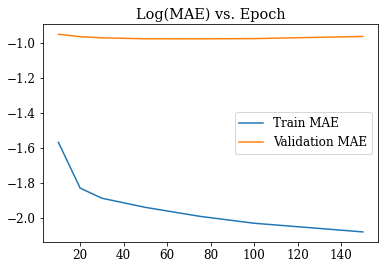

In [23]:
import glob
history_files = sorted(glob.glob('History/history_gainerr_model_pretrained_on_thnoise_model*'))
file_nums = []
for file in history_files:
    file_num = file.strip('History/history_gainerr_model_pretrained_on_thnoise_model_').strip('.csv')
    file_nums.append(int(file_num))
zipped = zip(file_nums, history_files)
sorted_zip = sorted(zipped)
file_nums, history_files = zip(*sorted_zip)
print(file_nums)
epochs = []
train_loss = []
val_loss = []
for i in range(len(history_files)):
    history_file = history_files[i]
    epochs.append(file_nums[i])
    file = open(history_file)
    csv_reader = csv.reader(file, delimiter=',')
    for i, row in enumerate(csv_reader):
        if i == 0:
            train_loss.append(float((list(row)[1].strip('[]'))))
        if i == 3:
            val_loss.append(float((list(row)[1].strip('[]'))))
 
print(train_loss)
print(val_loss)

plt.figure()
plt.plot(epochs, np.log10(train_loss), label="Train MAE")
plt.plot(epochs, np.log10(val_loss), label="Validation MAE")
plt.legend()
plt.title('Log(MAE) vs. Epoch')
plt.show()

In [5]:
# Store indices of 100 random black hole images
bh_idx_100 = [1916,1210,825,973,796,1004,1145,2275,1090,2215,1300,2473,509,2374,2105,154,2134,2891,787,1107,1851,1375,214,1100,198,2988,1376,573,2338,1324,156,1860,2688,1113,1614,339,2616,1349,341,755,191,1471,2130,2971,1687,2625,2855,1493,544,884,881,953,2834,2321,1743,1189,400,2153,1080,1977,1314,1900,2091,405,1659,2759,199,2719,878,1884,2119,49,2197,2467,21,216,2259,2989,2205,666,2221,1260,1943,1585,587,926,2833,2120,225,1680,223,1144,2554,2243,618,602,715,2300,2035,615]
fashion_idx_100 = [866,1245,5873,669,5903,633,6334,4586,5588,1485,1760,5323,4950,1163,4305,3641,5609,865,6112,5304,87,5362,5111,1114,5992,4920,3985,400,6397,345,6532,266,2143,1669,1711,1133,6281,3280,1577,3727,220,2699,2760,5524,2752,42,515,628,4621,250,6644,2795,5430,863,4132,6944,2823,6487,6657,5143,3895,1322,6432,2933,1019,1862,5045,1822,5153,3219,962,5650,54,4651,4763,6236,3043,1796,6083,3978,555,3744,1367,4888,2465,2596,4182,5015,4356,3130,2992,6246,4604,6431,2081,3383,2367,947,5420,5614]
mnist_idx_100 = [7057,8965,7647,8640,9293,9483,9718,8064,8810,8805,8530,7297,9089,7434,7869,7188,8403,8363,7602,9563,8421,7068,9700,8305,9635,7740,9589,9771,8104,8374,7986,7233,8584,8302,9914,7729,9620,7376,9336,7617,8287,9778,8137,9800,9400,7352,7240,8212,7347,9863,9770,9093,9120,7343,7215,8299,7767,7219,9574,7558,7351,8058,8650,8950,7362,7328,7391,8110,8347,8086,8794,9757,9393,8725,9987,9263,9225,9449,8367,8422,7040,9560,8187,9825,8750,7544,9366,8683,7160,9007,7712,7507,8657,9951,8760,9854,9975,7423,9829,8482]

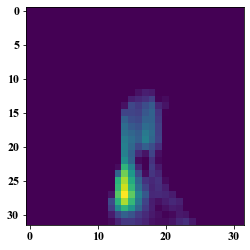

In [44]:
filename = 'Images/gainerr_model/fashion_idx_866_gainerr.npy'
img = np.load(filename)

plt.imshow(img.reshape(32, 32))
plt.show()

In [42]:
idx = 1916
#[7445,2408,888,4085,1049,2934,8249,4899,2592,9220,821,2729,5473,9993,5438,9402,1206,1550,9249,2980,4898,4193,2250,5300,7084,3059,1017,2458,8050,9490,565,660,6903,646,8096,7057,8233,507,7651,5394,7150,2918,3222,4616,5248,3668,449,3606,3936,9463,6899,5020,9453,4843,2162,3894,7708,8760,2895,2218,4625,4007,2909,5198,5447,480,4337,7827,8175,1914,685,6069,6851,9018,3963,3554,5527,4373
#[1916,1210,825,973,796,1004,1145,2275,1090,2215,1300,2473,509,2374,2105,154,2134,2891,787,1107,1851,1375,214,1100,198,2988,1376,573,2338,1324,156,1860,2688,1113,1614,339,2616,1349,341,755,191,1471,2130,2971,1687,2625,2855,1493,544,884,881,953,2834,2321,1743,1189,400,2153,1080,1977,1314,1900,2091,405,1659,2759,199,2719,878,1884,2119,49,2197,2467,21,216,2259,2989,2205,666,2221,1260,1943,1585,587,926,2833,2120,225,1680,223,1144,2554,2243,618,602,715,2300,2035,615]
dataset = 'bh_data'
xdata = get_data(dataset)
target = xdata[idx]
plt.imshow(target.reshape(32, 32))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Johanna/Desktop/Neural Network/bh_sim_data.npy'

In [41]:
indices = [7445,2408,888,4085,1049,2934,8249,4899,2592,9220,821,2729,5473,9993,5438,9402,1206,1550,9249,2980,4898,4193,2250,5300,7084,3059,1017,2458,8050,9490,565,660,6903,646,8096,7057,8233,507,7651,5394,7150,2918,3222,4616,5248,3668,449,3606,3936,9463,6899,5020,9453,4843,2162,3894,7708,8760,2895,2218,4625,4007,2909,5198,5447,480,4337,7827,8175,1914,685,6069,6851,9018,3963,3554,5527,4373,6030,7856,8659,2298,7711,4069,3023,7561,2206,9373,2336,1863,1778,94,9893,9231,808,6272,5530,1521,5607,9977]
indices = [1916,1210,825,973,796,1004,1145,2275,1090,2215,1300,2473,509,2374,2105,154,2134,2891,787,1107,1851,1375,214,1100,198,2988,1376,573,2338,1324,156,1860,2688,1113,1614,339,2616,1349,341,755,191,1471,2130,2971,1687,2625,2855,1493,544,884,881,953,2834,2321,1743,1189,400,2153,1080,1977,1314,1900,2091,405,1659,2759,199,2719,878,1884,2119,49,2197,2467,21,216,2259,2989,2205,666,2221,1260,1943,1585,587,926,2833,2120,225,1680,223,1144,2554,2243,618,602,715,2300,2035,615]

print(indices[94])

618


In [ ]:
# Generate sample image and save to file
X_idx = 8249

save_path = '/Users/Johanna/Desktop/IEEE ICIP/NN Images/No Noise Model/'
#dir_path = 'Complex Visibilities/Images/0chisq_model_blur0.0/'#'Complex Visibilities/Images/Final_Images/nonoise_model/nonoise/'
dir_path = 'Complex Visibilities/Images/Final_Images/nonoise_model/nonoise/'
avg_xc, avg_vis_chisq  = [], []

# Load target image and pre-computed predicted image
X = xdata[X_idx]
pred = np.load(dir_path+dataset+'_idx_'+ str(X_idx) +'_alpha0.npy')
#pred = np.load('Complex Visibilities/Images/Final_Images/nonoise_model/sigma0.3/bh_data_idx1916_sigma0.3.npy')
pred /= np.sum(pred) # Normalize prediction
savefile = save_path + "_" + dataset + "_" + str(X_idx) + "_alpha0.png"
    
# Run test
vis_chisq, cphase_chisq, camp_chisq, recon_mae, pred_blur = run_test(X, pred, fwhm, blur_param=0.5)

pred = pred_blur

plt.imshow(pred.reshape(32, 32))
plt.clim(0, 0.008)
plt.imsave(savefile, pred.reshape(32, 32), vmin=0, vmax=0.008)

print("MAE = ", recon_mae)
print("Vis = ", round(vis_chisq, 4))



Loading uvfits:  obs_train_gainerr_precomputed.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.


<Figure size 432x288 with 0 Axes>

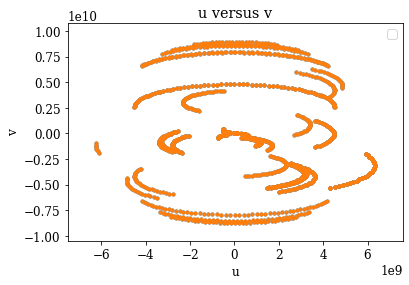

In [38]:
obs = eh.obsdata.load_uvfits('obs_train_gainerr_precomputed.uvfits')

plt.figure()
#plotall(obs, 'uvdist', 'amp', show=True)
plotall(obs, 'u', 'v', show=True)
plt.legend()
plt.show()

#plt.figure()
#plotall(obs, 'uvdist', 'phase', show=True)
#plt.legend()
#plt.show()

In [36]:
!ls

History                              make_prediction_uvfits
Images                               obs2.uvfits
Losses                               obs_nonoise.uvfits
Models                               obs_test_gainerr_precomputed.uvfits
__pycache__                          obs_thnoise.uvfits
augment_xdata.py                     obs_thnoise_precomputed.uvfits
augmented_xdata                      obs_train_gainerr_precomputed.uvfits
data_augmentation.py                 plot_histogram_distributions.ipynb
gainerr_obs_files                    precomputed_visibilities
generate_gainerr_visibilities.py     unet_vis.py
generate_xdata_vis.py                unet_vis_allthree.py
make_prediction.py                   unet_vis_gainerr.py
make_prediction2.py                  unet_vis_precomputed.py
make_prediction2_thnoise_obs         unet_vis_thnoise.py
make_prediction_obs                  visualize_unet_vis.ipynb


In [14]:
''' Load Dataset and Compute Resolution '''
print("Getting dataset..")
dataset = 'fashion'
xdata = get_data(dataset)

target = xdata[0]/np.sum(xdata[0])
obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(target.flatten(), th_noise=False)  # data terms

target = xdata[0]/np.sum(xdata[0])

plt.figure()
x1, uv1, amp1 = plotall(obs, 'uvdist', 'amp', show=True)
plt.legend()
plt.show()

plt.figure()
x1, uv1, amp1 = plotall(obs, 'uvdist', 'phase', show=True)
plt.legend()
plt.show()
    
print("Done.")

Getting dataset..
Generating empty observation file . . . 


KeyboardInterrupt: 

Getting dataset..
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106



No handles with labels found to put in legend.


sigx =  None
sigy =  [0.01062971 0.01062971 0.01100279 ... 0.02178442 0.01988636 0.02200559]


<Figure size 432x288 with 0 Axes>

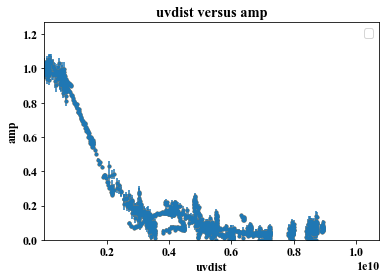

No handles with labels found to put in legend.


sigx =  None
sigy =  [15.35863037 10.77548378 11.69827656 ...  1.20939924 15.64718917
 18.57370285]


<Figure size 432x288 with 0 Axes>

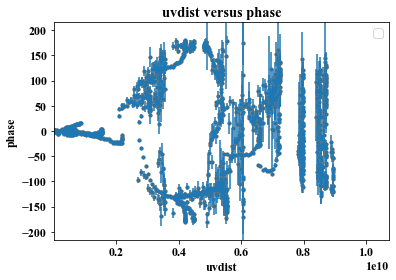

Done.


In [107]:
''' Load Dataset and Compute Resolution '''
print("Getting dataset..")
dataset = 'fashion'
xdata = get_data(dataset)

target = xdata[0]/np.sum(xdata[0])
obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(target.flatten(), th_noise=True)  # data terms
fwhm = obs.res()

plt.figure()
x1, uv1, amp1 = plotall(obs, 'uvdist', 'amp', show=True)
plt.legend()
plt.show()

plt.figure()
x1, uv1, amp1 = plotall(obs, 'uvdist', 'phase', show=True)
plt.legend()
plt.show()
    
print("Done.")

Alpha =  0.0
Test Image  1 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

sigx =  None
sigy =  [0.01062971 0.01062971 0.

<Figure size 432x288 with 0 Axes>

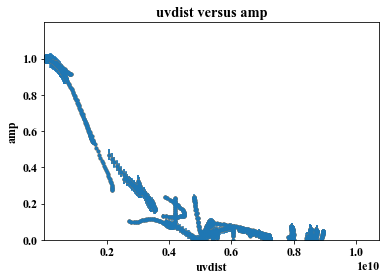

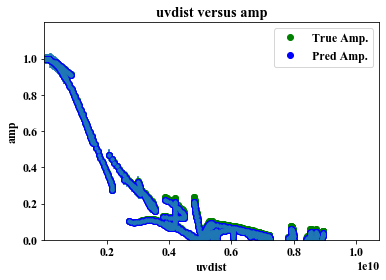

sigx =  None
sigy =  [49.19569948 62.83448915 40.46004092 ...  1.24815532 73.27347688
 81.07634175]
sigx =  None
sigy =  [ 63.01840149  79.6202178   57.29132056 ...   1.24815525 112.63726764
 124.62814808]


<Figure size 432x288 with 0 Axes>

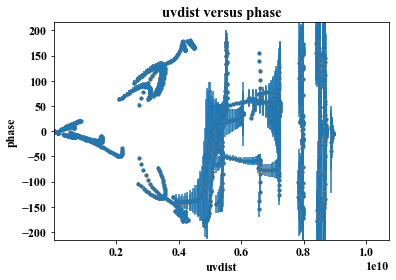

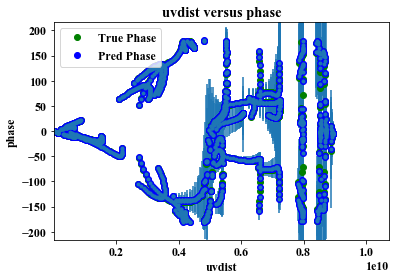

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


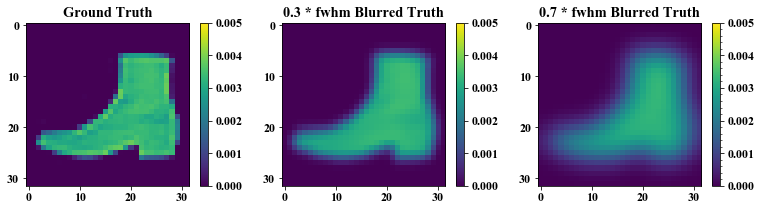

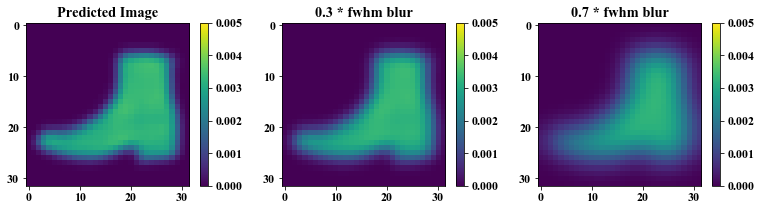

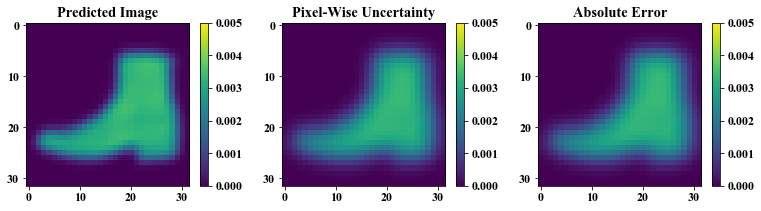

Vis Chi^2 =  3.1611365915
MAE =  5.445397657420833e-05
SSIM =  0.9999889649206067

Test Image  2 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

<Figure size 432x288 with 0 Axes>

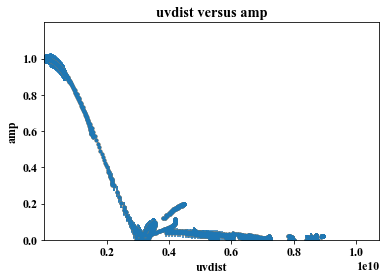

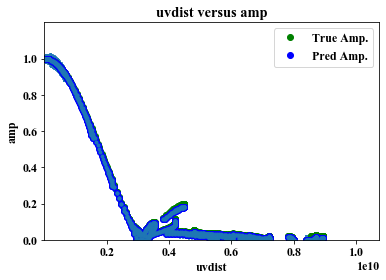

sigx =  None
sigy =  [53.69330286 47.50433022 29.65217337 ...  1.24815532 57.04522565
 63.12435093]
sigx =  None
sigy =  [64.93993906 58.25277432 40.68112804 ...  1.24815531 73.92606011
 81.80500739]


<Figure size 432x288 with 0 Axes>

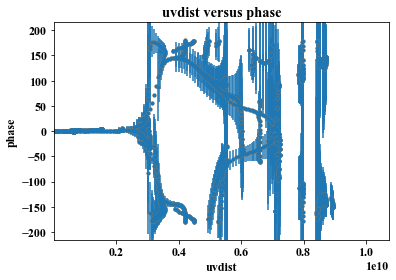

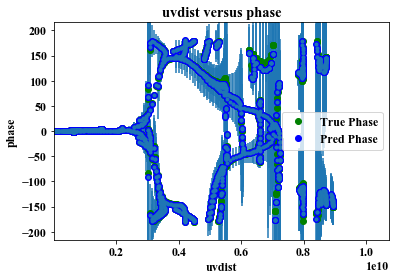

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


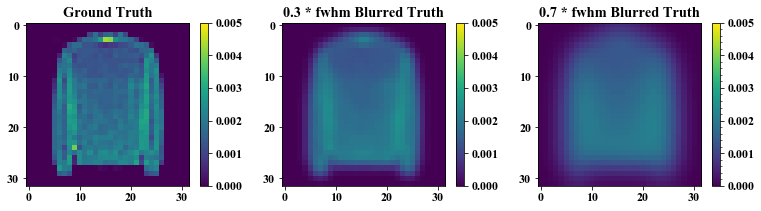

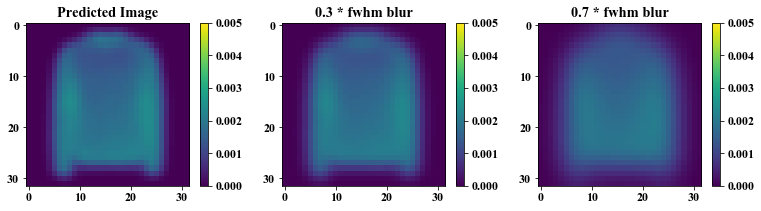

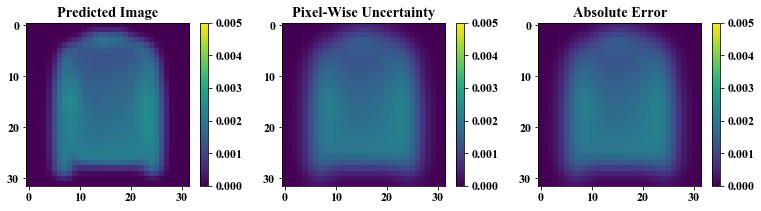

Vis Chi^2 =  1.262607732
MAE =  4.1595161856800394e-05
SSIM =  0.9999958351861351

Test Image  3 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

<Figure size 432x288 with 0 Axes>

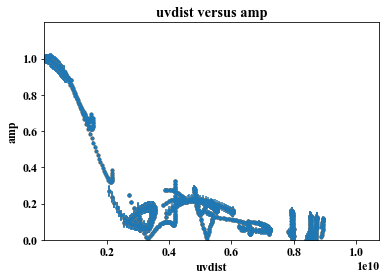

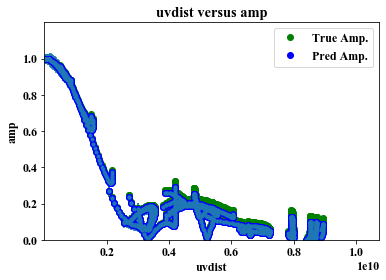

sigx =  None
sigy =  [16.78992657 14.97515689  8.57363691 ...  1.24815532 24.58514478
 27.20696872]
sigx =  None
sigy =  [23.28665903 20.60231464 11.52417066 ...  1.24815529 32.8093344
 36.30836012]


<Figure size 432x288 with 0 Axes>

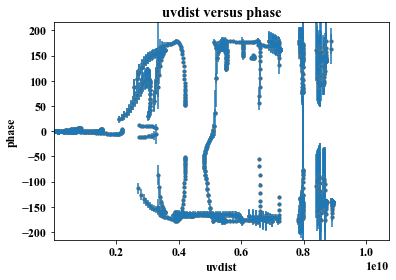

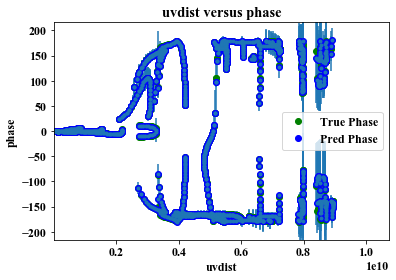

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


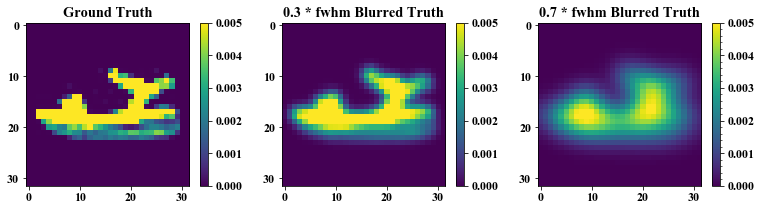

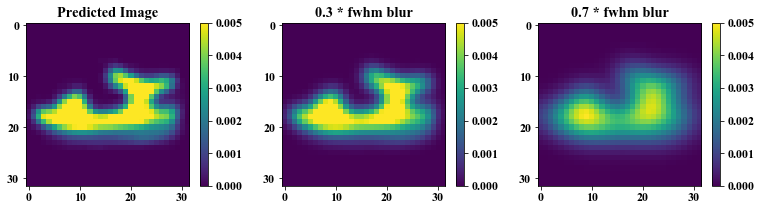

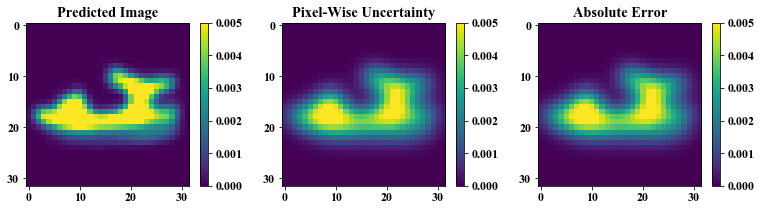

Vis Chi^2 =  9.7433289172
MAE =  8.90924370609687e-05
SSIM =  0.9999586522212038

Test Image  4 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , co

<Figure size 432x288 with 0 Axes>

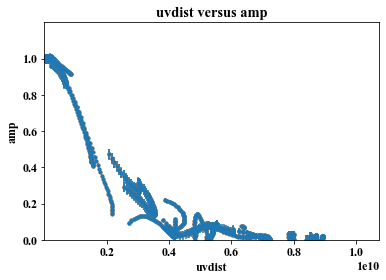

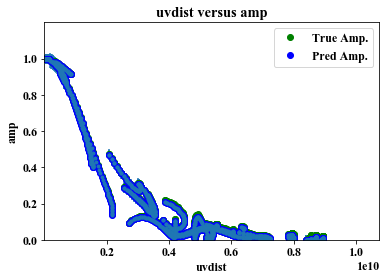

sigx =  None
sigy =  [33.39318685 32.32382344 33.06109723 ...  1.24815532 63.78804855
 70.58379384]
sigx =  None
sigy =  [57.82408214 55.01420365 53.82488235 ...  1.24815529 75.41383697
 83.44784892]


<Figure size 432x288 with 0 Axes>

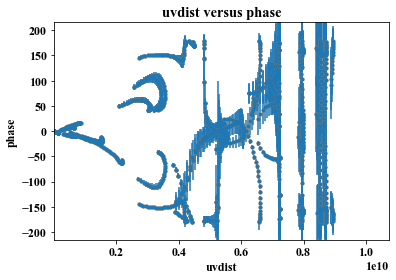

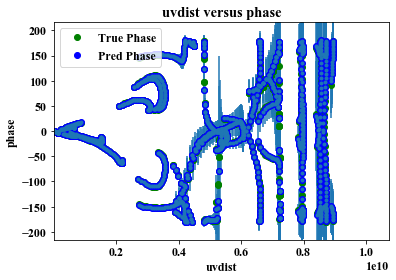

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


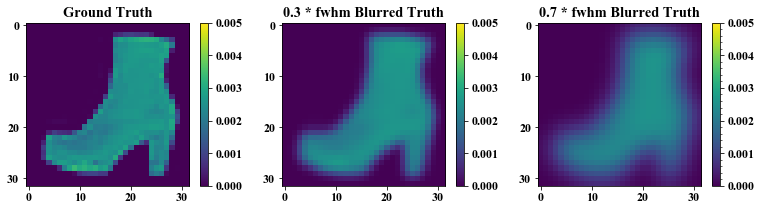

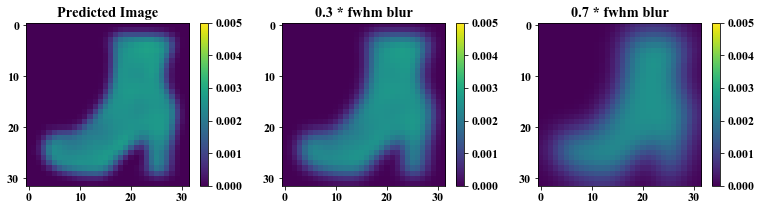

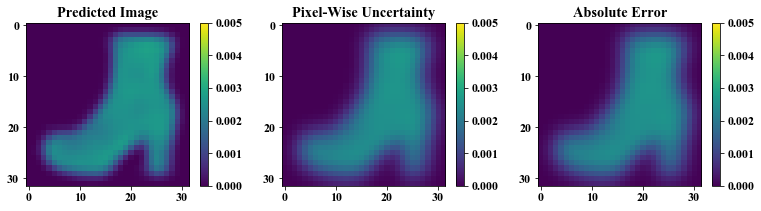

Vis Chi^2 =  1.2380200589
MAE =  4.8168036767715503e-05
SSIM =  0.9999933126152778

Test Image  5 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , 

<Figure size 432x288 with 0 Axes>

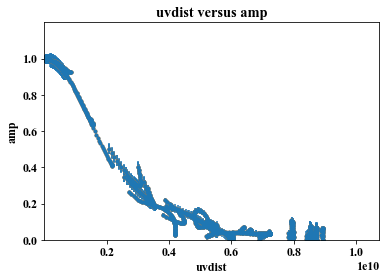

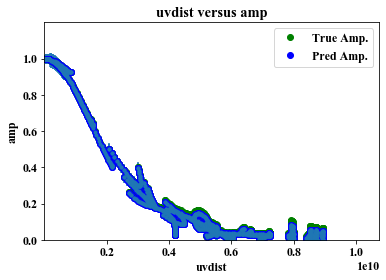

sigx =  None
sigy =  [15.16913348 15.05253753 21.45473754 ...  1.24815532 29.77050537
 32.94225574]
sigx =  None
sigy =  [19.79188186 19.75662094 29.27166028 ...  1.24815535 38.89929426
 43.04365612]


<Figure size 432x288 with 0 Axes>

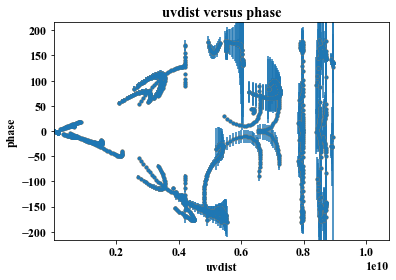

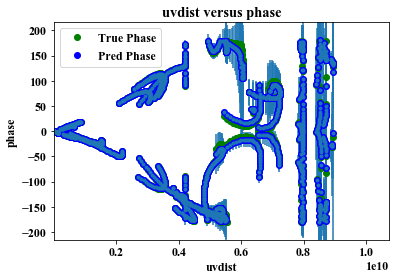

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


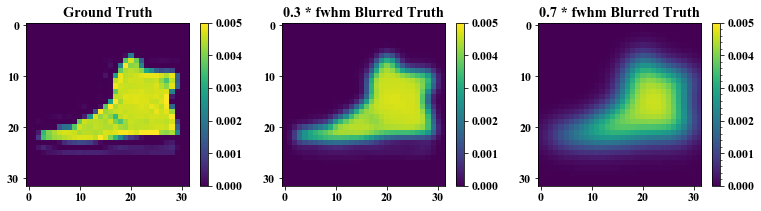

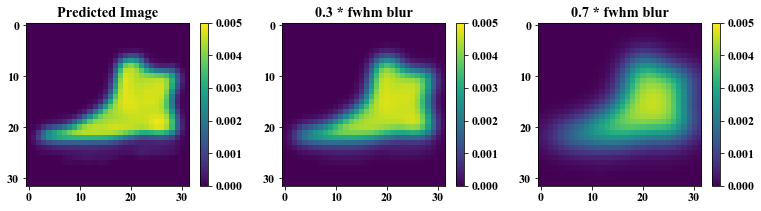

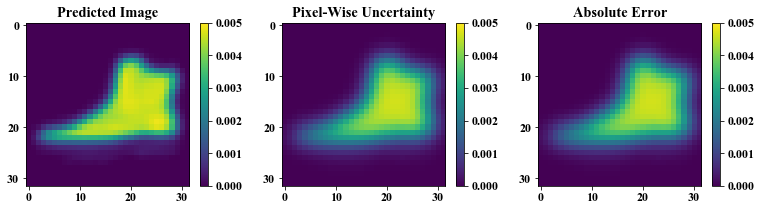

Vis Chi^2 =  3.1711395031
MAE =  5.861223417557314e-05
SSIM =  0.9999842415303831

Test Image  6 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  0.99999994
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis c

<Figure size 432x288 with 0 Axes>

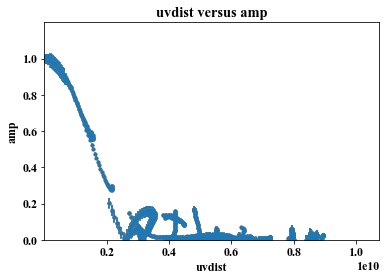

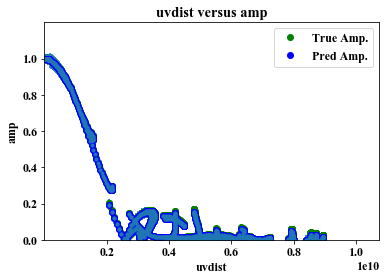

sigx =  None
sigy =  [ 97.3493795  139.35311261  52.46301445 ...   1.24815532 259.59594736
 287.21995277]
sigx =  None
sigy =  [173.44629086 300.80047857  65.84480063 ...   1.24815542 265.01147145
 293.21365021]


<Figure size 432x288 with 0 Axes>

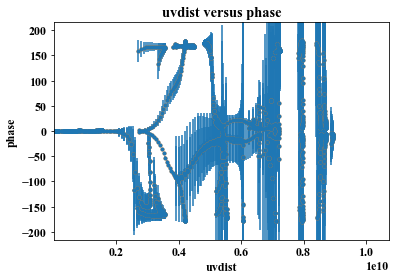

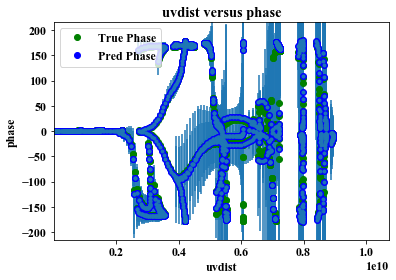

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


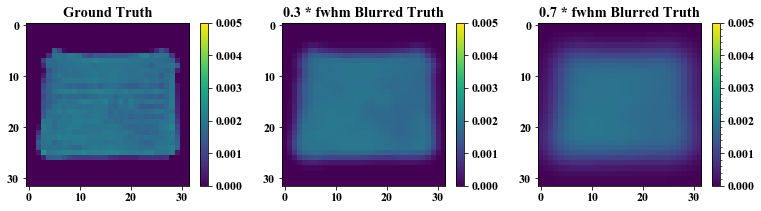

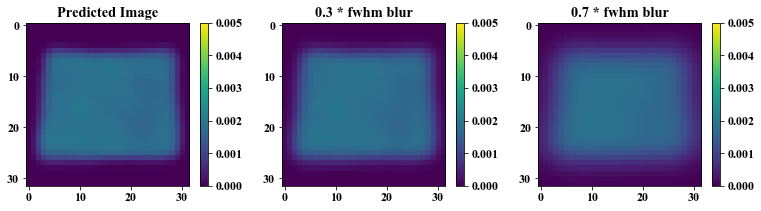

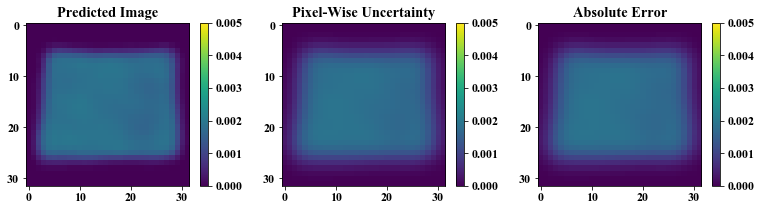

Vis Chi^2 =  0.8158218259
MAE =  4.3294849617963497e-05
SSIM =  0.9999943464514665

Test Image  7 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , 

<Figure size 432x288 with 0 Axes>

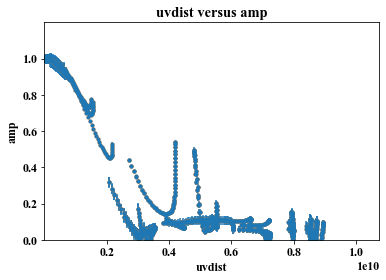

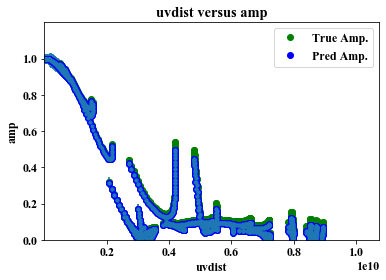

sigx =  None
sigy =  [11.72991828 12.81488502 51.76912906 ...  1.24815532 11.64801344
 12.8892385 ]
sigx =  None
sigy =  [ 15.43567     16.76439506 104.97744609 ...   1.24815539  15.85854411
  17.54849213]


<Figure size 432x288 with 0 Axes>

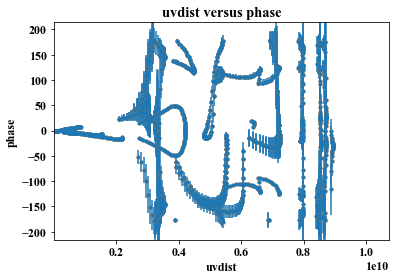

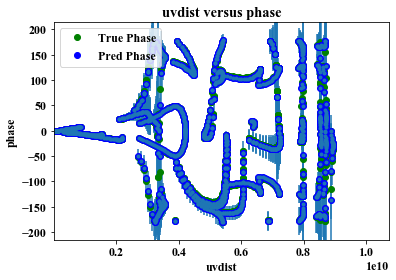

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


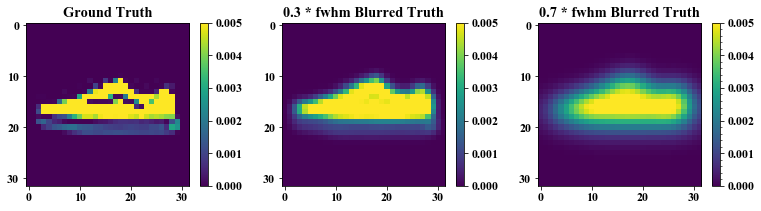

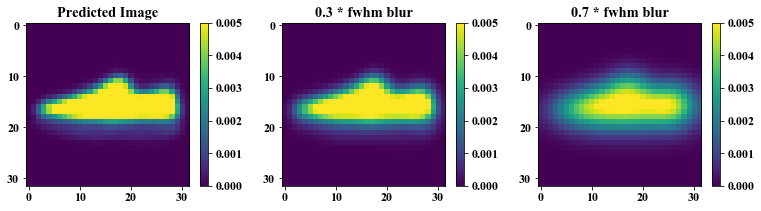

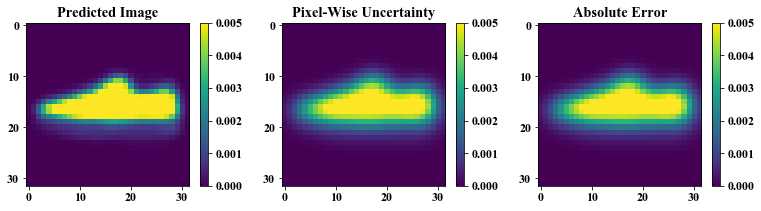

Vis Chi^2 =  18.0436798297
MAE =  9.146205046039031e-05
SSIM =  0.9999464339917628

Test Image  8 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , 

<Figure size 432x288 with 0 Axes>

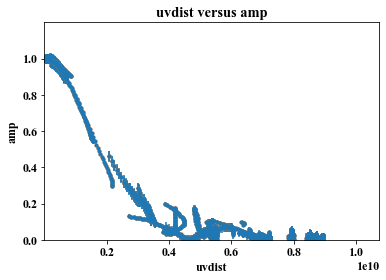

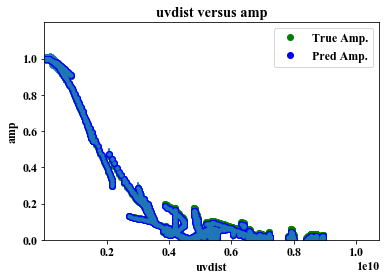

sigx =  None
sigy =  [21.7905075  22.87967859 46.72756909 ...  1.24815532 51.6056554
 57.1013748 ]
sigx =  None
sigy =  [29.3037601  30.65265763 53.59422741 ...  1.24815529 73.71832732
 81.56957461]


<Figure size 432x288 with 0 Axes>

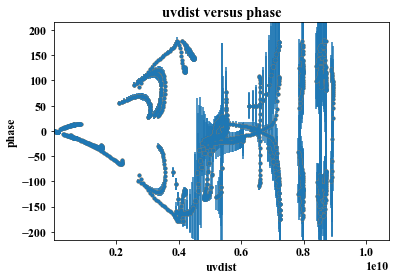

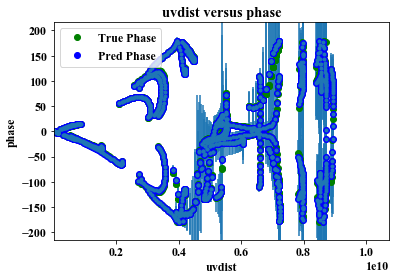

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


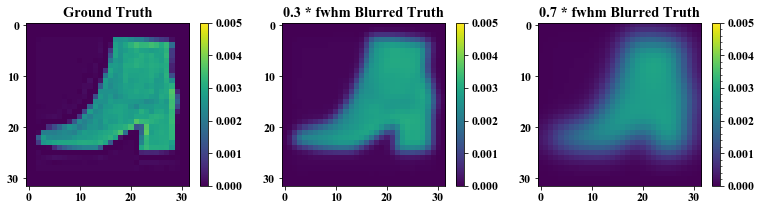

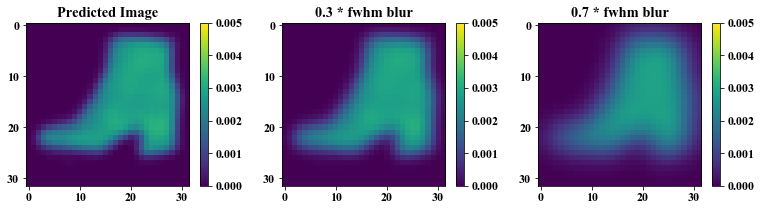

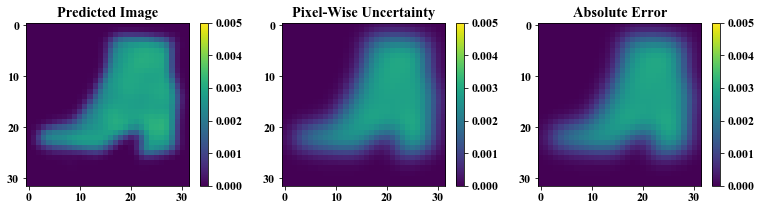

Vis Chi^2 =  1.9157101655
MAE =  5.4675928334069374e-05
SSIM =  0.9999922511281703

Test Image  9 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , 

<Figure size 432x288 with 0 Axes>

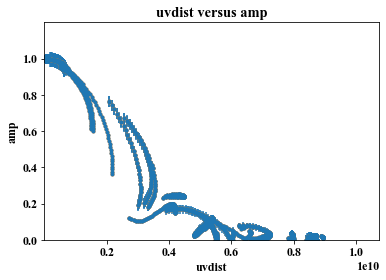

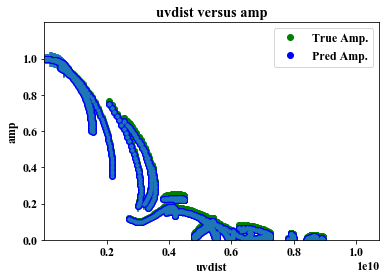

sigx =  None
sigy =  [ 21.15552078  20.84030547  26.88430943 ...   1.24815532 120.99565215
 133.91470962]
sigx =  None
sigy =  [ 27.40988228  27.4036526   42.74491499 ...   1.24815533 168.8096764
 186.82930238]


<Figure size 432x288 with 0 Axes>

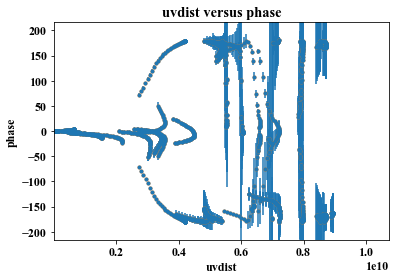

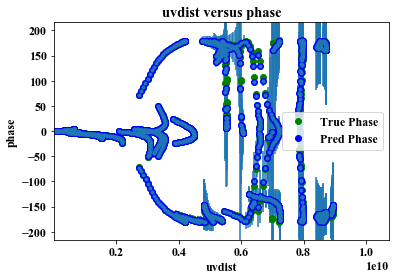

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


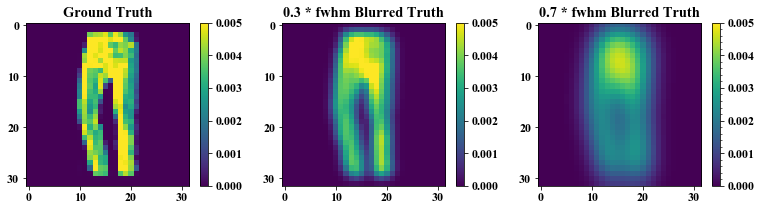

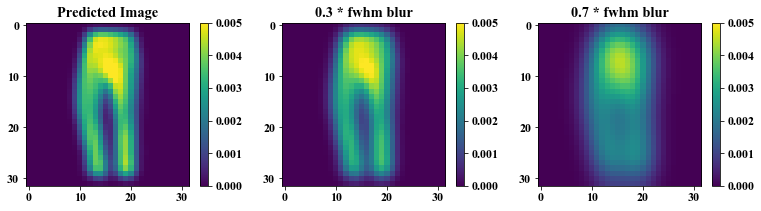

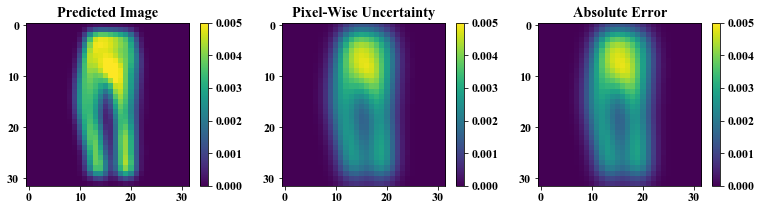

Vis Chi^2 =  5.3340825277
MAE =  8.070051723415654e-05
SSIM =  0.9999854286767843

Test Image  10 / 20 ...
-----------------------------------------------------------
Flux of Target =  0.9999999999999999
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: t

<Figure size 432x288 with 0 Axes>

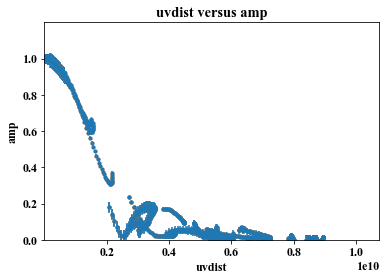

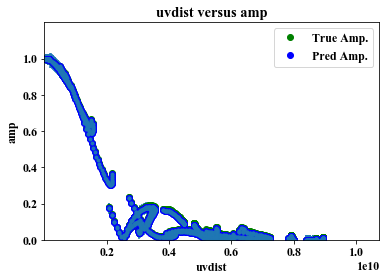

sigx =  None
sigy =  [111.72691607 110.49340981  85.45994147 ...   1.24815532 126.55121437
 140.03320435]
sigx =  None
sigy =  [158.59318711 157.64907174 102.05206077 ...   1.24815539 163.36188017
 180.76624954]


<Figure size 432x288 with 0 Axes>

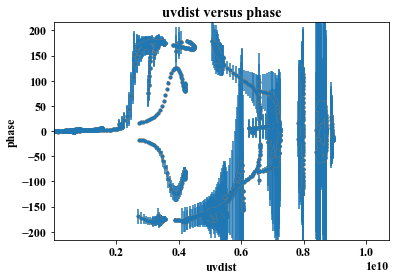

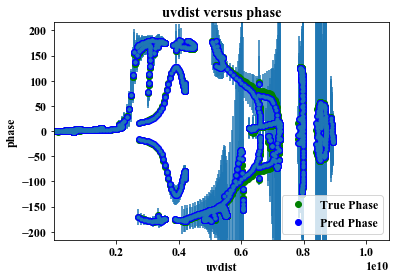

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


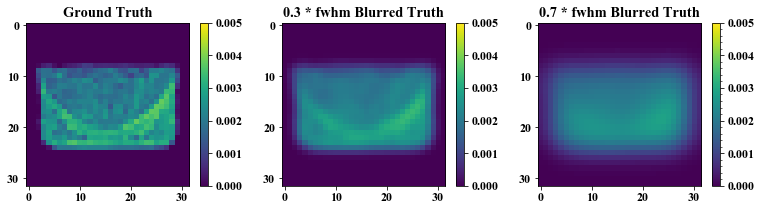

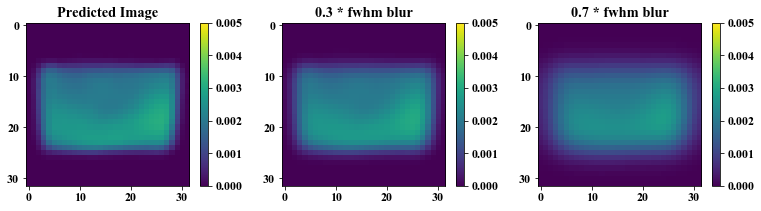

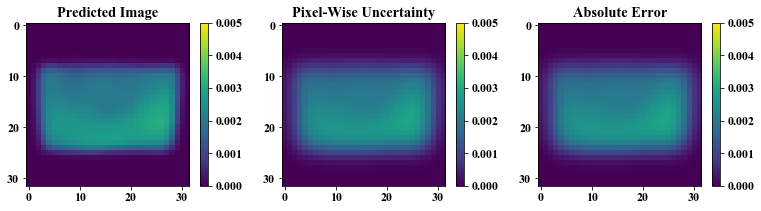

Vis Chi^2 =  1.092797797
MAE =  5.057523636566163e-05
SSIM =  0.9999924877085318

Test Image  11 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

<Figure size 432x288 with 0 Axes>

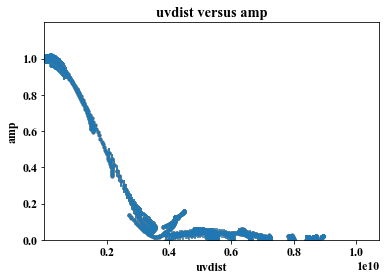

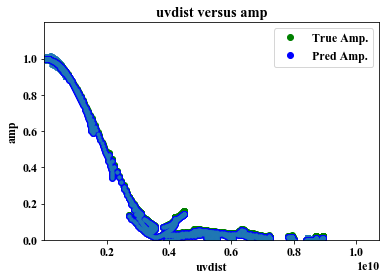

sigx =  None
sigy =  [423.12939084 279.58614254  38.35852488 ...   1.24815532  52.96372819
  58.60635582]
sigx =  None
sigy =  [1.50584833e+03 3.67518618e+02 5.56702909e+01 ... 1.24815531e+00
 6.70687006e+01 7.42149402e+01]


<Figure size 432x288 with 0 Axes>

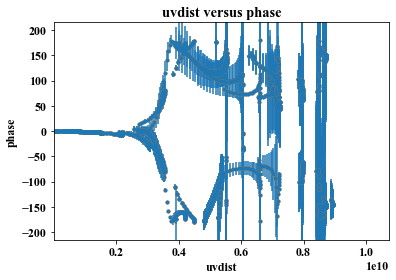

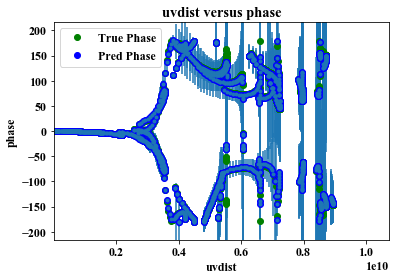

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


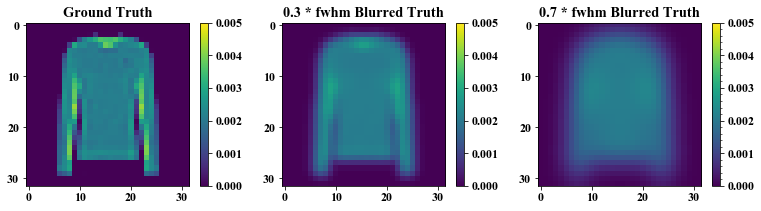

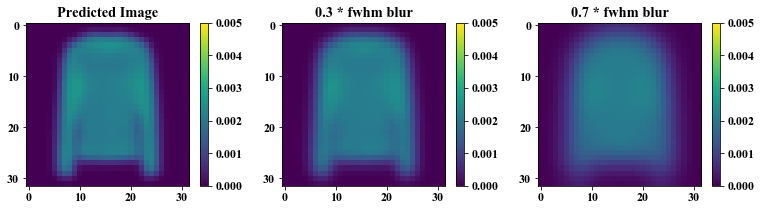

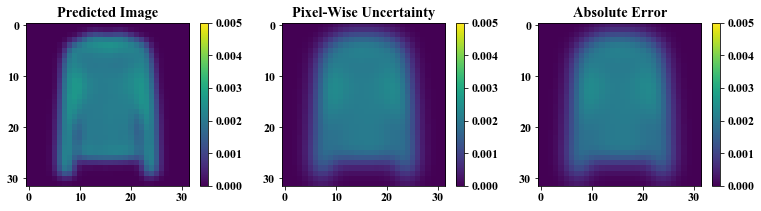

Vis Chi^2 =  1.4919789685
MAE =  4.951804111861134e-05
SSIM =  0.9999945844399556

Test Image  12 / 20 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , 

<Figure size 432x288 with 0 Axes>

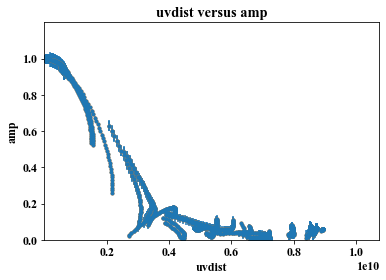

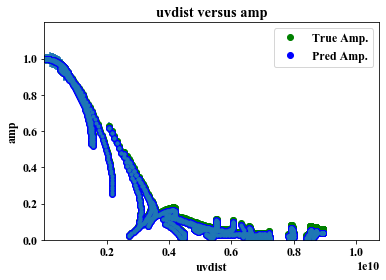

sigx =  None
sigy =  [13.6539869  13.01809887 11.08584111 ...  1.24815532 36.05714504
 39.89859949]
sigx =  None
sigy =  [17.5122473  16.9017     16.10968107 ...  1.24815534 52.99842279
 58.64480461]


<Figure size 432x288 with 0 Axes>

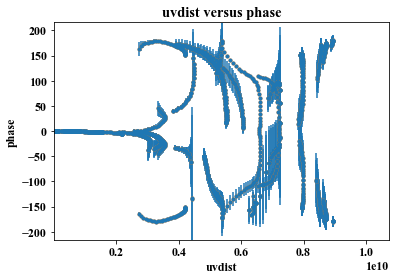

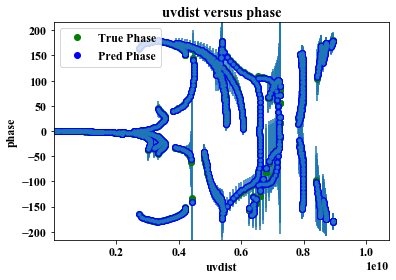

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:328: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


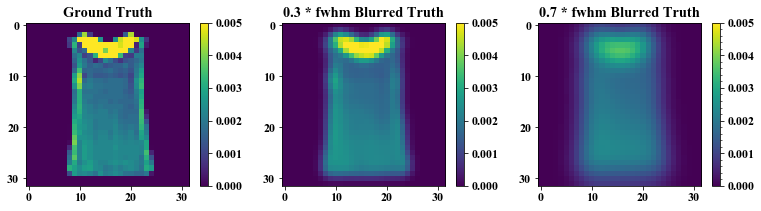

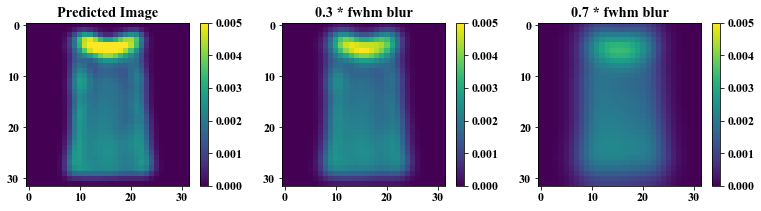

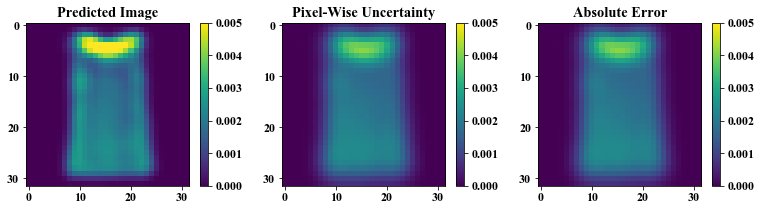

Vis Chi^2 =  4.6009190114
MAE =  6.0732406934397705e-05
SSIM =  0.9999853169288726

Test Image  13 / 20 ...
-----------------------------------------------------------
Flux of Target =  0.9999999999999999
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: 

KeyboardInterrupt: 

In [110]:
# Get test sample from dataset
random_idx = fashion_idx_100[:20]
#random_idx = [9002,9681,9727,9824,9787,9683,9123,9899,9415,9962,9540,9989,9950,9807,9023]

dir_path = 'Complex Visibilities/Images/thnoise_model/'

mae_vals = []
chisq_vals = []
ssim_vals = []
for alpha in np.linspace(0, 10, 10):
    print("Alpha = ", alpha)
    avg_mae, avg_ssim, avg_vis_chisq, avg_cphase_chisq, avg_camp_chisq = [], [], [], [], []
    i = 0
    for idx in random_idx:
        i += 1
        print("Test Image ", i, "/", len(random_idx),"...")
        print('-----------------------------------------------------------')

        target = xdata[idx]
        pred = np.load(dir_path+dataset+'_idx_'+ str(idx) +'alpha_'+str(alpha)+'.npy')
        vis_chisq, cphase_chisq, camp_chisq, recon_mae, recon_ssim, pred = run_test(target, pred, fwhm, blur_param=0.5)
        
        mae_vals.append(recon_mae)
        chisq_vals.append(vis_chisq)
        ssim_vals.append(recon_ssim)
        
        #plt.imshow(pred.reshape(32, 32))
        #plt.show()
        avg_mae.append(recon_mae)
        avg_ssim.append(recon_ssim)
        avg_vis_chisq.append(vis_chisq)
        avg_cphase_chisq.append(cphase_chisq)
        avg_camp_chisq.append(camp_chisq)

    print("Results:")
    print("Avg. MAE = ", np.mean(avg_mae), 4)
    print("Avg. Vis = ", round(np.mean(avg_vis_chisq), 4))
    print("Avg. SSIM = ", np.mean(avg_ssim), 4)
    print("Avg. Cphase = ", round(np.mean(avg_cphase_chisq), 4))
    print("Avg. Camp = ", round(np.mean(avg_camp_chisq), 4))
    
    #mae_vals.append(np.mean(avg_mae))
    #chisq_vals.append(round(np.mean(avg_vis_chisq), 4))

print("MAE Vals = ", mae_vals)
print("Chisq Vals = ", chisq_vals)
print("SSIM Vals = ", chisq_vals)

#plot_hist(mae_vals, chisq_vals, dataset)

In [ ]:
[]

In [ ]:
''' Load Dataset and Compute Resolution '''
print("Getting dataset..")
dataset = 'mnist'
xdata = get_data(dataset)

obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(xdata[0].flatten())  # data terms
fwhm = obs.res()
print("Done.")

In [ ]:
# Get test sample from dataset
random_idx = mnist_idx_100[:20]
#random_idx = [9002,9681,9727,9824,9787,9683,9123,9899,9415,9962,9540,9989,9950,9807,9023]

dir_path = 'Complex Visibilities/Images/thnoise_model/'

mae_vals = []
chisq_vals = []
ssim_vals = []
for alpha in np.linspace(0, 10, 10):
    print("Alpha = ", epoch)
    avg_mae, avg_ssim, avg_vis_chisq, avg_cphase_chisq, avg_camp_chisq = [], [], [], [], []
    i = 0
    for idx in random_idx:
        i += 1
        print("Test Image ", i, "/", len(random_idx),"...")
        print('-----------------------------------------------------------')

        target = xdata[idx]
        pred = np.load(dir_path+dataset+'_idx_'+ str(idx) +'alpha_'+str(alpha)+'.npy')
        vis_chisq, cphase_chisq, camp_chisq, recon_mae, recon_ssim, pred = run_test(target, pred, fwhm, blur_param=0.5)
        
        mae_vals.append(recon_mae)
        chisq_vals.append(vis_chisq)
        ssim_vals.append(recon_ssim)
        
        #plt.imshow(pred.reshape(32, 32))
        #plt.show()
        avg_mae.append(recon_mae)
        avg_ssim.append(recon_ssim)
        avg_vis_chisq.append(vis_chisq)
        avg_cphase_chisq.append(cphase_chisq)
        avg_camp_chisq.append(camp_chisq)

    print("Results:")
    print("Avg. MAE = ", np.mean(avg_mae), 4)
    print("Avg. Vis = ", round(np.mean(avg_vis_chisq), 4))
    print("Avg. SSIM = ", np.mean(avg_ssim), 4)
    print("Avg. Cphase = ", round(np.mean(avg_cphase_chisq), 4))
    print("Avg. Camp = ", round(np.mean(avg_camp_chisq), 4))
    
    #mae_vals.append(np.mean(avg_mae))
    #chisq_vals.append(round(np.mean(avg_vis_chisq), 4))

print("MAE Vals = ", mae_vals)
print("Chisq Vals = ", chisq_vals)
print("SSIM Vals = ", chisq_vals)

#plot_hist(mae_vals, chisq_vals, dataset)

In [ ]:
# Thermal noise
mnist_mae = [0.00013431530108234743]
mnist_vis = [20.4757]

# gainp
mnist_mae=[0.00015619328893451423, 0.00016848210752947105,0.00015490959919427634]
mnist_vis = [31.7125, 38.0218, 29.1443]

# gain offset
mnist_mae=[0.0001684821075294710,0.0002304883570760894,0.00029255396887296816]
mnist_vis = [38.0218, 98.4835,259.6377]




In [71]:
''' Load Dataset and Compute Resolution '''
print("Getting dataset..")
dataset = 'bh_data'
xdata = get_data(dataset)

obs, visibility, cphase, camp, F_vis, F_cphase, F_camp, sigma_vis, sigma_cphase, sigma_camp, t1, t2 = get_measurements(xdata[0].flatten())  # data terms
fwhm = obs.res()
print("Done.")

Getting dataset..
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Done.


Alpha =  0.0
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

sigx =  None
sigy =  [0.01062971 0.01062971 0.0

<Figure size 432x288 with 0 Axes>

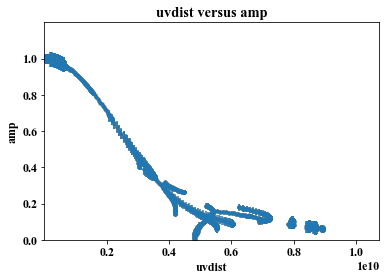

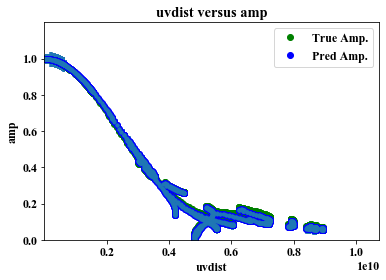

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [ 9.67380355  9.72715034 11.31884583 ...  1.2481553  15.90748876
 17.60267955]


<Figure size 432x288 with 0 Axes>

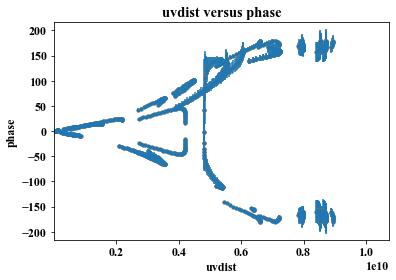

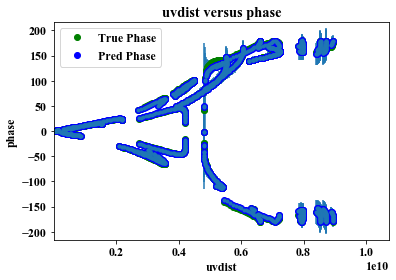

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


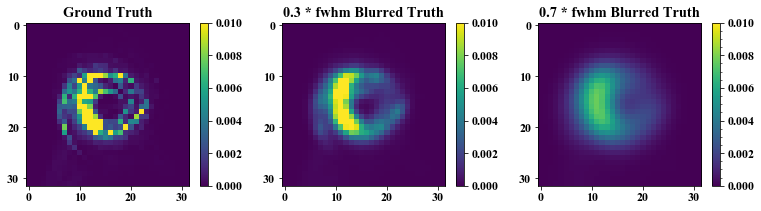

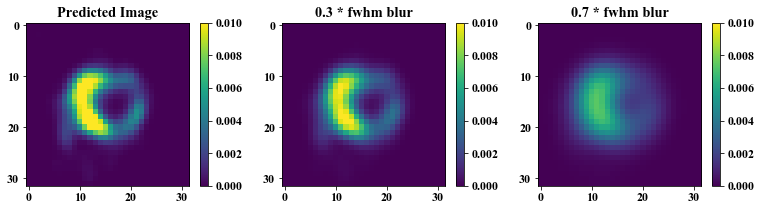

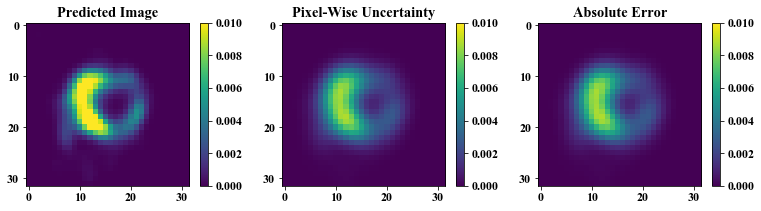

Vis Chi^2 =  2.4425203313
MAE =  9.18923694826792e-05
SSIM =  0.9999756221779909

Results:
Avg. MAE =  9.18923694826792e-05 4
Avg. Vis =  2.4425
Avg. SSIM =  0.9999756221779909 4
Avg. Cphase =  0.3604
Avg. Camp =  3.7188
Alpha =  1.1111111111111112
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting

<Figure size 432x288 with 0 Axes>

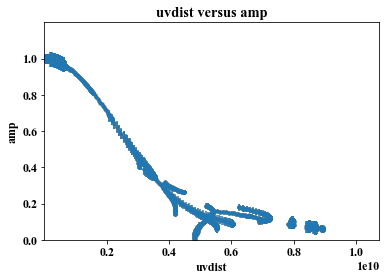

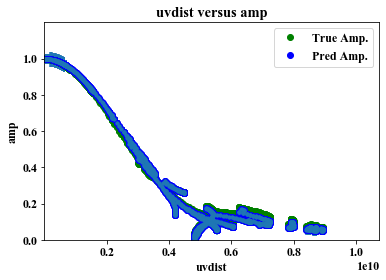

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [10.65531978 10.71676447 12.38030855 ...  1.24815534 17.07700212
 18.89684508]


<Figure size 432x288 with 0 Axes>

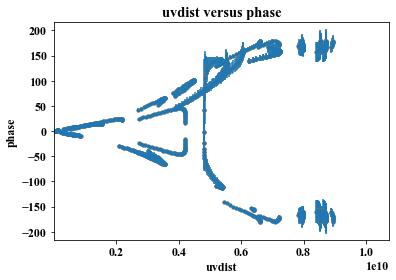

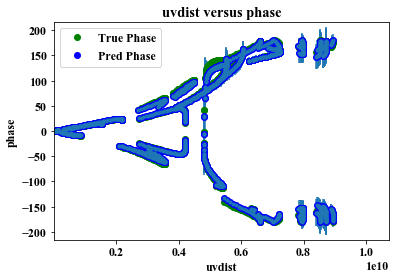

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


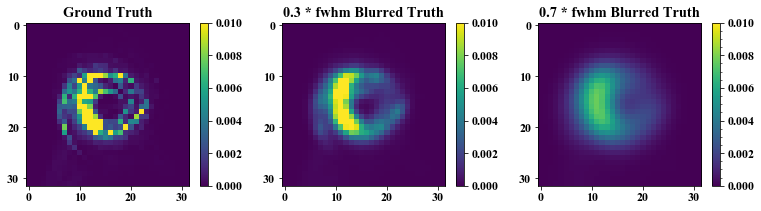

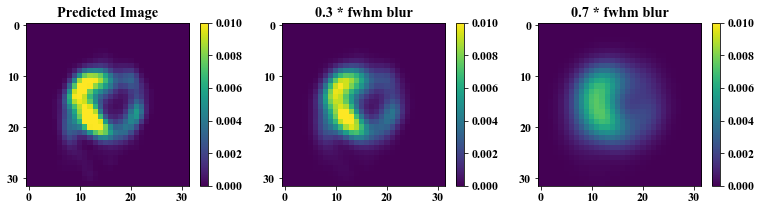

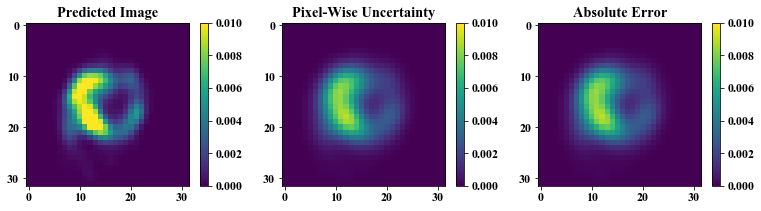

Vis Chi^2 =  3.53981353
MAE =  0.00011334174148389621
SSIM =  0.9999558442977511

Results:
Avg. MAE =  0.00011334174148389621 4
Avg. Vis =  3.5398
Avg. SSIM =  0.9999558442977511 4
Avg. Cphase =  1.441
Avg. Camp =  6.0533
Alpha =  2.2222222222222223
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Gettin

<Figure size 432x288 with 0 Axes>

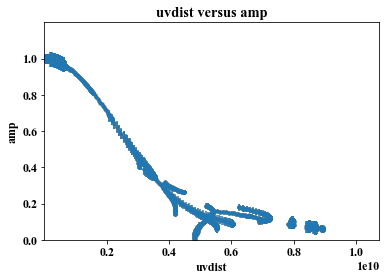

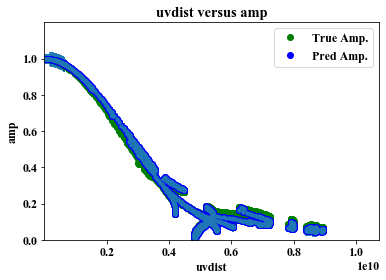

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [11.86638908 11.91999494 13.5553394  ...  1.24815535 16.86077877
 18.65760089]


<Figure size 432x288 with 0 Axes>

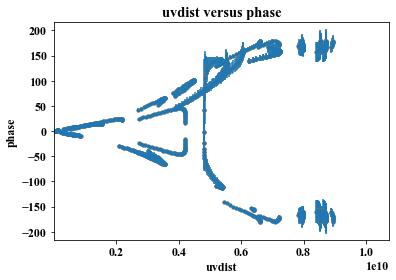

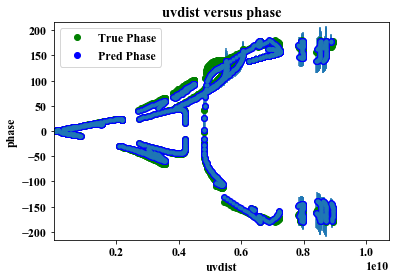

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


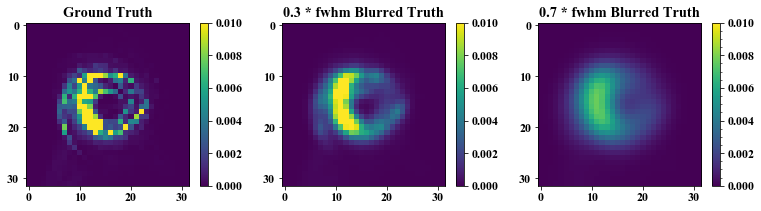

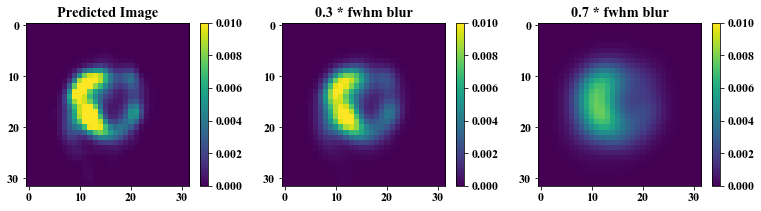

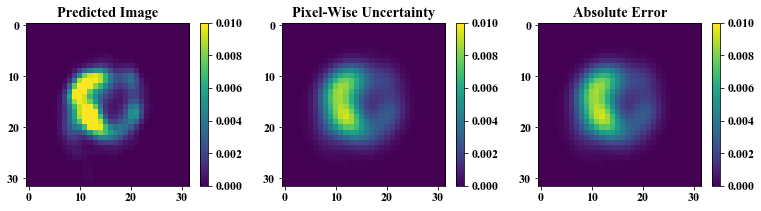

Vis Chi^2 =  5.3381408661
MAE =  0.00012821458377071333
SSIM =  0.9999266114263019

Results:
Avg. MAE =  0.00012821458377071333 4
Avg. Vis =  5.3381
Avg. SSIM =  0.9999266114263019 4
Avg. Cphase =  4.0126
Avg. Camp =  7.4004
Alpha =  3.3333333333333335
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Get

<Figure size 432x288 with 0 Axes>

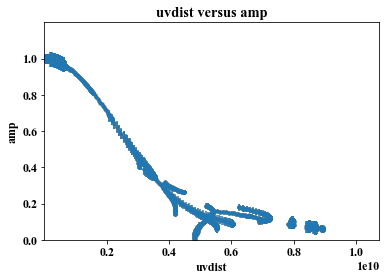

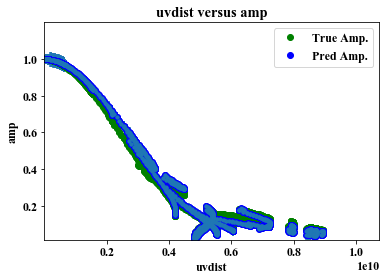

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [13.3640099  13.38517154 14.73111483 ...  1.24815532 15.95110095
 17.65097804]


<Figure size 432x288 with 0 Axes>

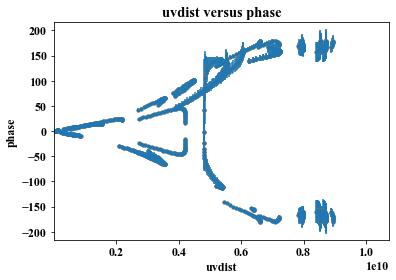

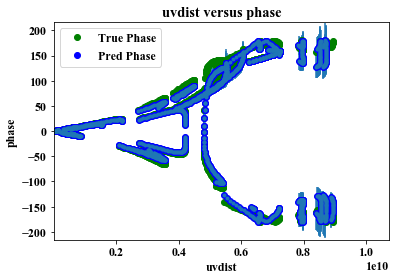

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


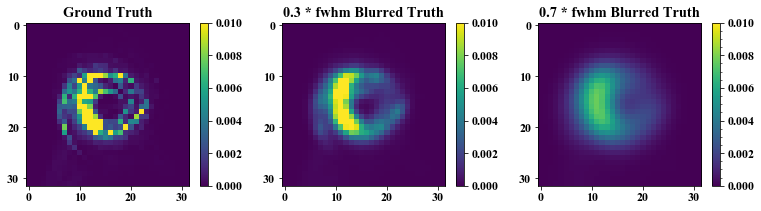

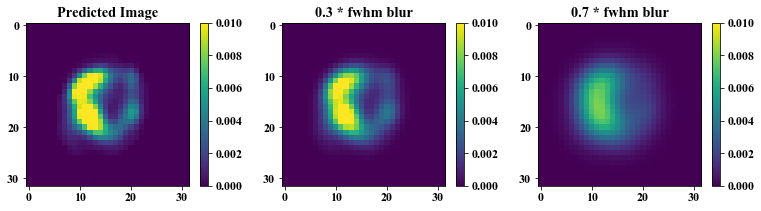

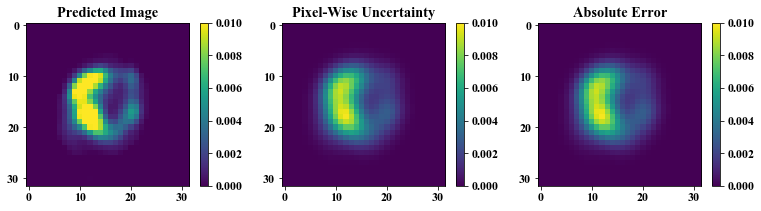

Vis Chi^2 =  10.6801116057
MAE =  0.00015555317653158688
SSIM =  0.9998691506436446

Results:
Avg. MAE =  0.00015555317653158688 4
Avg. Vis =  10.6801
Avg. SSIM =  0.9998691506436446 4
Avg. Cphase =  8.0171
Avg. Camp =  10.0336
Alpha =  4.444444444444445
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
G

<Figure size 432x288 with 0 Axes>

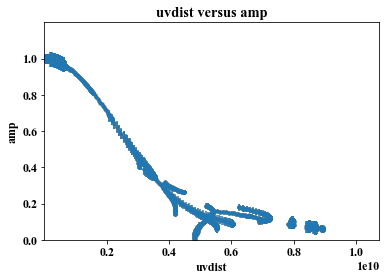

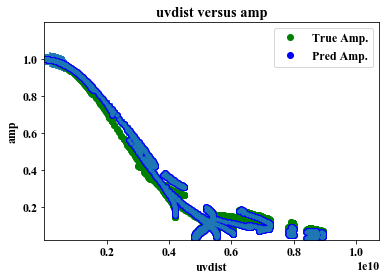

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [15.7636467  15.81578092 17.52312642 ...  1.2481553  16.16894491
 17.89202693]


<Figure size 432x288 with 0 Axes>

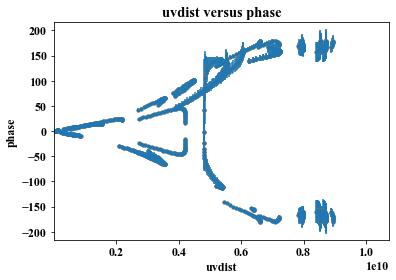

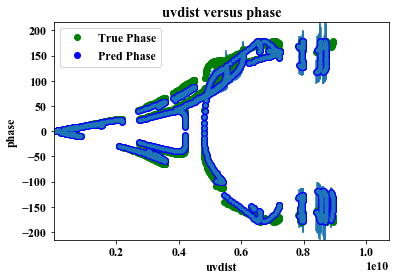

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


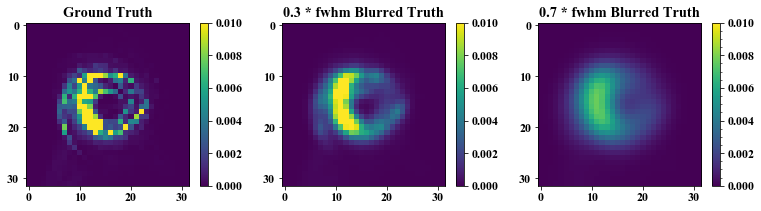

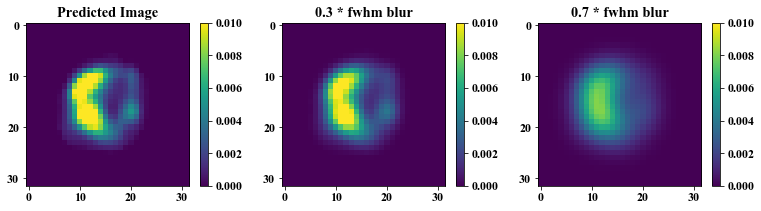

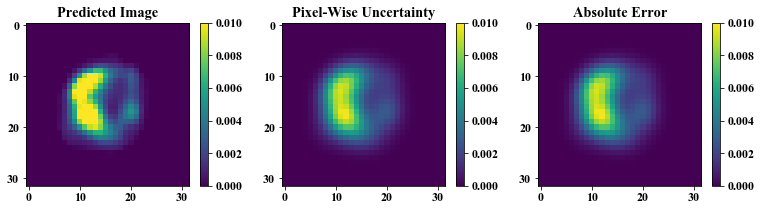

Vis Chi^2 =  17.4673858697
MAE =  0.00018534972009696677
SSIM =  0.999799377809311

Results:
Avg. MAE =  0.00018534972009696677 4
Avg. Vis =  17.4674
Avg. SSIM =  0.999799377809311 4
Avg. Cphase =  11.9403
Avg. Camp =  15.8839
Alpha =  5.555555555555555
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0000001
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities

<Figure size 432x288 with 0 Axes>

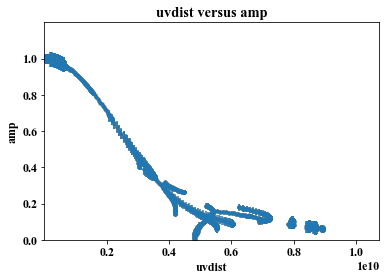

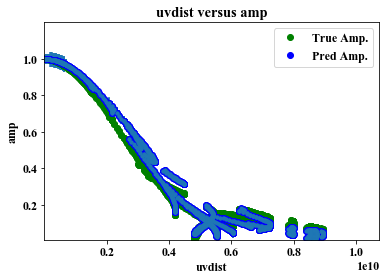

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [19.79414186 19.89926557 22.33507717 ...  1.24815523 17.29517282
 19.13826635]


<Figure size 432x288 with 0 Axes>

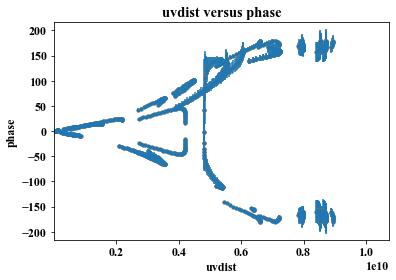

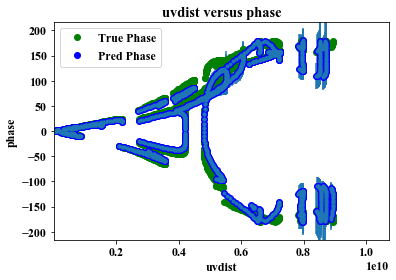

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


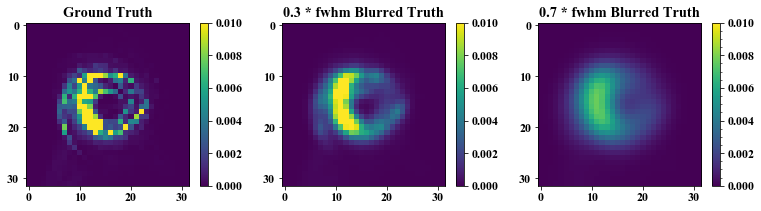

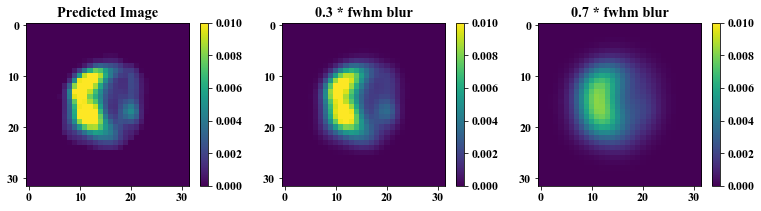

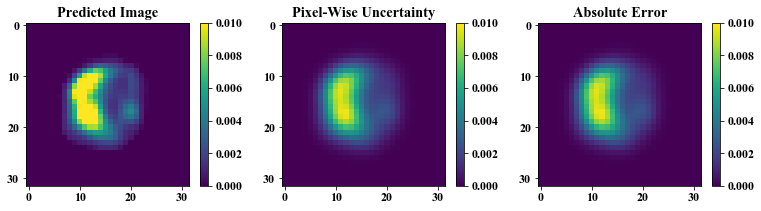

Vis Chi^2 =  26.3149948239
MAE =  0.00021323998829351262
SSIM =  0.9997190949432138

Results:
Avg. MAE =  0.00021323998829351262 4
Avg. Vis =  26.315
Avg. SSIM =  0.9997190949432138 4
Avg. Cphase =  17.4921
Avg. Camp =  28.4517
Alpha =  6.666666666666667
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
G

<Figure size 432x288 with 0 Axes>

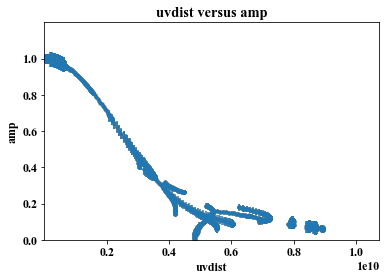

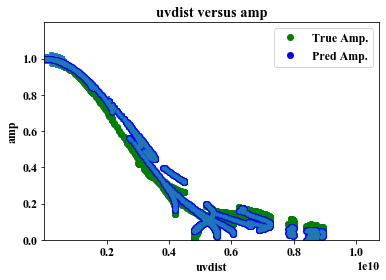

sigx =  None
sigy =  [ 9.26537083  9.34542376 11.06549724 ...  1.24815532 13.01137716
 14.39807911]
sigx =  None
sigy =  [28.06829738 28.25196364 31.87071716 ...  1.2481553  19.33196373
 21.39213573]


<Figure size 432x288 with 0 Axes>

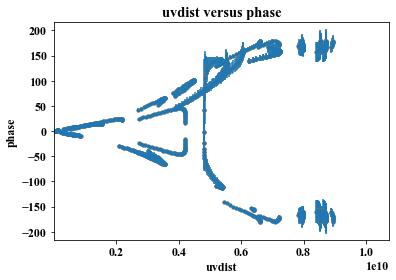

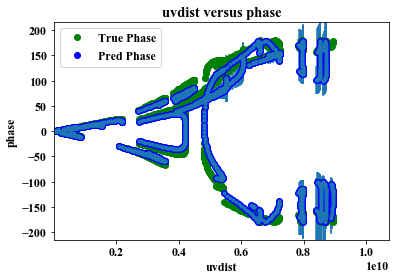

Using pre-computed cphase table in cphase chi^2!
Getting closure amps:: type vis camp , count min, scan 106/106



/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


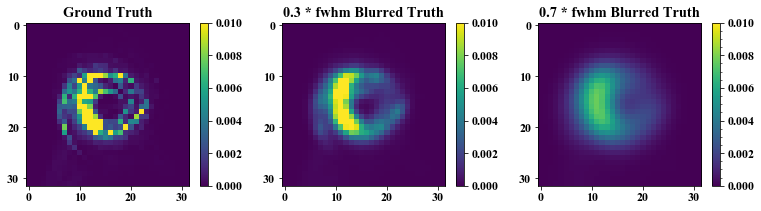

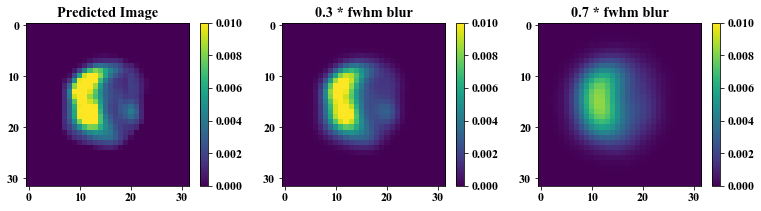

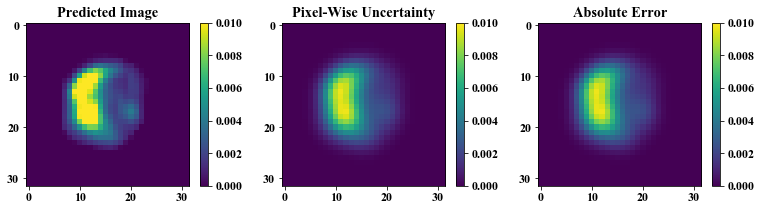

Vis Chi^2 =  36.6833694999
MAE =  0.00023705817851284785
SSIM =  0.999630750749194

Results:
Avg. MAE =  0.00023705817851284785 4
Avg. Vis =  36.6834
Avg. SSIM =  0.999630750749194 4
Avg. Cphase =  22.9272
Avg. Camp =  54.8079
Alpha =  7.777777777777779
Test Image  1 / 1 ...
-----------------------------------------------------------
Flux of Target =  1.0
Flux of Pred =  1.0000001
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 


KeyboardInterrupt: 

In [74]:
# Get test sample from dataset

#random_idx = [2006,1006,1731,2828,2791,687,2127,2903,1419,1965,44,2993,954,2811,1027]
# Get test sample from dataset
random_idx = bh_idx_100[:20][:1]
#random_idx = [9002,9681,9727,9824,9787,9683,9123,9899,9415,9962,9540,9989,9950,9807,9023]

dir_path = 'Complex Visibilities/Images/thnoise_model/'

mae_vals = []
chisq_vals = []
ssim_vals = []
for alpha in np.linspace(0, 10, 10):
    print("Alpha = ", alpha)
    avg_mae, avg_ssim, avg_vis_chisq, avg_cphase_chisq, avg_camp_chisq = [], [], [], [], []
    i = 0
    for idx in random_idx:
        i += 1
        print("Test Image ", i, "/", len(random_idx),"...")
        print('-----------------------------------------------------------')

        target = xdata[idx]
        pred = np.load(dir_path+dataset+'_idx_'+ str(idx) +'alpha_'+str(alpha)+'.npy')
        vis_chisq, cphase_chisq, camp_chisq, recon_mae, recon_ssim, pred = run_test(target, pred, fwhm, blur_param=0.5)
        
        mae_vals.append(recon_mae)
        chisq_vals.append(vis_chisq)
        ssim_vals.append(recon_ssim)
        
        #plt.imshow(pred.reshape(32, 32))
        #plt.show()
        avg_mae.append(recon_mae)
        avg_ssim.append(recon_ssim)
        avg_vis_chisq.append(vis_chisq)
        avg_cphase_chisq.append(cphase_chisq)
        avg_camp_chisq.append(camp_chisq)

    print("Results:")
    print("Avg. MAE = ", np.mean(avg_mae), 4)
    print("Avg. Vis = ", round(np.mean(avg_vis_chisq), 4))
    print("Avg. SSIM = ", np.mean(avg_ssim), 4)
    print("Avg. Cphase = ", round(np.mean(avg_cphase_chisq), 4))
    print("Avg. Camp = ", round(np.mean(avg_camp_chisq), 4))
    
    #mae_vals.append(np.mean(avg_mae))
    #chisq_vals.append(round(np.mean(avg_vis_chisq), 4))

print("MAE Vals = ", mae_vals)
print("Chisq Vals = ", chisq_vals)
print("SSIM Vals = ", chisq_vals)

#plot_hist(mae_vals, chisq_vals, dataset)


In [ ]:
# thermal noise
bh_mae = [9.409318425399257e-05, 0.00010820724274246718, 0.00016486707155235943]
bh_vis = [4.4158, 6.6441, 15.4468]

# gainp
bh_mae = [0.00017064163130704778,0.00016863906173403054,0.00015246437094055867]
bh_vis = [34.4182, 27.335, 18.2761]

# gain offset
0.00017064, 0.0002606988
113.1456

Getting dataset...
-----------------------------------------------------------
-------------------  alpha =  1  ---------------------------
-----------------------------------------------------------
Test Image  1006 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
upda

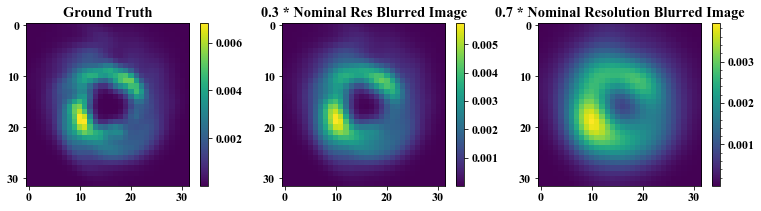

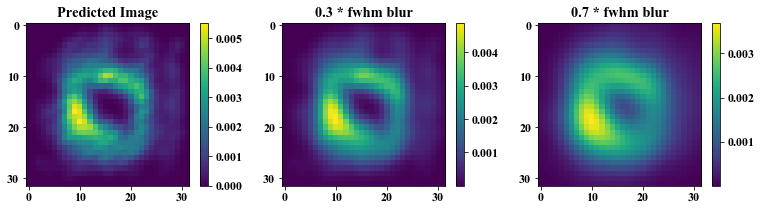

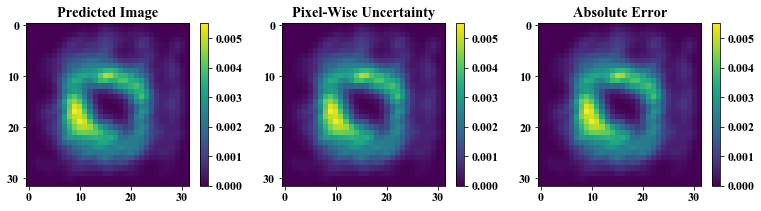

Vis Chi^2 =  5.7815521856
Cphase Chi^2 =  0.5837
Camp Chi^2 =  1.0293
XC =  0.9742
5.7815521856
0.5837
1.0293
0.9742

Test Image  2685 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

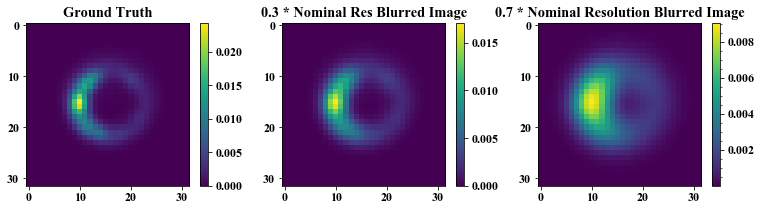

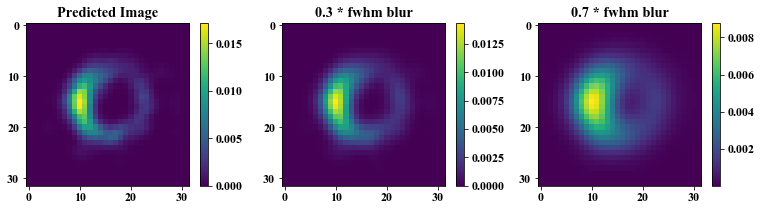

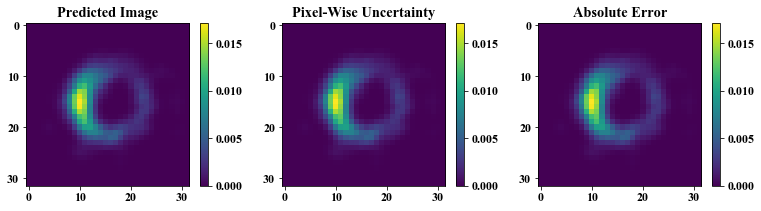

Vis Chi^2 =  21.4687140832
Cphase Chi^2 =  5.2892
Camp Chi^2 =  3.7864
XC =  0.9761
21.4687140832
5.2892
3.7864
0.9761

Test Image  1731 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

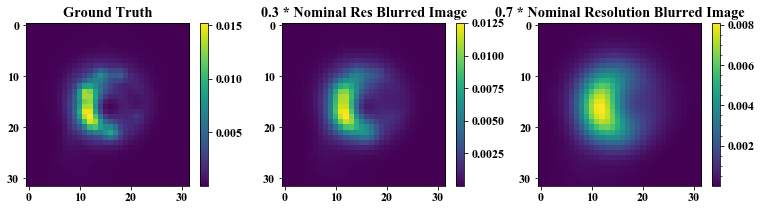

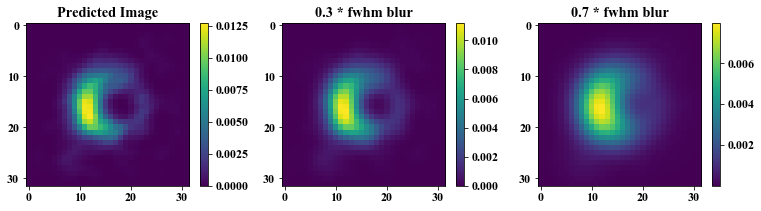

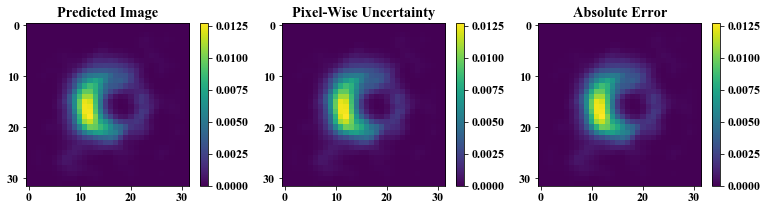

Vis Chi^2 =  3.9498342738
Cphase Chi^2 =  1.0042
Camp Chi^2 =  0.951
XC =  0.984
3.9498342738
1.0042
0.951
0.984

Test Image  2828 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

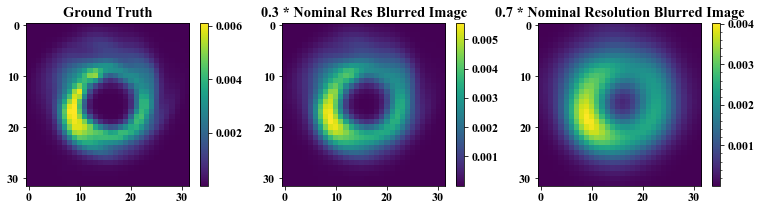

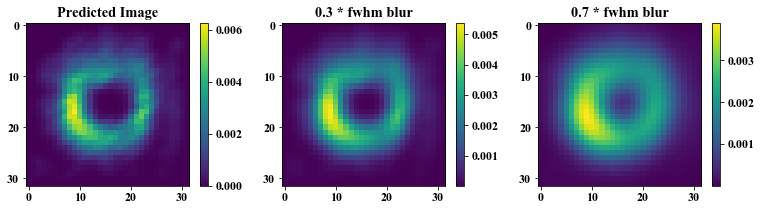

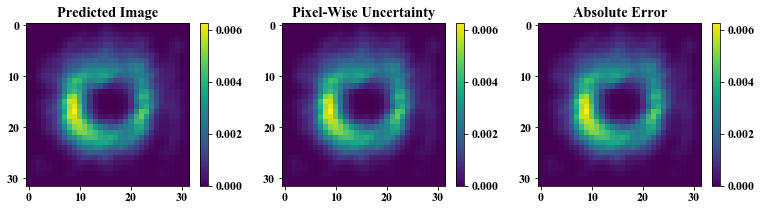

Vis Chi^2 =  4.2032055392
Cphase Chi^2 =  0.2772
Camp Chi^2 =  2.8572
XC =  0.985
4.2032055392
0.2772
2.8572
0.985

Test Image  2791 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

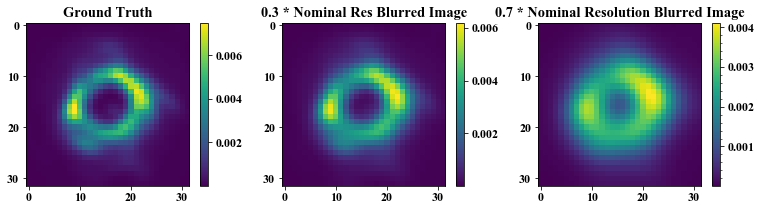

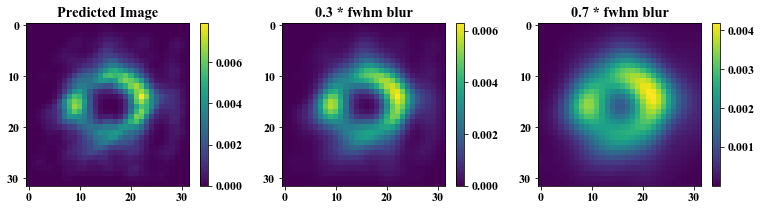

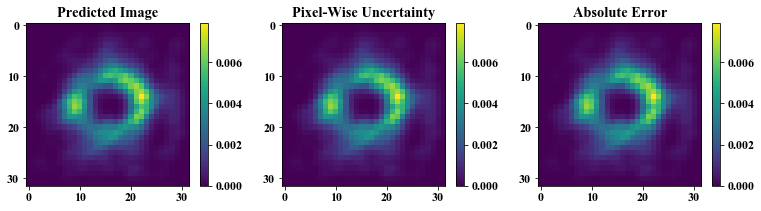

Vis Chi^2 =  32.381227669
Cphase Chi^2 =  24.2824
Camp Chi^2 =  4.619
XC =  0.9769
32.381227669
24.2824
4.619
0.9769

Test Image  687 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

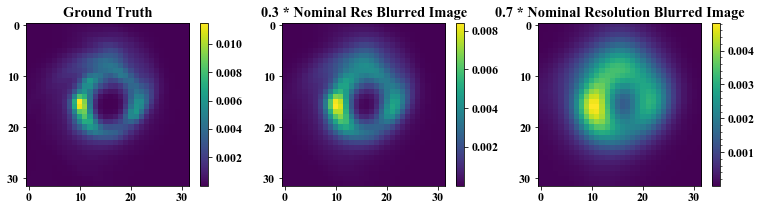

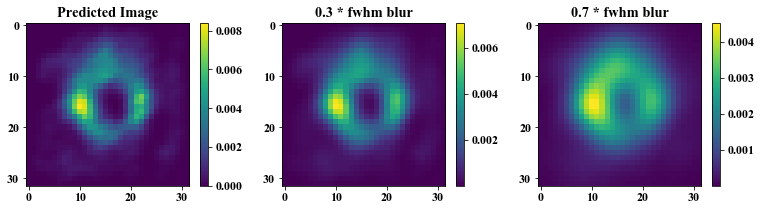

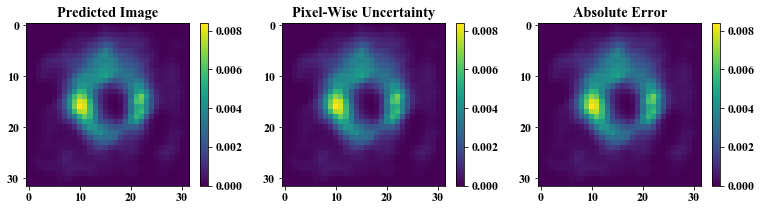

Vis Chi^2 =  30.7338100115
Cphase Chi^2 =  18.7099
Camp Chi^2 =  36.976
XC =  0.9677
30.7338100115
18.7099
36.976
0.9677

Test Image  2127 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

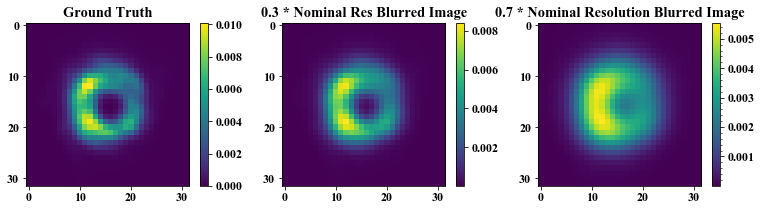

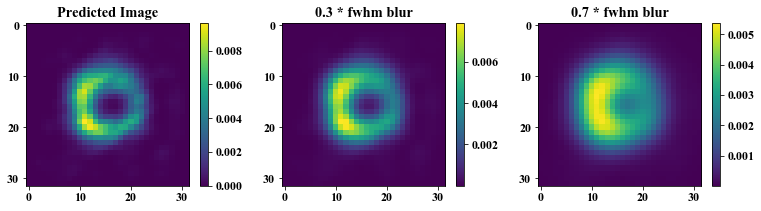

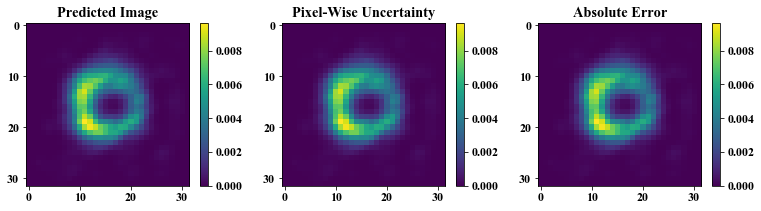

Vis Chi^2 =  2.1429999052
Cphase Chi^2 =  1.0819
Camp Chi^2 =  0.39
XC =  0.9905
2.1429999052
1.0819
0.39
0.9905

Test Image  2903 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

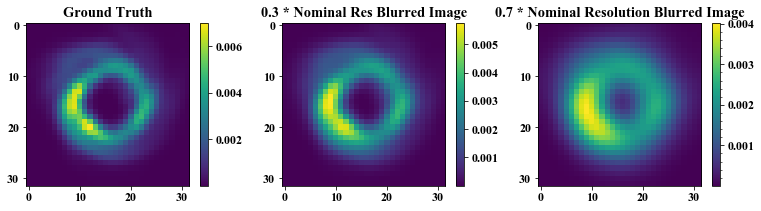

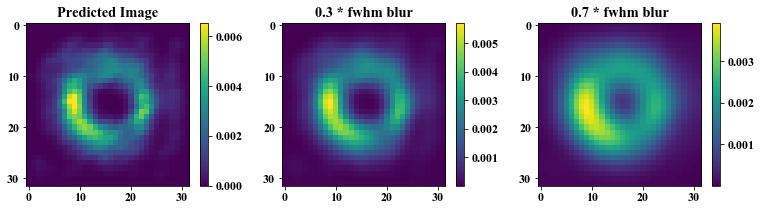

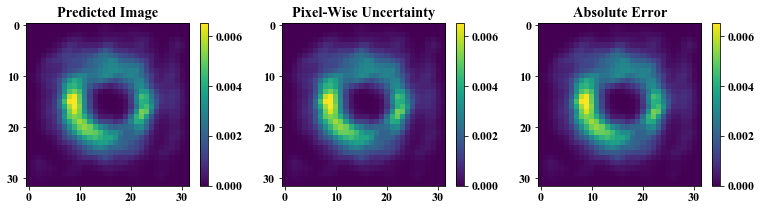

Vis Chi^2 =  5.2150809241
Cphase Chi^2 =  0.185
Camp Chi^2 =  1.4814
XC =  0.9804
5.2150809241
0.185
1.4814
0.9804

Test Image  1419 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

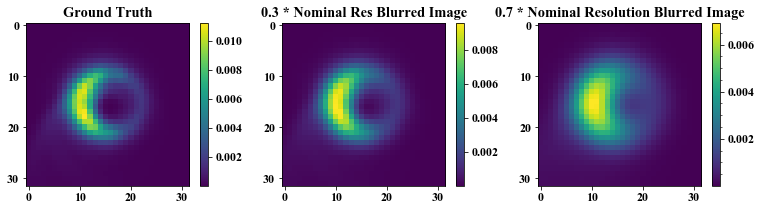

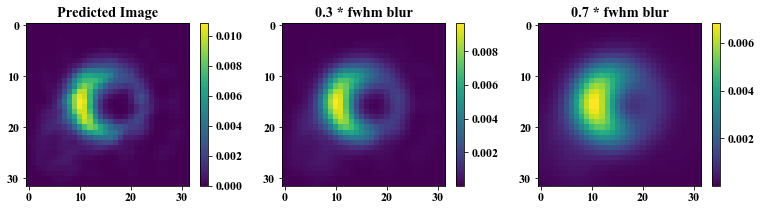

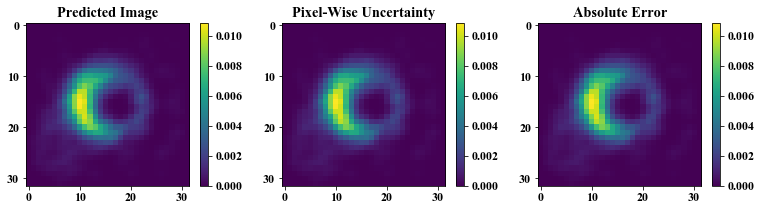

Vis Chi^2 =  3.9528016759
Cphase Chi^2 =  0.5482
Camp Chi^2 =  0.8399
XC =  0.9939
3.9528016759
0.5482
0.8399
0.9939

Test Image  1966 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

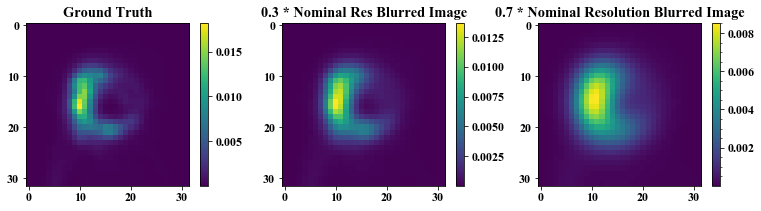

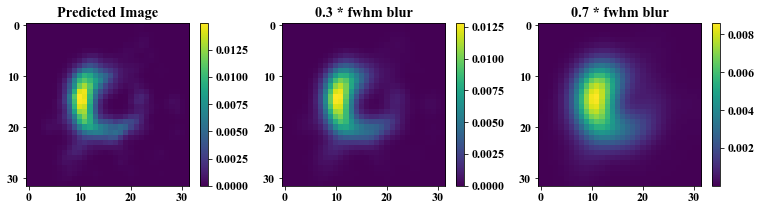

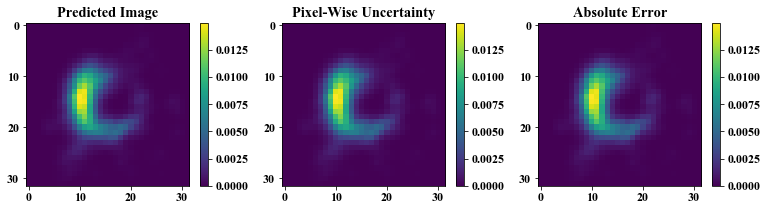

Vis Chi^2 =  8.3222114874
Cphase Chi^2 =  6.1741
Camp Chi^2 =  1.4397
XC =  0.9881
8.3222114874
6.1741
1.4397
0.9881

Test Image  44 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

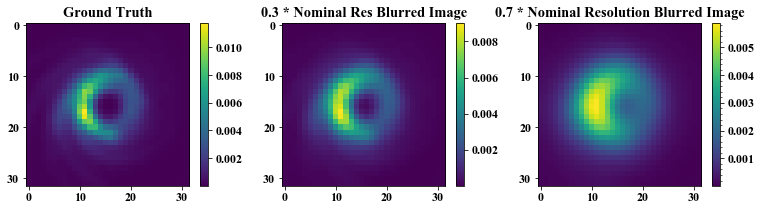

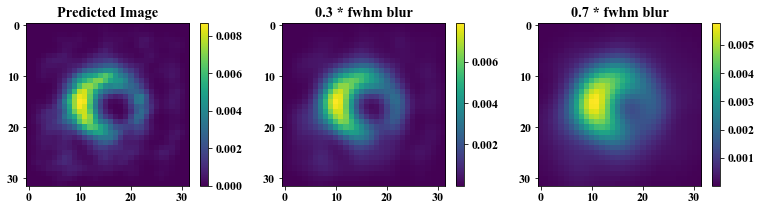

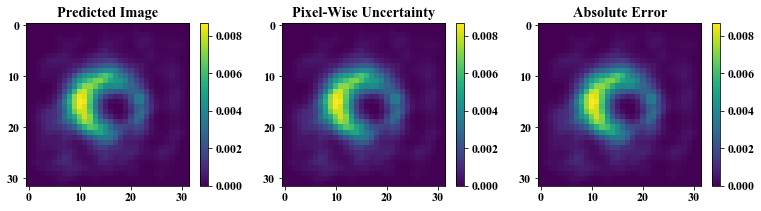

Vis Chi^2 =  45.356454166
Cphase Chi^2 =  42.3554
Camp Chi^2 =  6.1138
XC =  0.9708
45.356454166
42.3554
6.1138
0.9708

Test Image  2993 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

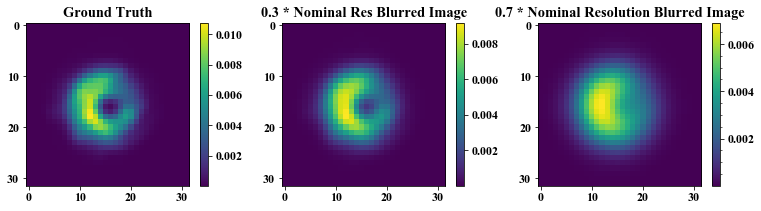

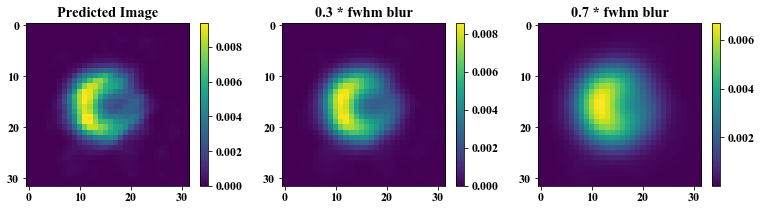

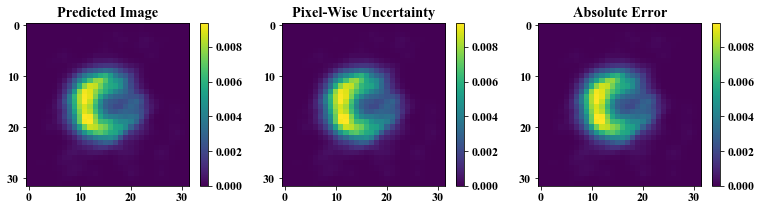

Vis Chi^2 =  5.7062001958
Cphase Chi^2 =  0.6117
Camp Chi^2 =  1.1165
XC =  0.9867
5.7062001958
0.6117
1.1165
0.9867

Test Image  954 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

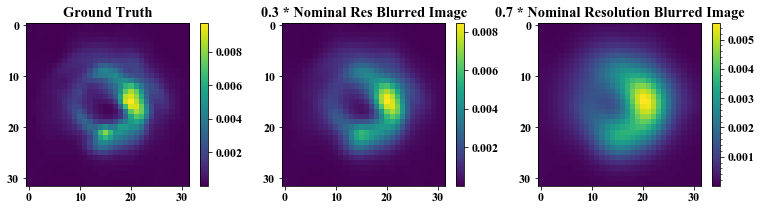

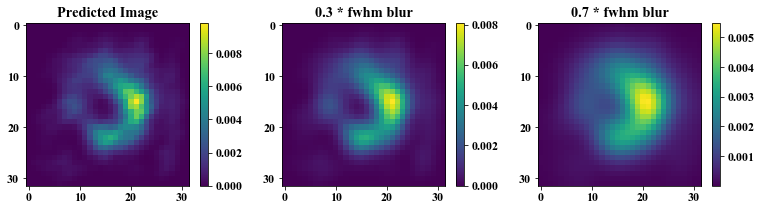

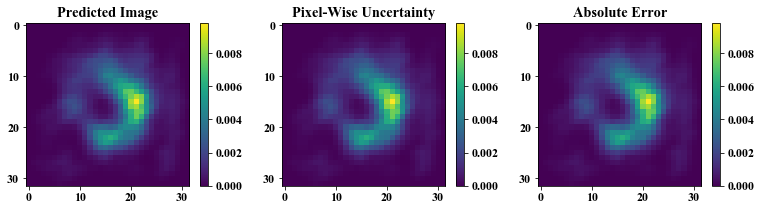

Vis Chi^2 =  20.5870977087
Cphase Chi^2 =  4.9726
Camp Chi^2 =  1.797
XC =  0.9793
20.5870977087
4.9726
1.797
0.9793

Test Image  2811 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

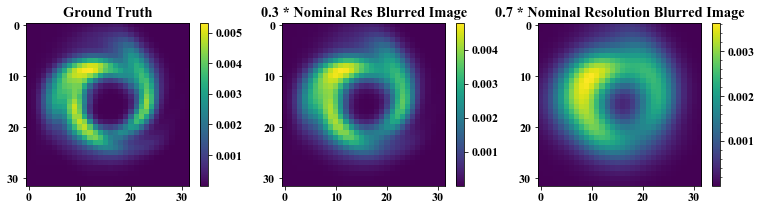

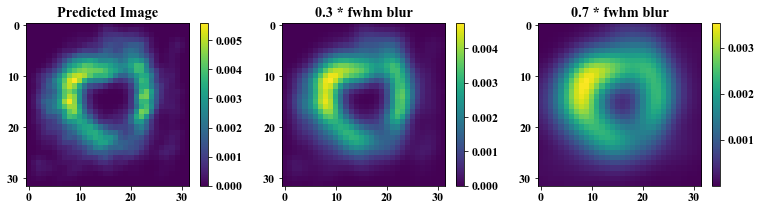

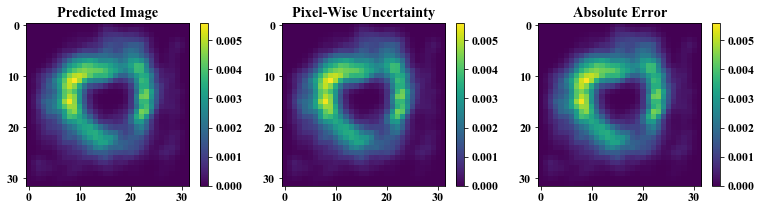

Vis Chi^2 =  12.4865460329
Cphase Chi^2 =  2.4113
Camp Chi^2 =  4.2718
XC =  0.9784
12.4865460329
2.4113
4.2718
0.9784

Test Image  1027 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

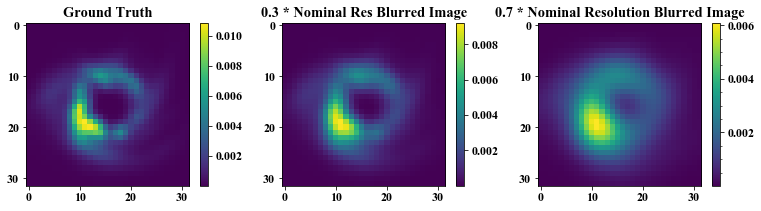

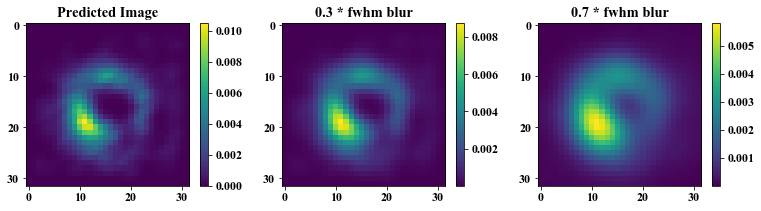

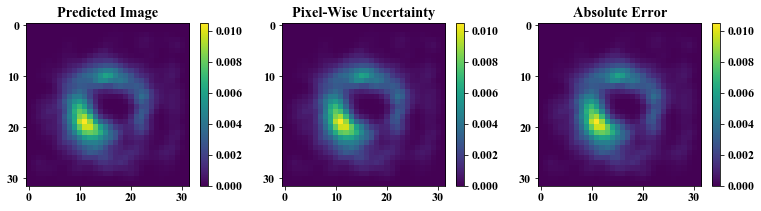

Vis Chi^2 =  31.8562200963
Cphase Chi^2 =  6.0246
Camp Chi^2 =  2.6301
XC =  0.9732
31.8562200963
6.0246
2.6301
0.9732

Results: (alpha= 1 )
Avg. XC =  0.9803
Avg. Vis =  15.6096
Avg. Cphase =  7.6341
Avg. Camp =  4.6866
-----------------------------------------------------------
-------------------  alpha =  2  ---------------------------
-----------------------------------------------------------
Test Image  1006 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Add

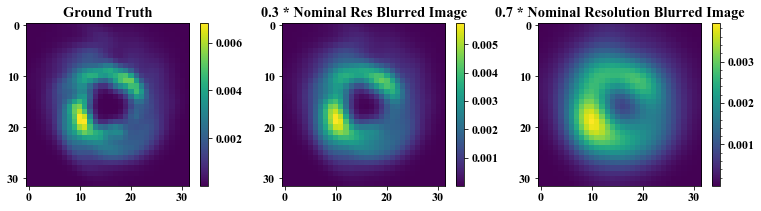

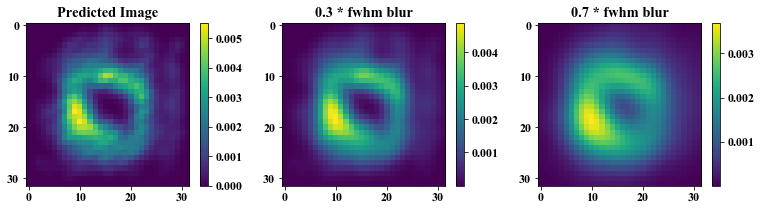

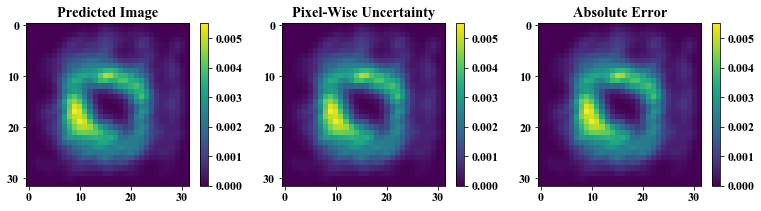

Vis Chi^2 =  5.7815521856
Cphase Chi^2 =  0.5837
Camp Chi^2 =  1.0293
XC =  0.9742
5.7815521856
0.5837
1.0293
0.9742

Test Image  2685 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

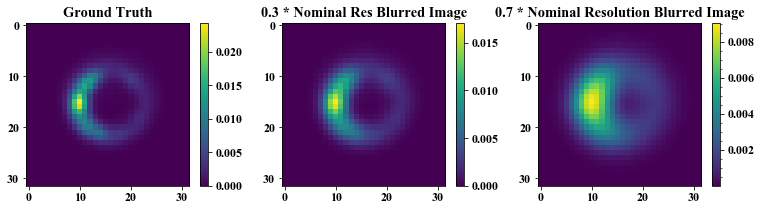

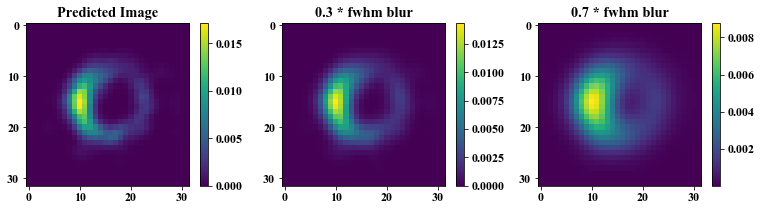

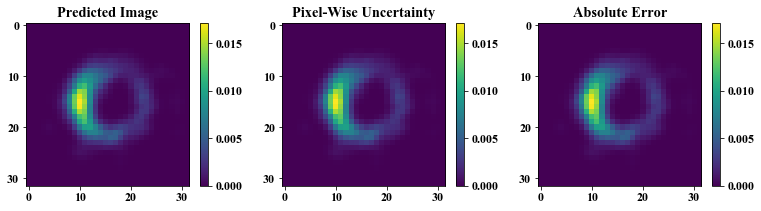

Vis Chi^2 =  21.4687140832
Cphase Chi^2 =  5.2892
Camp Chi^2 =  3.7864
XC =  0.9761
21.4687140832
5.2892
3.7864
0.9761

Test Image  1731 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

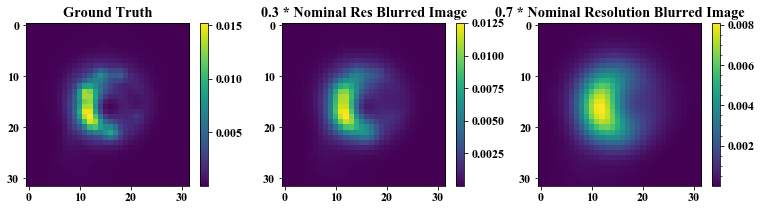

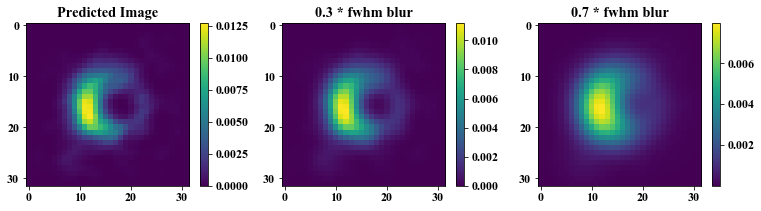

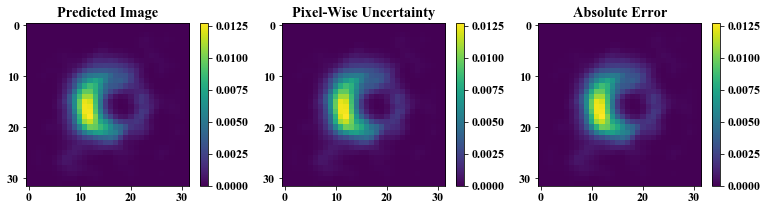

Vis Chi^2 =  3.9498342738
Cphase Chi^2 =  1.0042
Camp Chi^2 =  0.951
XC =  0.984
3.9498342738
1.0042
0.951
0.984

Test Image  2828 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

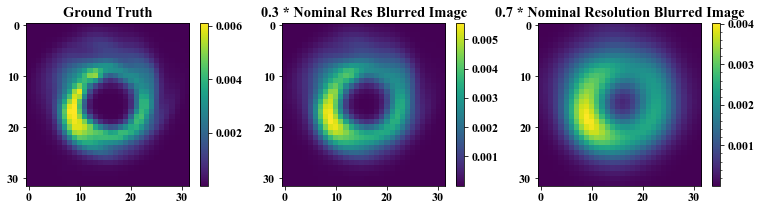

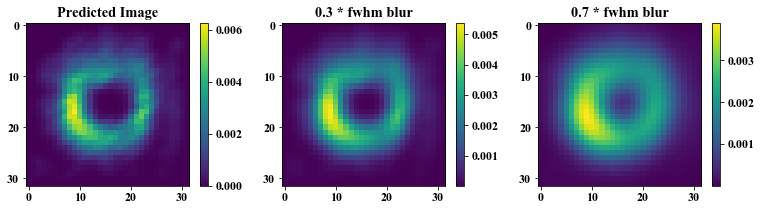

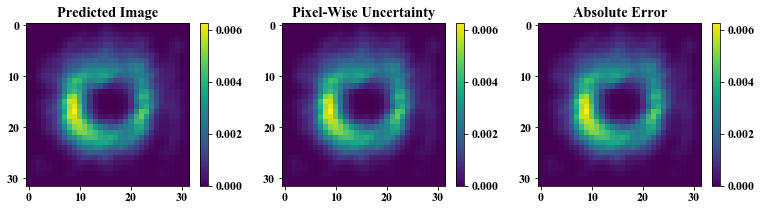

Vis Chi^2 =  4.2032055392
Cphase Chi^2 =  0.2772
Camp Chi^2 =  2.8572
XC =  0.985
4.2032055392
0.2772
2.8572
0.985

Test Image  2791 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

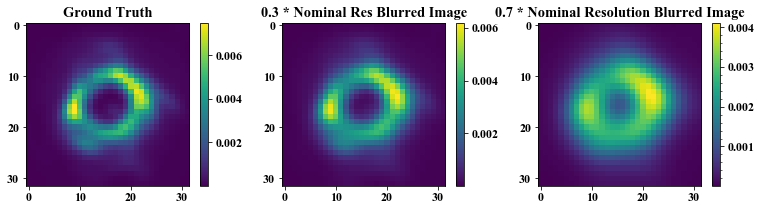

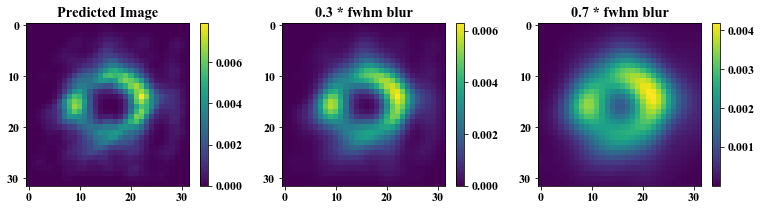

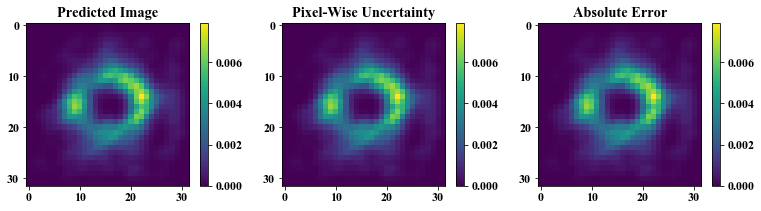

Vis Chi^2 =  32.381227669
Cphase Chi^2 =  24.2824
Camp Chi^2 =  4.619
XC =  0.9769
32.381227669
24.2824
4.619
0.9769

Test Image  687 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

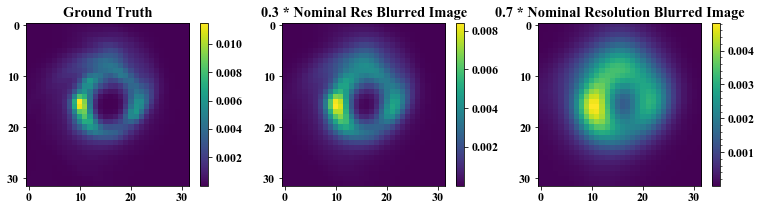

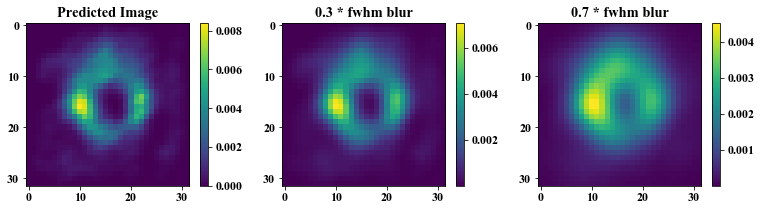

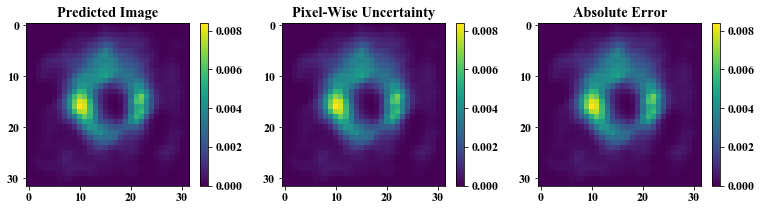

Vis Chi^2 =  30.7338100115
Cphase Chi^2 =  18.7099
Camp Chi^2 =  36.976
XC =  0.9677
30.7338100115
18.7099
36.976
0.9677

Test Image  2127 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

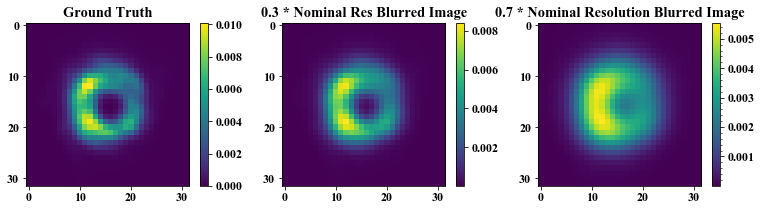

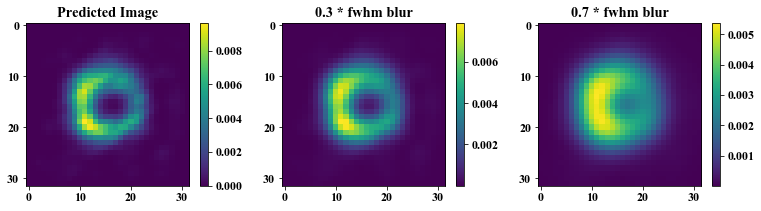

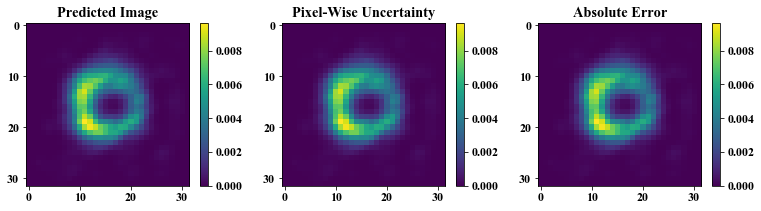

Vis Chi^2 =  2.1429999052
Cphase Chi^2 =  1.0819
Camp Chi^2 =  0.39
XC =  0.9905
2.1429999052
1.0819
0.39
0.9905

Test Image  2903 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

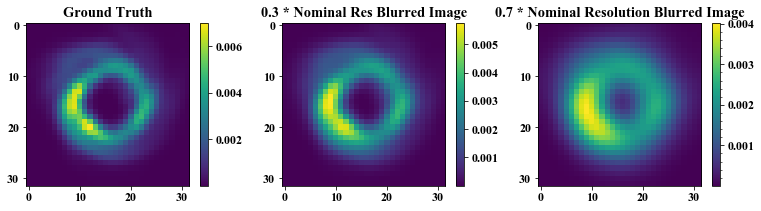

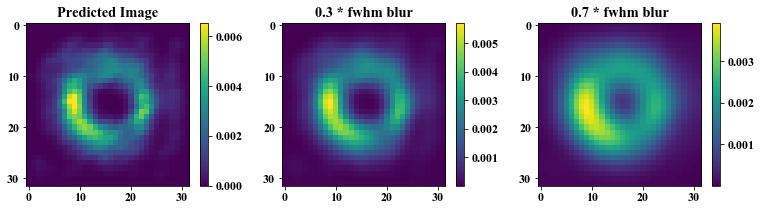

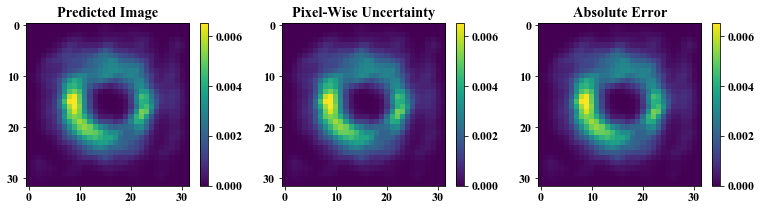

Vis Chi^2 =  5.2150809241
Cphase Chi^2 =  0.185
Camp Chi^2 =  1.4814
XC =  0.9804
5.2150809241
0.185
1.4814
0.9804

Test Image  1419 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

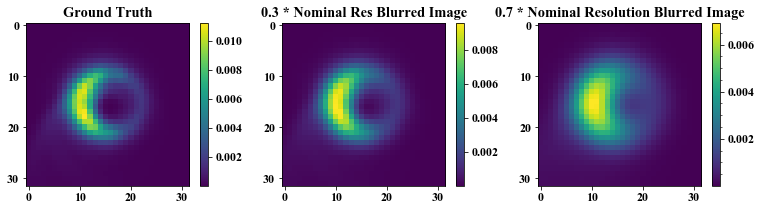

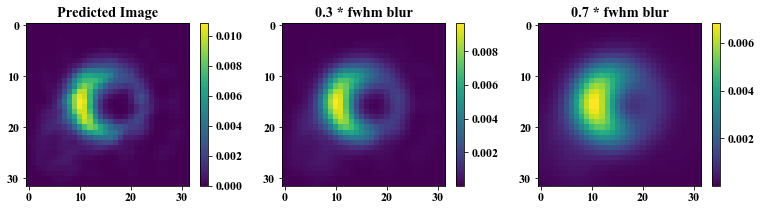

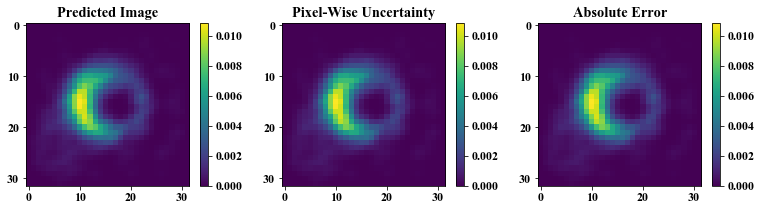

Vis Chi^2 =  3.9528016759
Cphase Chi^2 =  0.5482
Camp Chi^2 =  0.8399
XC =  0.9939
3.9528016759
0.5482
0.8399
0.9939

Test Image  1966 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

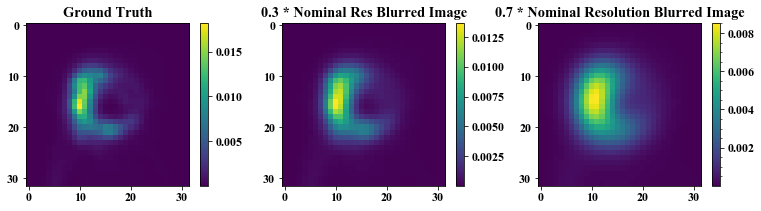

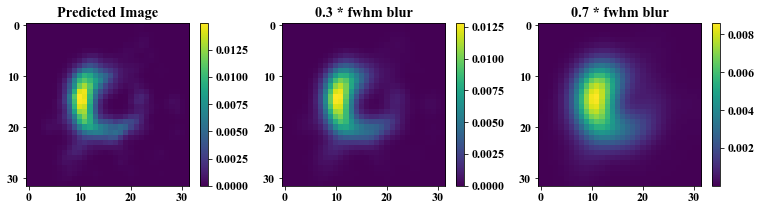

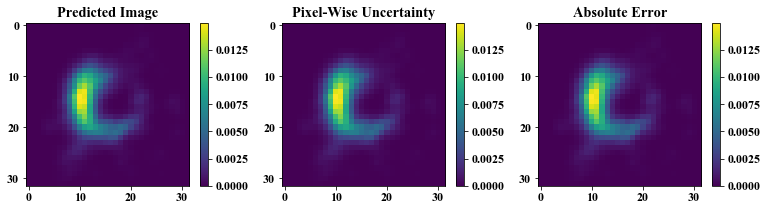

Vis Chi^2 =  8.3222114874
Cphase Chi^2 =  6.1741
Camp Chi^2 =  1.4397
XC =  0.9881
8.3222114874
6.1741
1.4397
0.9881

Test Image  44 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

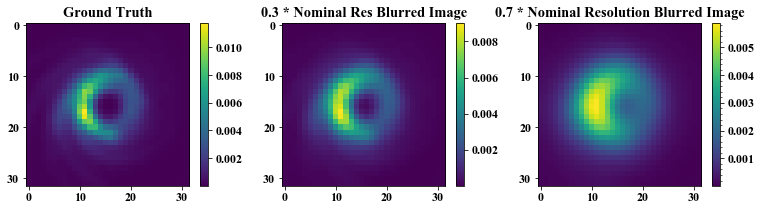

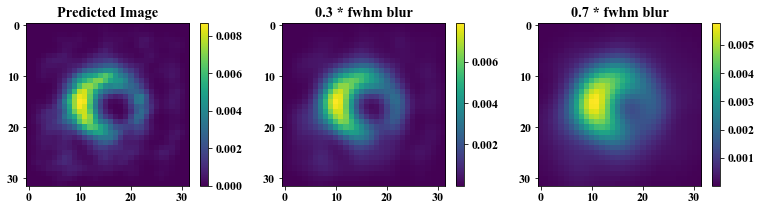

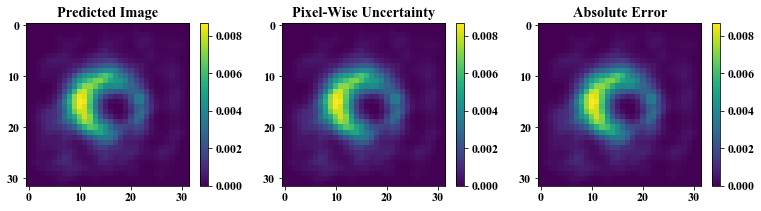

Vis Chi^2 =  45.356454166
Cphase Chi^2 =  42.3554
Camp Chi^2 =  6.1138
XC =  0.9708
45.356454166
42.3554
6.1138
0.9708

Test Image  2993 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

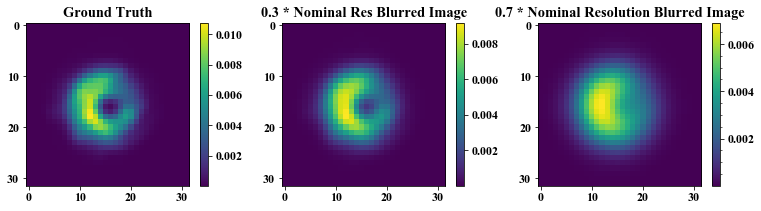

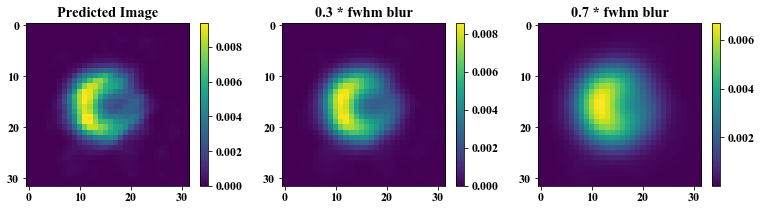

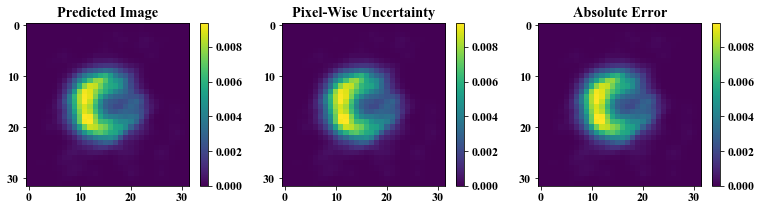

Vis Chi^2 =  5.7062001958
Cphase Chi^2 =  0.6117
Camp Chi^2 =  1.1165
XC =  0.9867
5.7062001958
0.6117
1.1165
0.9867

Test Image  954 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

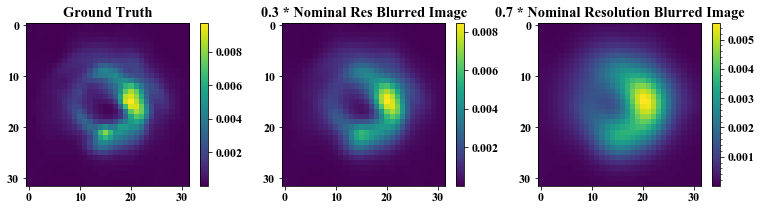

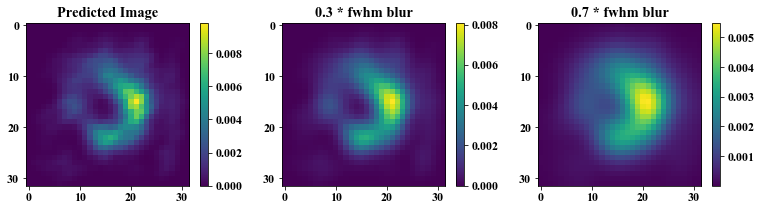

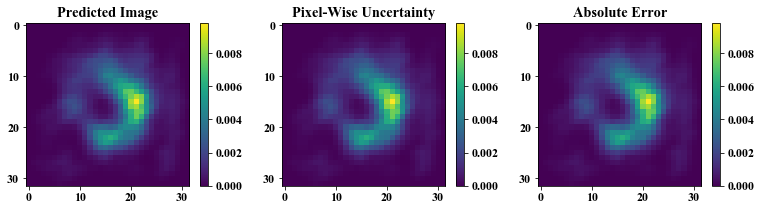

Vis Chi^2 =  20.5870977087
Cphase Chi^2 =  4.9726
Camp Chi^2 =  1.797
XC =  0.9793
20.5870977087
4.9726
1.797
0.9793

Test Image  2811 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

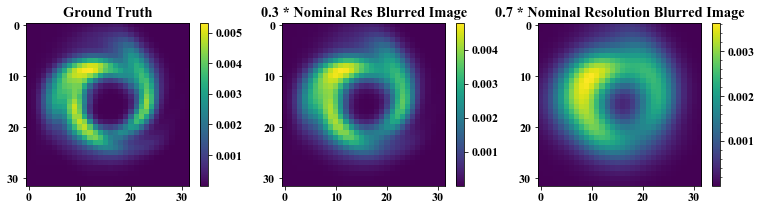

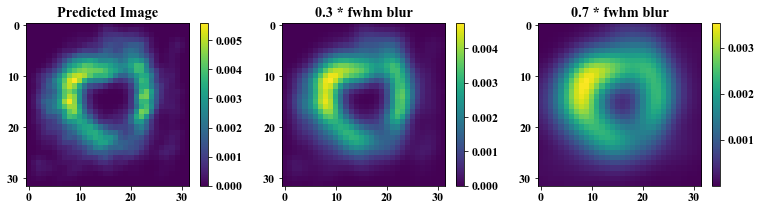

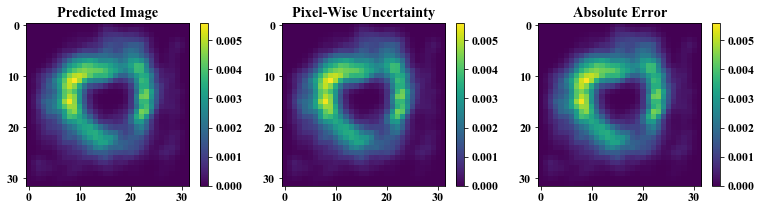

Vis Chi^2 =  12.4865460329
Cphase Chi^2 =  2.4113
Camp Chi^2 =  4.2718
XC =  0.9784
12.4865460329
2.4113
4.2718
0.9784

Test Image  1027 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

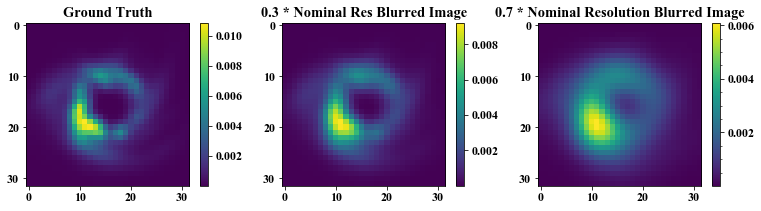

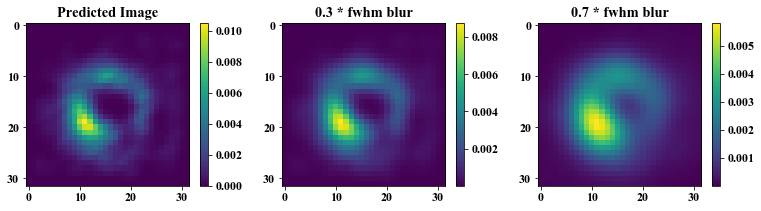

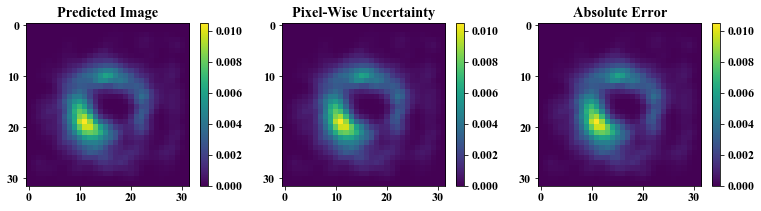

Vis Chi^2 =  31.8562200963
Cphase Chi^2 =  6.0246
Camp Chi^2 =  2.6301
XC =  0.9732
31.8562200963
6.0246
2.6301
0.9732

Results: (alpha= 2 )
Avg. XC =  0.9803
Avg. Vis =  15.6096
Avg. Cphase =  7.6341
Avg. Camp =  4.6866
-----------------------------------------------------------
-------------------  alpha =  5  ---------------------------
-----------------------------------------------------------
Test Image  1006 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Add

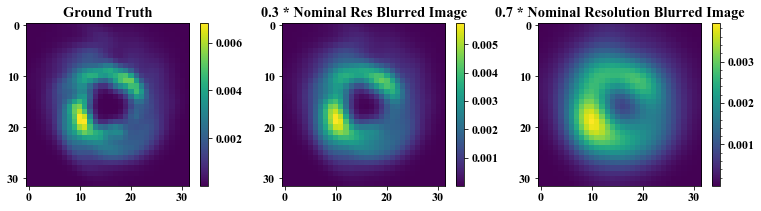

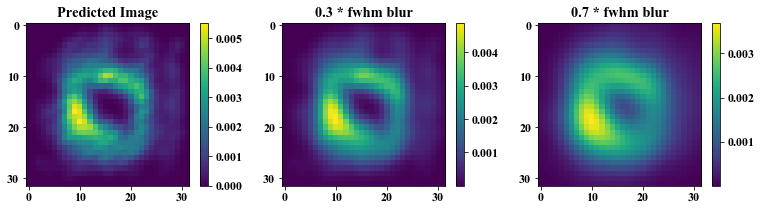

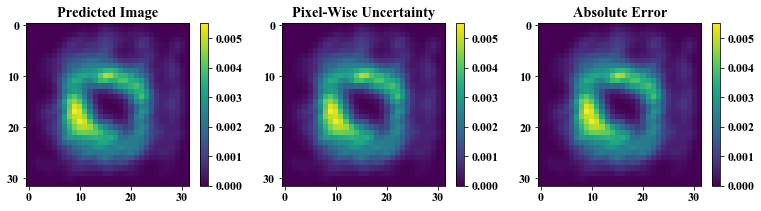

Vis Chi^2 =  5.7815521856
Cphase Chi^2 =  0.5837
Camp Chi^2 =  1.0293
XC =  0.9742
5.7815521856
0.5837
1.0293
0.9742

Test Image  2685 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

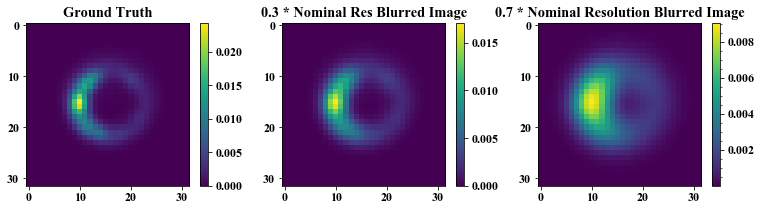

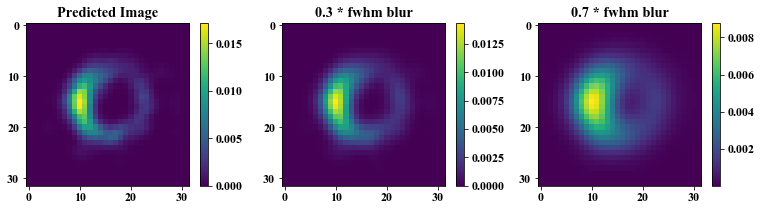

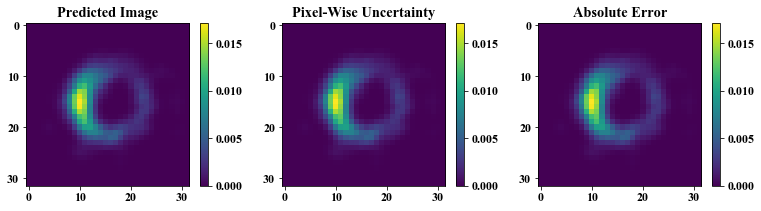

Vis Chi^2 =  21.4687140832
Cphase Chi^2 =  5.2892
Camp Chi^2 =  3.7864
XC =  0.9761
21.4687140832
5.2892
3.7864
0.9761

Test Image  1731 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

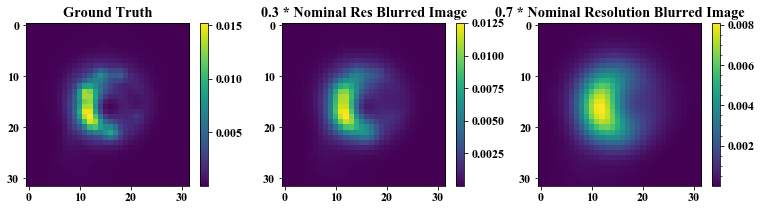

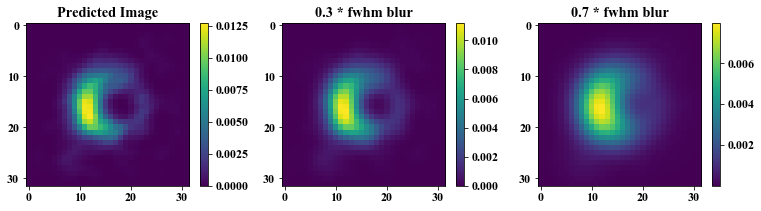

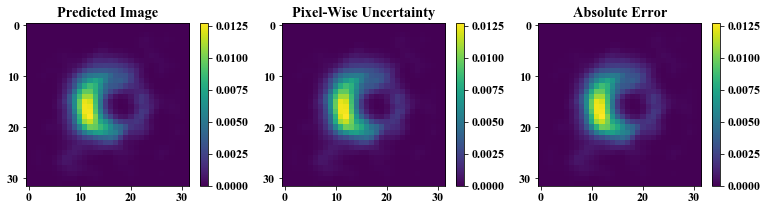

Vis Chi^2 =  3.9498342738
Cphase Chi^2 =  1.0042
Camp Chi^2 =  0.951
XC =  0.984
3.9498342738
1.0042
0.951
0.984

Test Image  2828 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

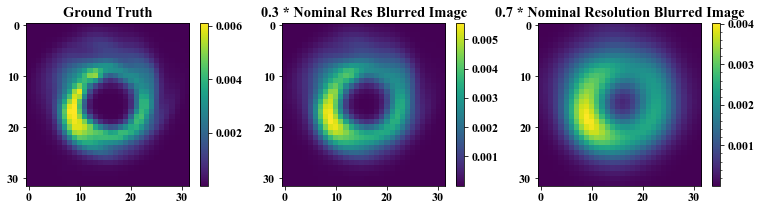

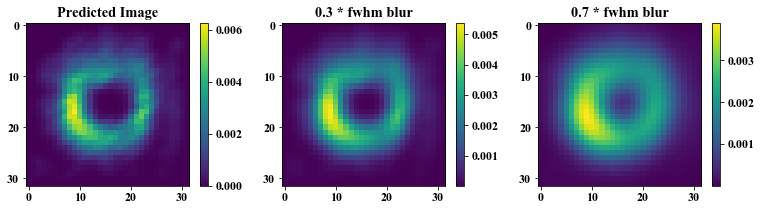

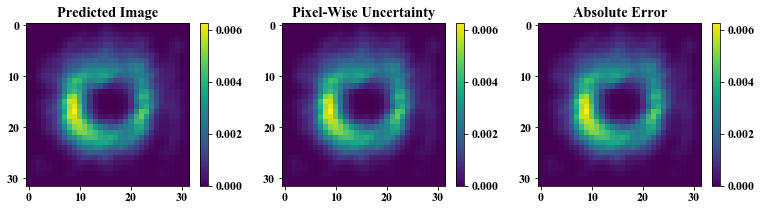

Vis Chi^2 =  4.2032055392
Cphase Chi^2 =  0.2772
Camp Chi^2 =  2.8572
XC =  0.985
4.2032055392
0.2772
2.8572
0.985

Test Image  2791 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

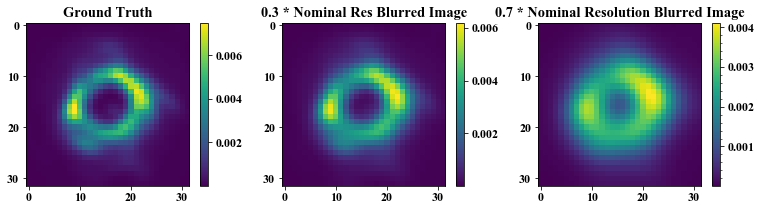

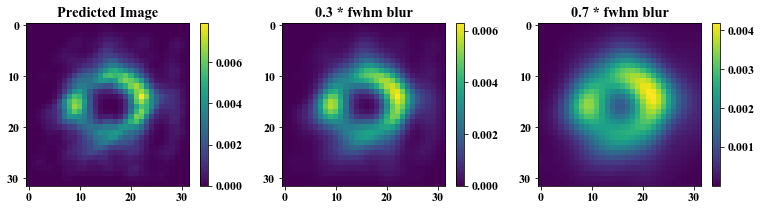

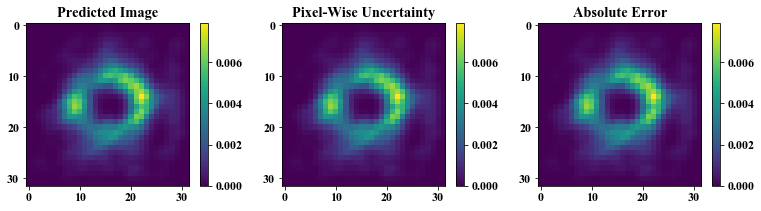

Vis Chi^2 =  32.381227669
Cphase Chi^2 =  24.2824
Camp Chi^2 =  4.619
XC =  0.9769
32.381227669
24.2824
4.619
0.9769

Test Image  687 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

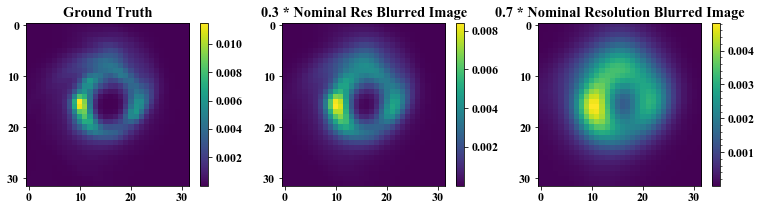

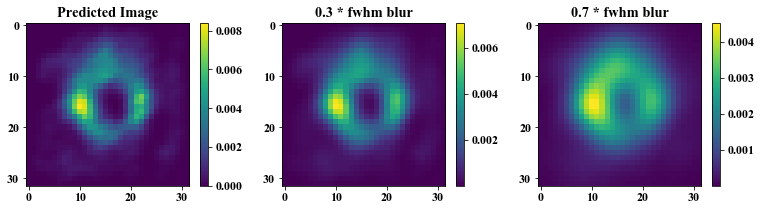

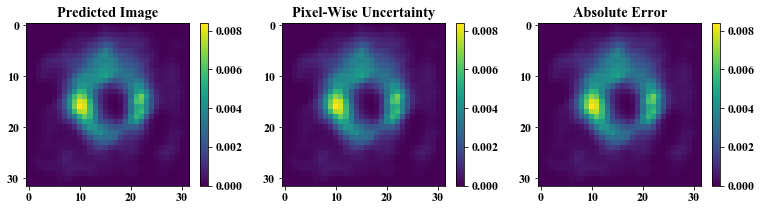

Vis Chi^2 =  30.7338100115
Cphase Chi^2 =  18.7099
Camp Chi^2 =  36.976
XC =  0.9677
30.7338100115
18.7099
36.976
0.9677

Test Image  2127 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

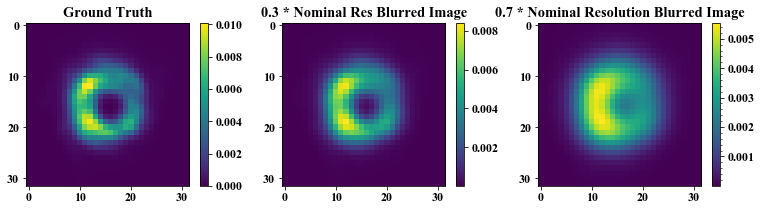

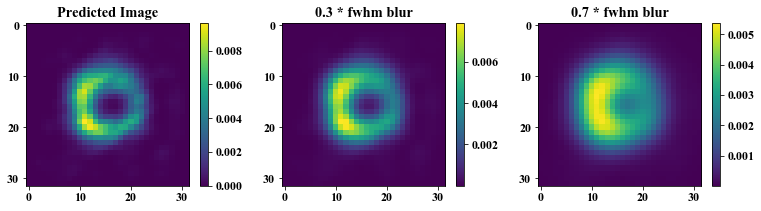

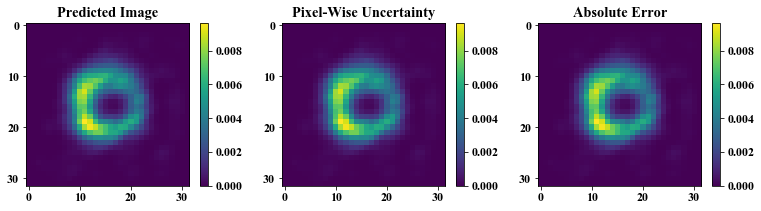

Vis Chi^2 =  2.1429999052
Cphase Chi^2 =  1.0819
Camp Chi^2 =  0.39
XC =  0.9905
2.1429999052
1.0819
0.39
0.9905

Test Image  2903 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

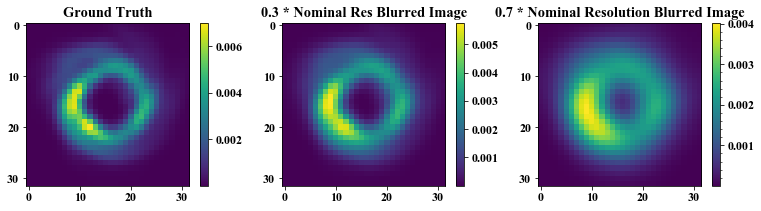

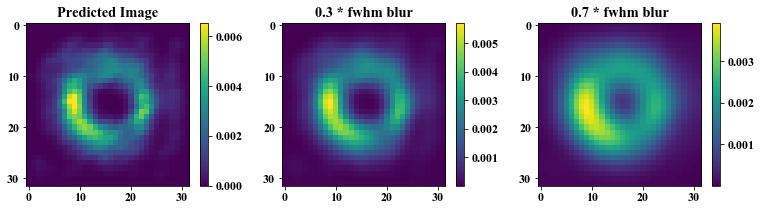

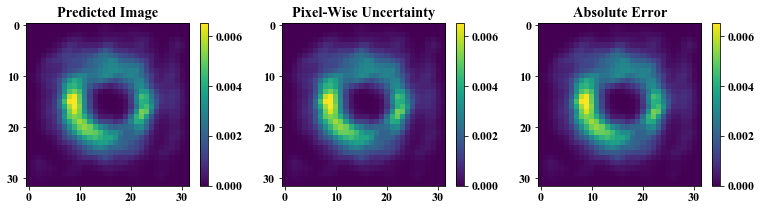

Vis Chi^2 =  5.2150809241
Cphase Chi^2 =  0.185
Camp Chi^2 =  1.4814
XC =  0.9804
5.2150809241
0.185
1.4814
0.9804

Test Image  1419 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

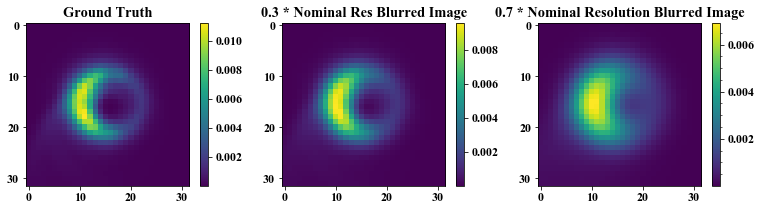

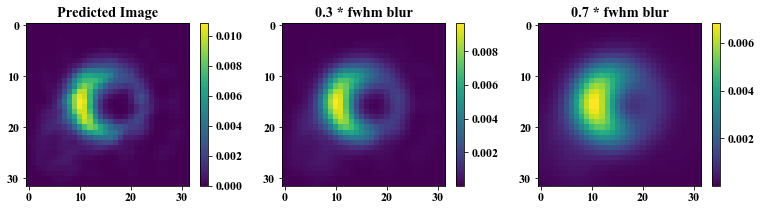

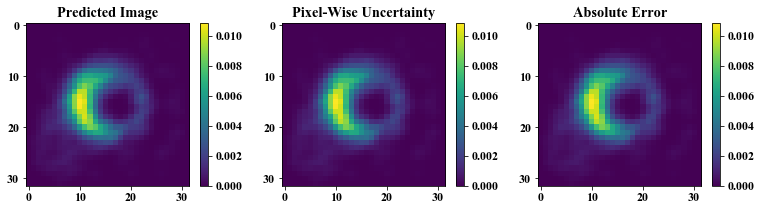

Vis Chi^2 =  3.9528016759
Cphase Chi^2 =  0.5482
Camp Chi^2 =  0.8399
XC =  0.9939
3.9528016759
0.5482
0.8399
0.9939

Test Image  1966 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

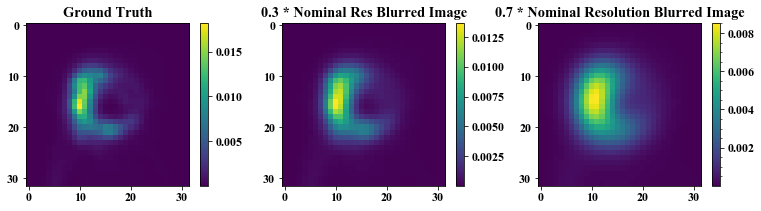

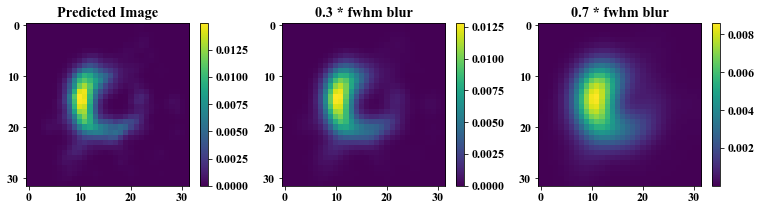

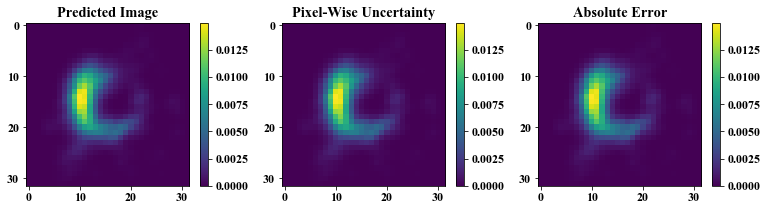

Vis Chi^2 =  8.3222114874
Cphase Chi^2 =  6.1741
Camp Chi^2 =  1.4397
XC =  0.9881
8.3222114874
6.1741
1.4397
0.9881

Test Image  44 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

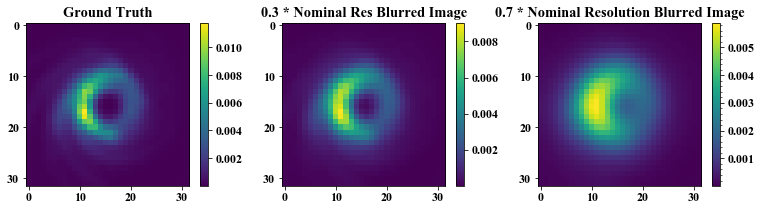

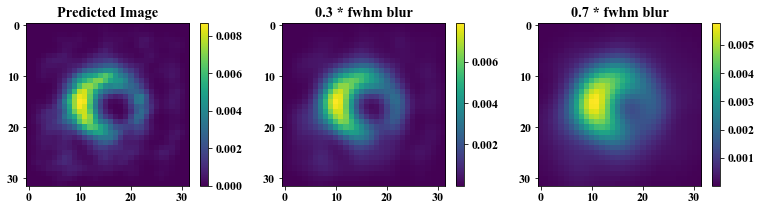

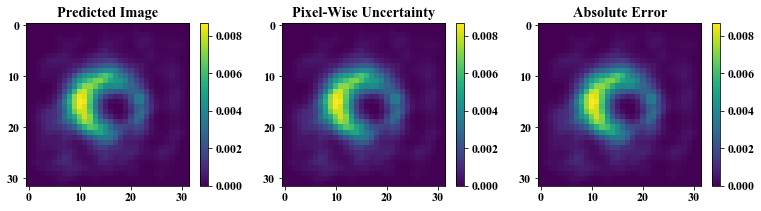

Vis Chi^2 =  45.356454166
Cphase Chi^2 =  42.3554
Camp Chi^2 =  6.1138
XC =  0.9708
45.356454166
42.3554
6.1138
0.9708

Test Image  2993 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

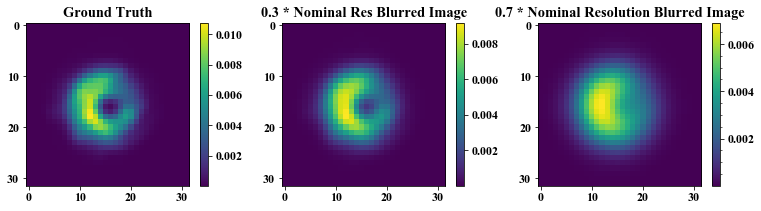

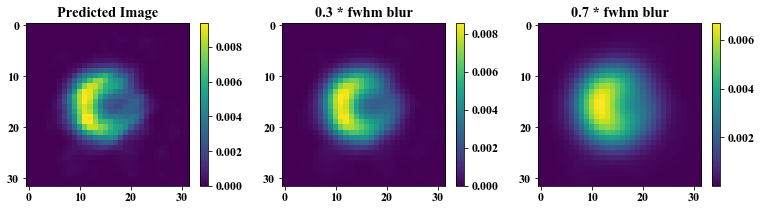

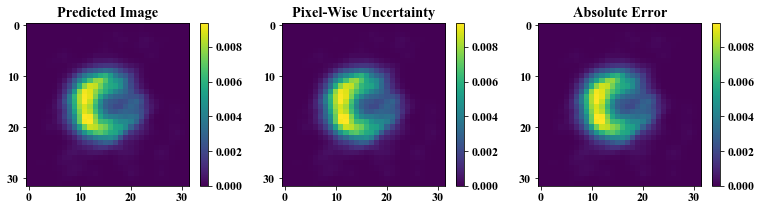

Vis Chi^2 =  5.7062001958
Cphase Chi^2 =  0.6117
Camp Chi^2 =  1.1165
XC =  0.9867
5.7062001958
0.6117
1.1165
0.9867

Test Image  954 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

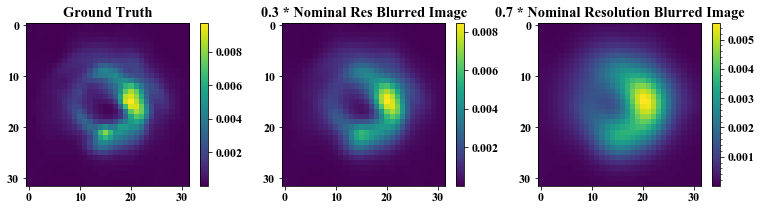

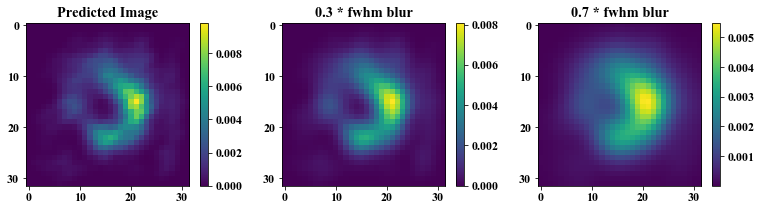

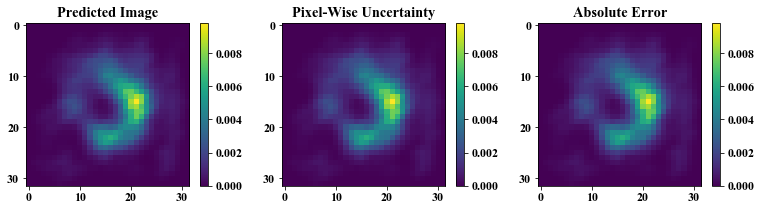

Vis Chi^2 =  20.5870977087
Cphase Chi^2 =  4.9726
Camp Chi^2 =  1.797
XC =  0.9793
20.5870977087
4.9726
1.797
0.9793

Test Image  2811 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

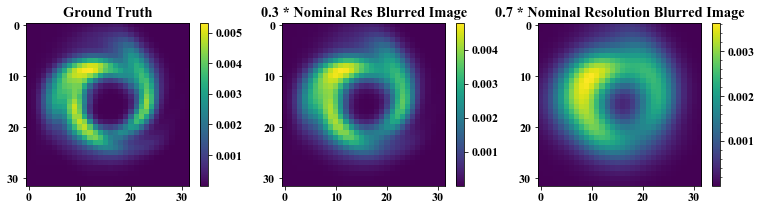

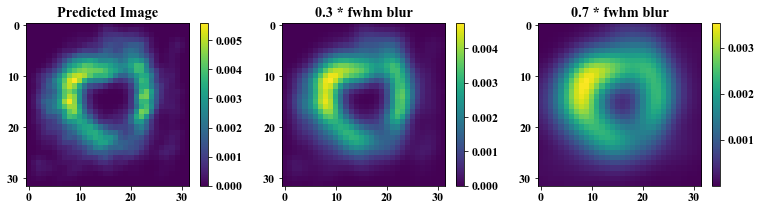

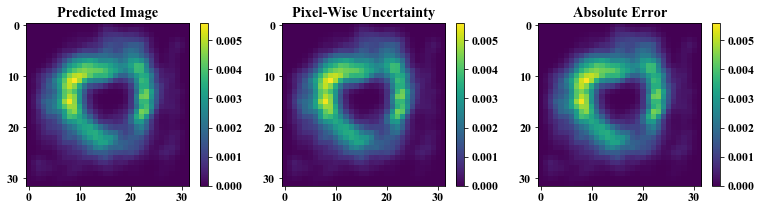

Vis Chi^2 =  12.4865460329
Cphase Chi^2 =  2.4113
Camp Chi^2 =  4.2718
XC =  0.9784
12.4865460329
2.4113
4.2718
0.9784

Test Image  1027 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

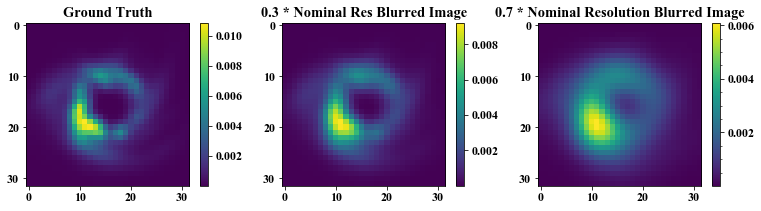

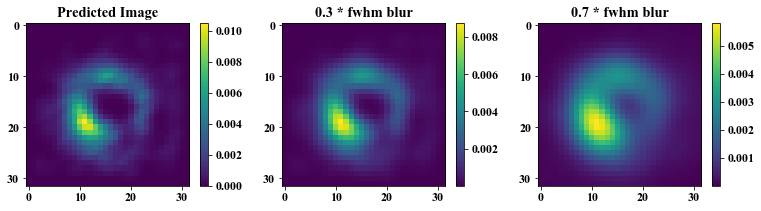

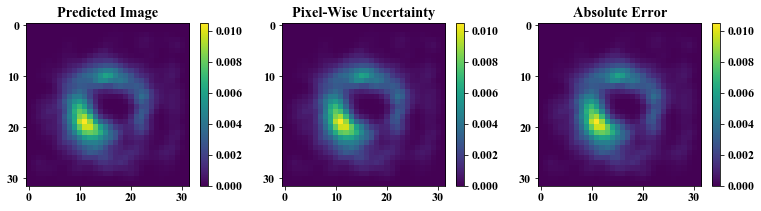

Vis Chi^2 =  31.8562200963
Cphase Chi^2 =  6.0246
Camp Chi^2 =  2.6301
XC =  0.9732
31.8562200963
6.0246
2.6301
0.9732

Results: (alpha= 5 )
Avg. XC =  0.9803
Avg. Vis =  15.6096
Avg. Cphase =  7.6341
Avg. Camp =  4.6866
-----------------------------------------------------------
-------------------  alpha =  10  ---------------------------
-----------------------------------------------------------
Test Image  1006 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Ad

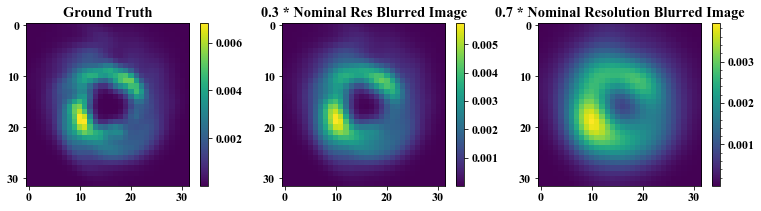

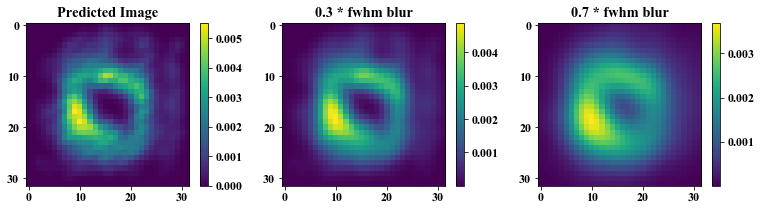

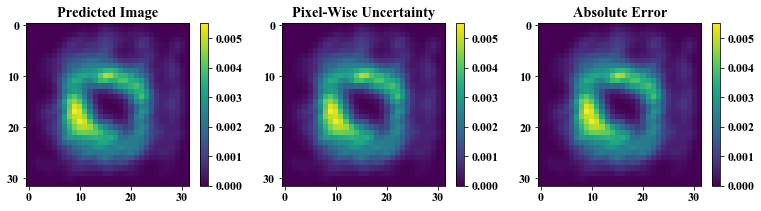

Vis Chi^2 =  5.7815521856
Cphase Chi^2 =  0.5837
Camp Chi^2 =  1.0293
XC =  0.9742
5.7815521856
0.5837
1.0293
0.9742

Test Image  2685 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

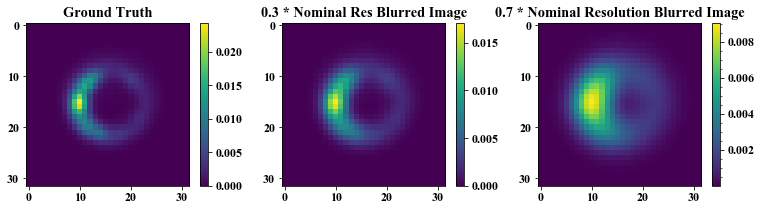

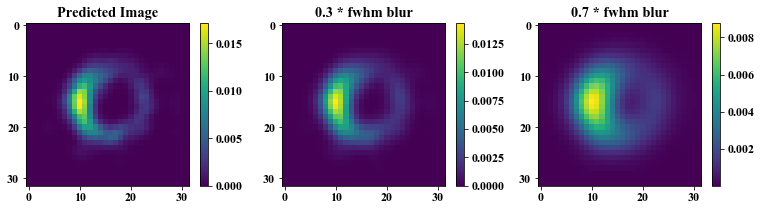

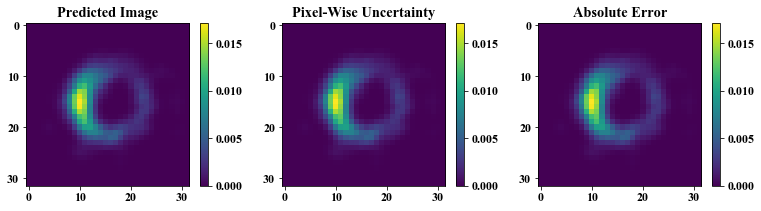

Vis Chi^2 =  21.4687140832
Cphase Chi^2 =  5.2892
Camp Chi^2 =  3.7864
XC =  0.9761
21.4687140832
5.2892
3.7864
0.9761

Test Image  1731 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

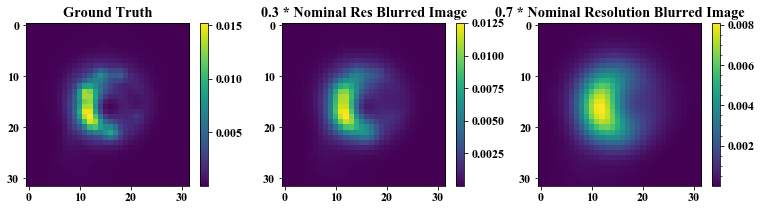

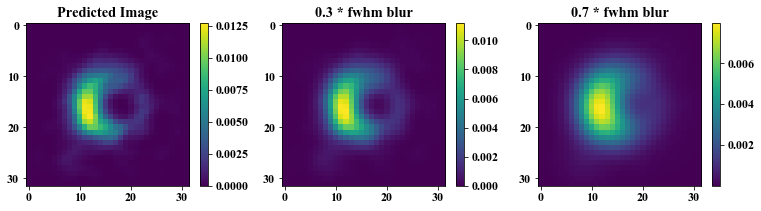

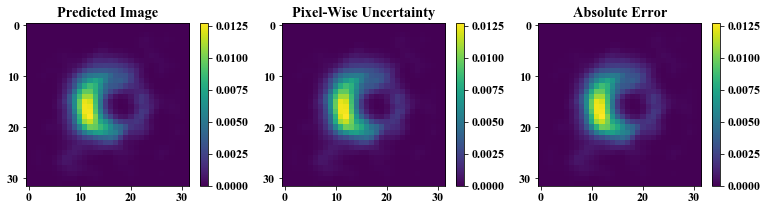

Vis Chi^2 =  3.9498342738
Cphase Chi^2 =  1.0042
Camp Chi^2 =  0.951
XC =  0.984
3.9498342738
1.0042
0.951
0.984

Test Image  2828 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

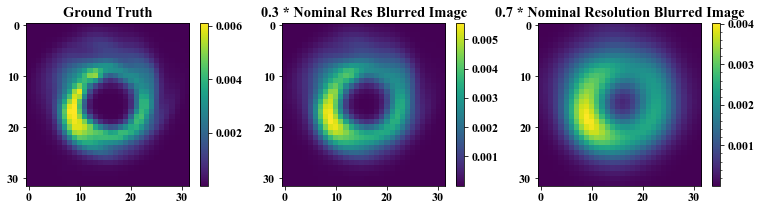

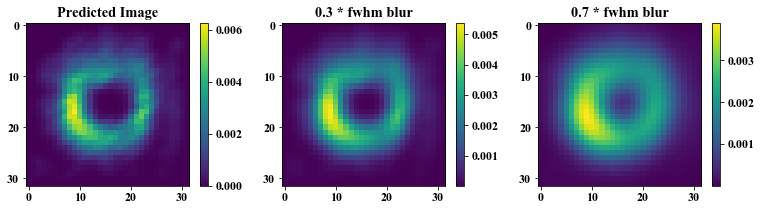

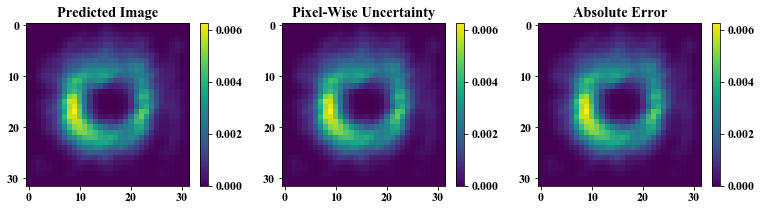

Vis Chi^2 =  4.2032055392
Cphase Chi^2 =  0.2772
Camp Chi^2 =  2.8572
XC =  0.985
4.2032055392
0.2772
2.8572
0.985

Test Image  2791 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

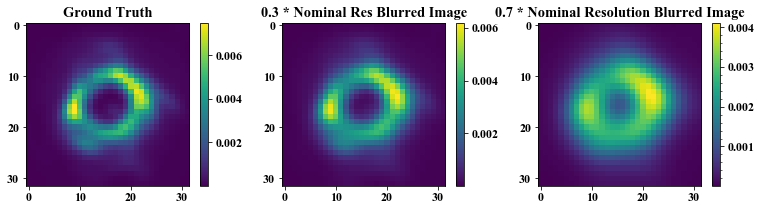

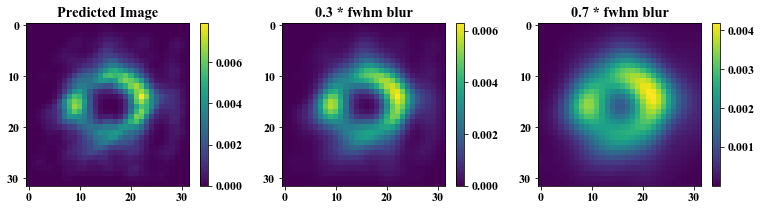

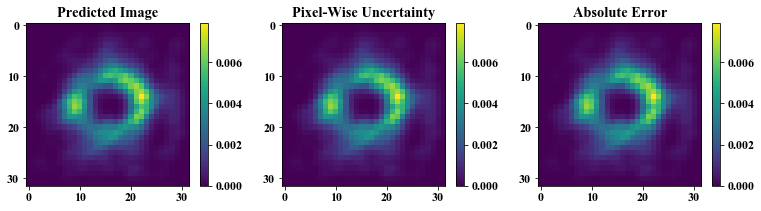

Vis Chi^2 =  32.381227669
Cphase Chi^2 =  24.2824
Camp Chi^2 =  4.619
XC =  0.9769
32.381227669
24.2824
4.619
0.9769

Test Image  687 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

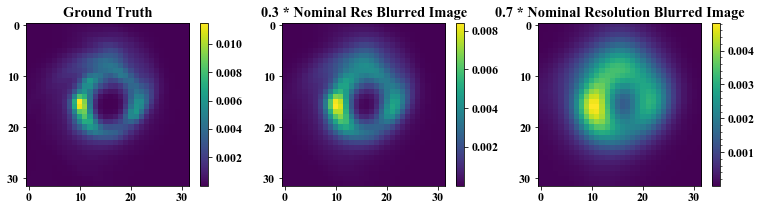

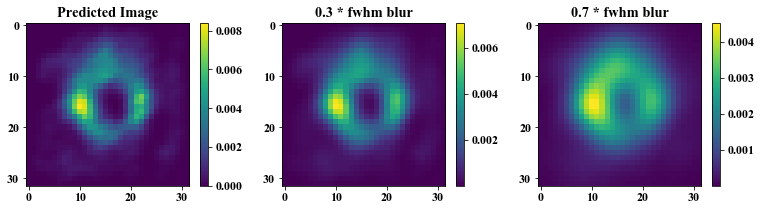

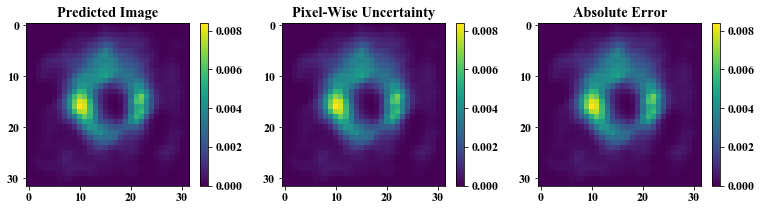

Vis Chi^2 =  30.7338100115
Cphase Chi^2 =  18.7099
Camp Chi^2 =  36.976
XC =  0.9677
30.7338100115
18.7099
36.976
0.9677

Test Image  2127 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

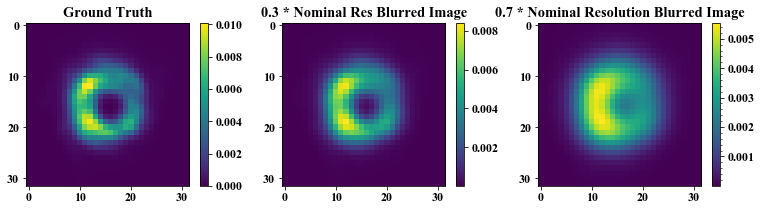

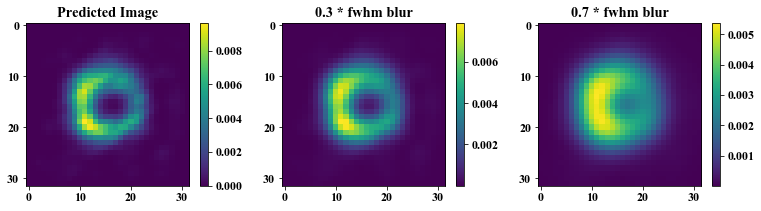

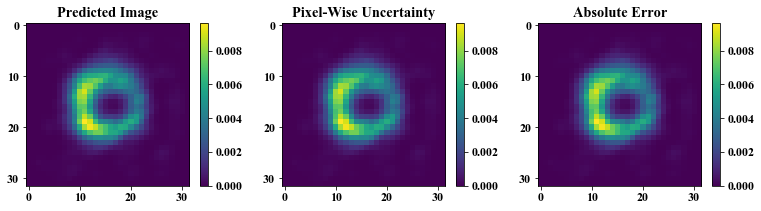

Vis Chi^2 =  2.1429999052
Cphase Chi^2 =  1.0819
Camp Chi^2 =  0.39
XC =  0.9905
2.1429999052
1.0819
0.39
0.9905

Test Image  2903 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

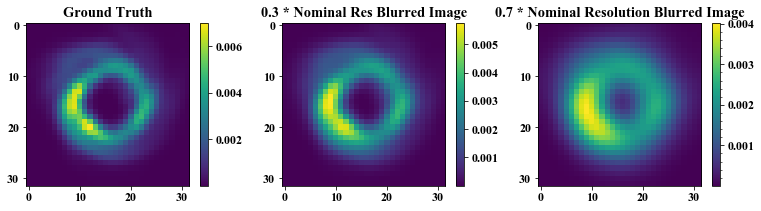

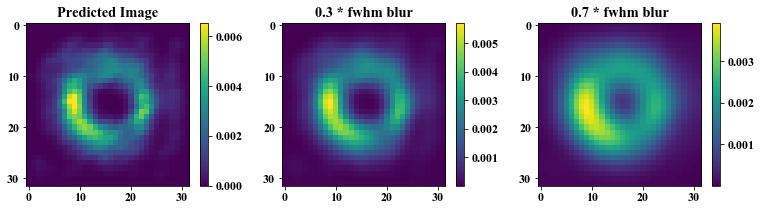

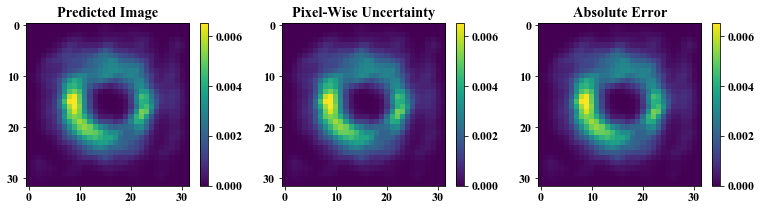

Vis Chi^2 =  5.2150809241
Cphase Chi^2 =  0.185
Camp Chi^2 =  1.4814
XC =  0.9804
5.2150809241
0.185
1.4814
0.9804

Test Image  1419 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

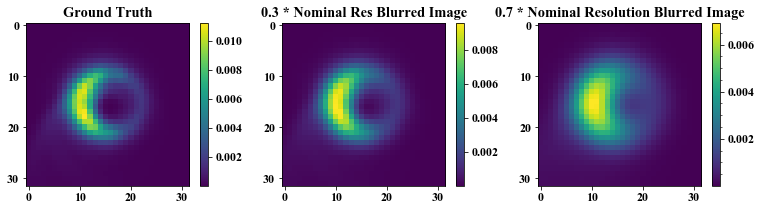

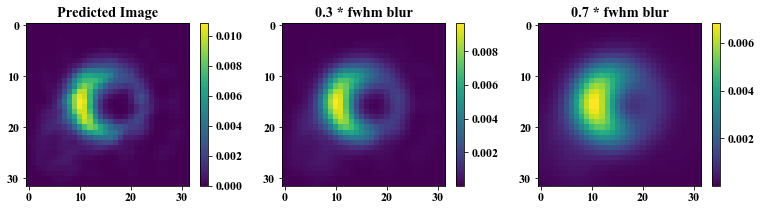

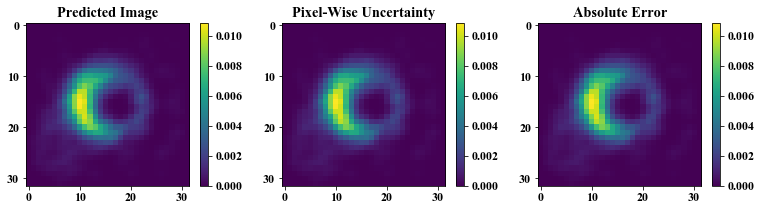

Vis Chi^2 =  3.9528016759
Cphase Chi^2 =  0.5482
Camp Chi^2 =  0.8399
XC =  0.9939
3.9528016759
0.5482
0.8399
0.9939

Test Image  1966 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

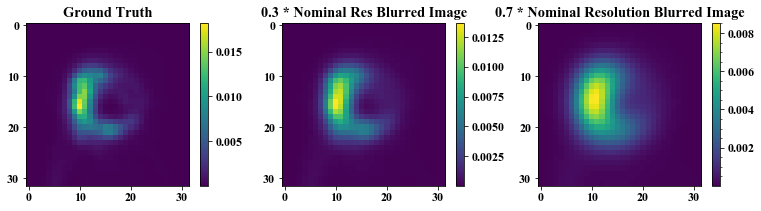

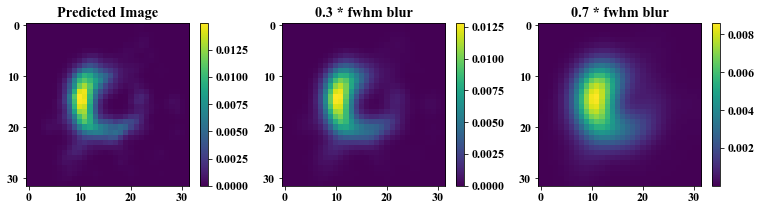

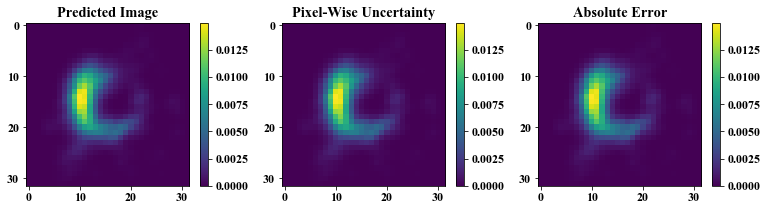

Vis Chi^2 =  8.3222114874
Cphase Chi^2 =  6.1741
Camp Chi^2 =  1.4397
XC =  0.9881
8.3222114874
6.1741
1.4397
0.9881

Test Image  44 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

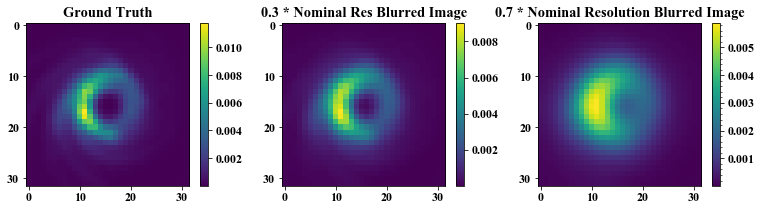

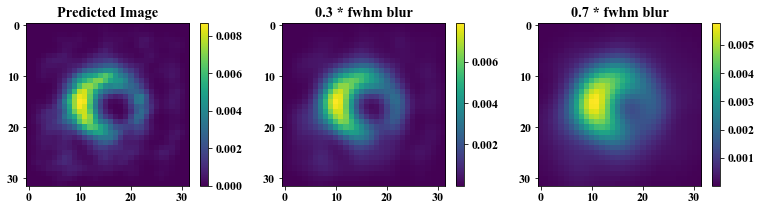

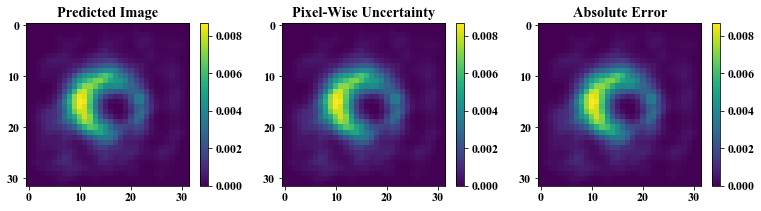

Vis Chi^2 =  45.356454166
Cphase Chi^2 =  42.3554
Camp Chi^2 =  6.1138
XC =  0.9708
45.356454166
42.3554
6.1138
0.9708

Test Image  2993 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

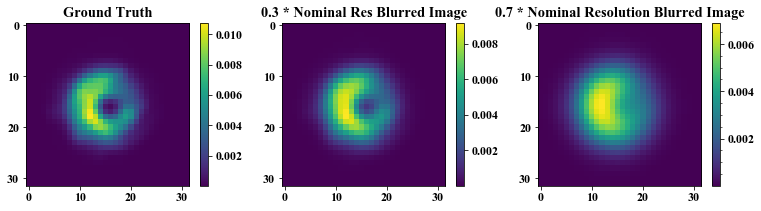

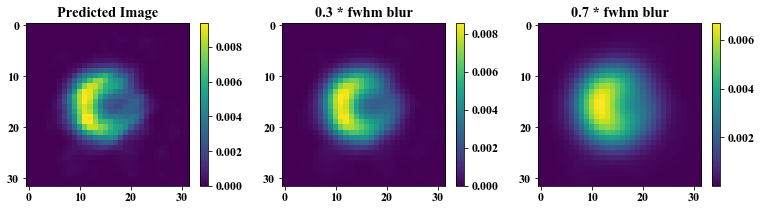

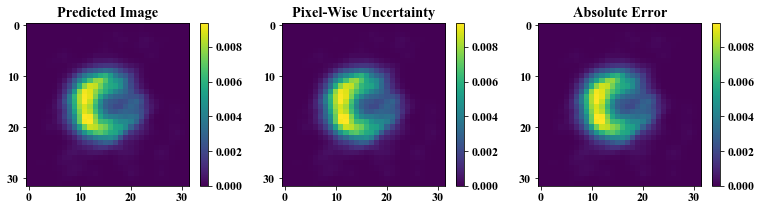

Vis Chi^2 =  5.7062001958
Cphase Chi^2 =  0.6117
Camp Chi^2 =  1.1165
XC =  0.9867
5.7062001958
0.6117
1.1165
0.9867

Test Image  954 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

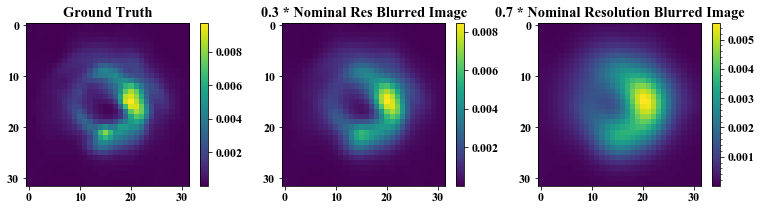

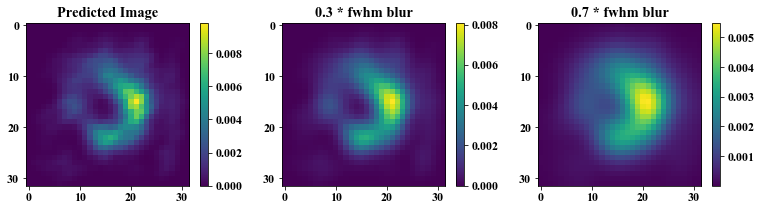

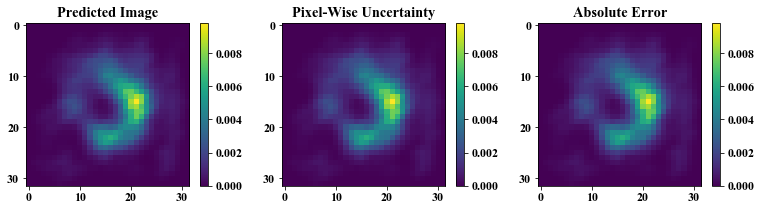

Vis Chi^2 =  20.5870977087
Cphase Chi^2 =  4.9726
Camp Chi^2 =  1.797
XC =  0.9793
20.5870977087
4.9726
1.797
0.9793

Test Image  2811 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

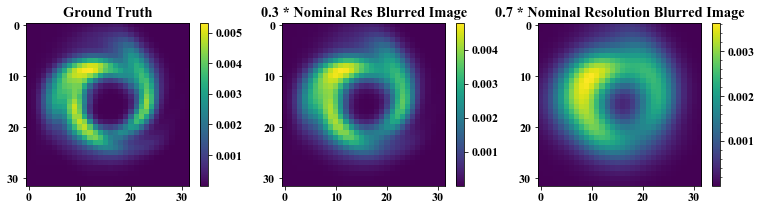

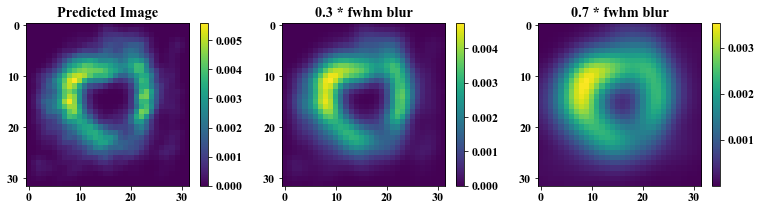

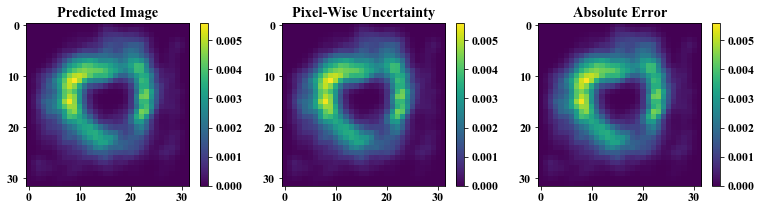

Vis Chi^2 =  12.4865460329
Cphase Chi^2 =  2.4113
Camp Chi^2 =  4.2718
XC =  0.9784
12.4865460329
2.4113
4.2718
0.9784

Test Image  1027 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

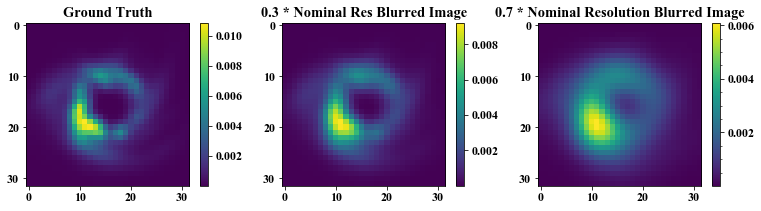

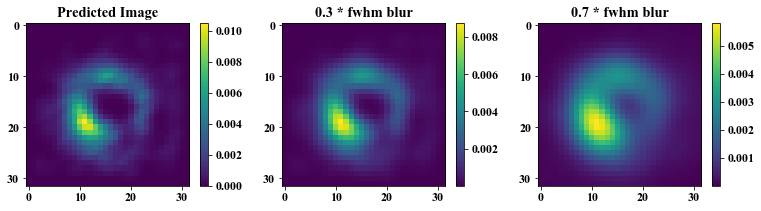

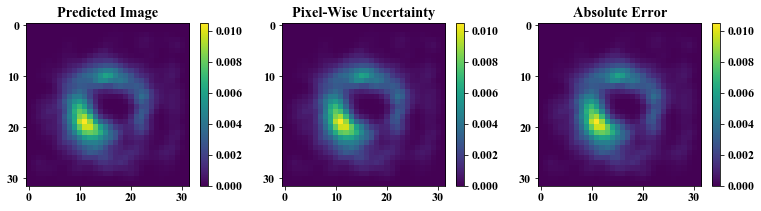

Vis Chi^2 =  31.8562200963
Cphase Chi^2 =  6.0246
Camp Chi^2 =  2.6301
XC =  0.9732
31.8562200963
6.0246
2.6301
0.9732

Results: (alpha= 10 )
Avg. XC =  0.9803
Avg. Vis =  15.6096
Avg. Cphase =  7.6341
Avg. Camp =  4.6866
-----------------------------------------------------------
-------------------  alpha =  15  ---------------------------
-----------------------------------------------------------
Test Image  1006 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
A

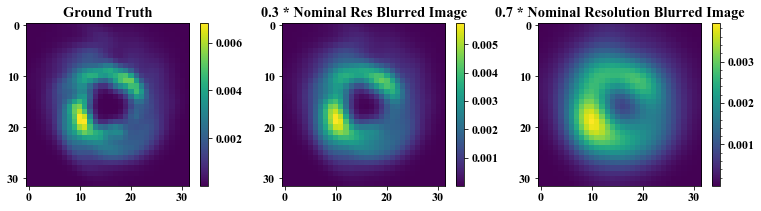

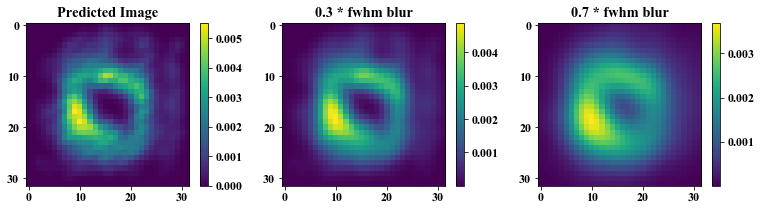

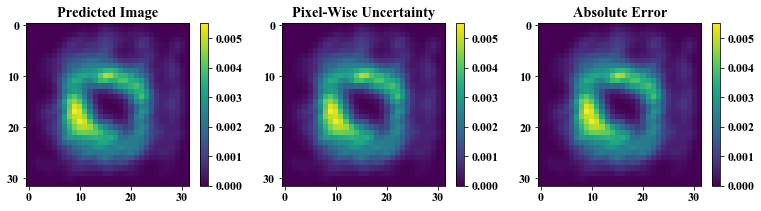

Vis Chi^2 =  5.7815521856
Cphase Chi^2 =  0.5837
Camp Chi^2 =  1.0293
XC =  0.9742
5.7815521856
0.5837
1.0293
0.9742

Test Image  2685 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

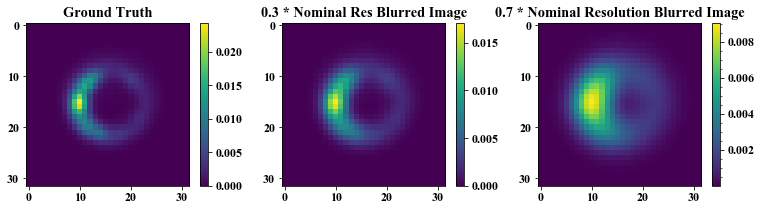

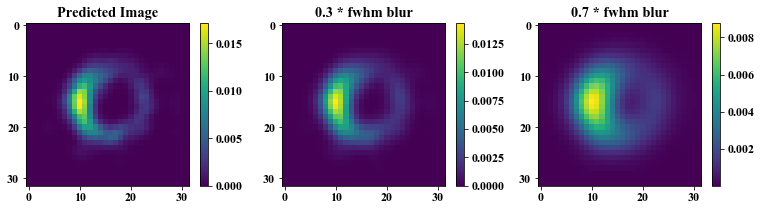

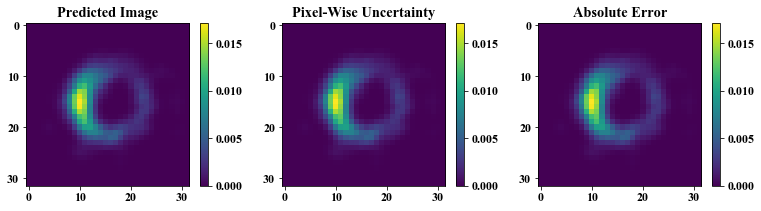

Vis Chi^2 =  21.4687140832
Cphase Chi^2 =  5.2892
Camp Chi^2 =  3.7864
XC =  0.9761
21.4687140832
5.2892
3.7864
0.9761

Test Image  1731 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

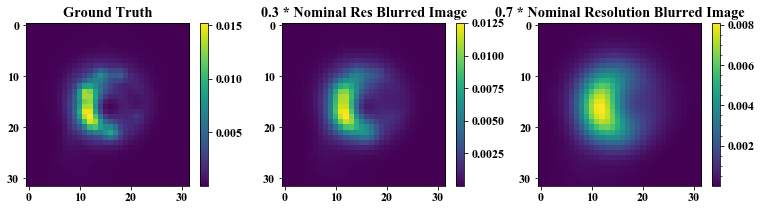

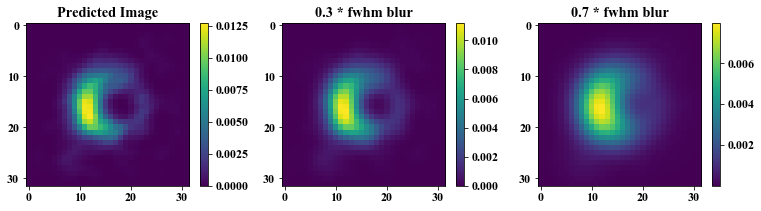

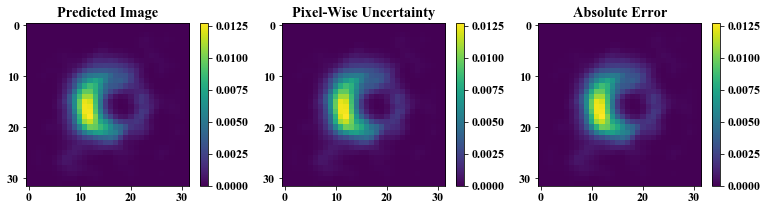

Vis Chi^2 =  3.9498342738
Cphase Chi^2 =  1.0042
Camp Chi^2 =  0.951
XC =  0.984
3.9498342738
1.0042
0.951
0.984

Test Image  2828 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

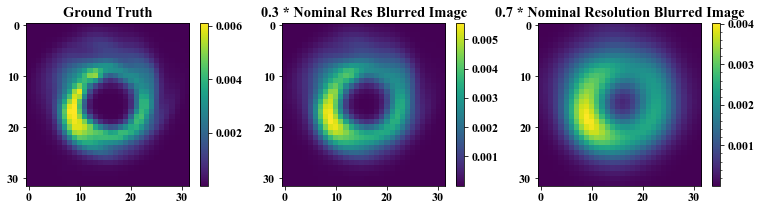

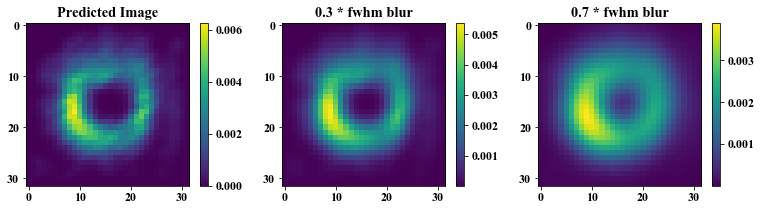

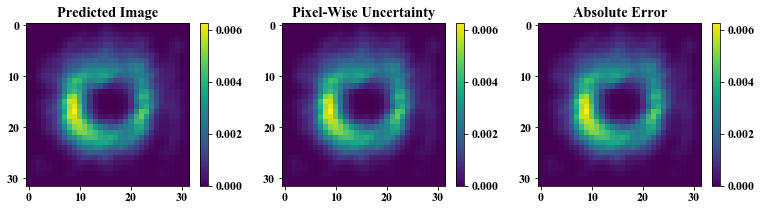

Vis Chi^2 =  4.2032055392
Cphase Chi^2 =  0.2772
Camp Chi^2 =  2.8572
XC =  0.985
4.2032055392
0.2772
2.8572
0.985

Test Image  2791 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

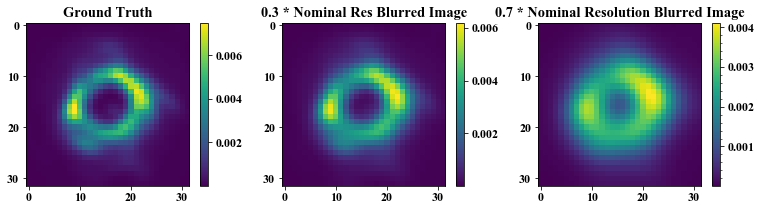

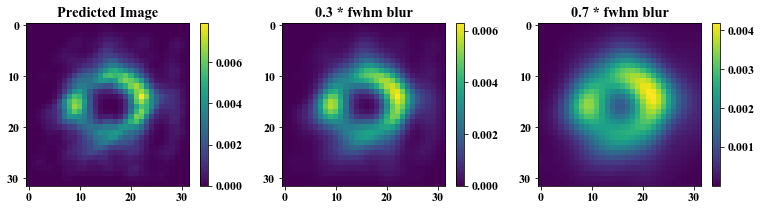

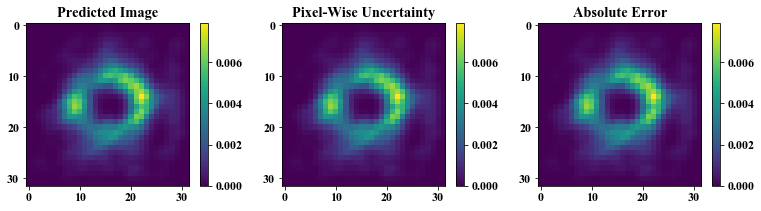

Vis Chi^2 =  32.381227669
Cphase Chi^2 =  24.2824
Camp Chi^2 =  4.619
XC =  0.9769
32.381227669
24.2824
4.619
0.9769

Test Image  687 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

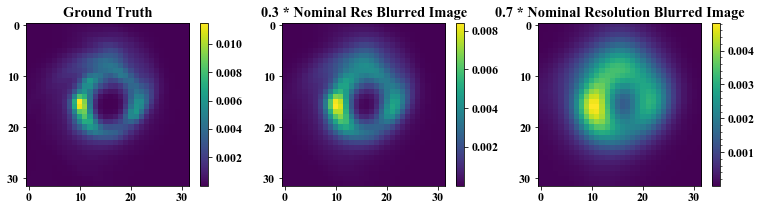

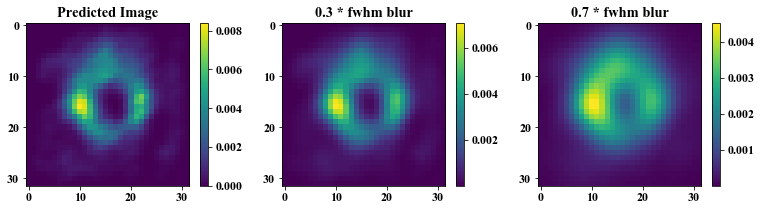

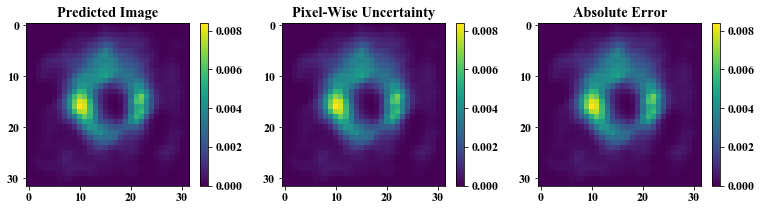

Vis Chi^2 =  30.7338100115
Cphase Chi^2 =  18.7099
Camp Chi^2 =  36.976
XC =  0.9677
30.7338100115
18.7099
36.976
0.9677

Test Image  2127 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

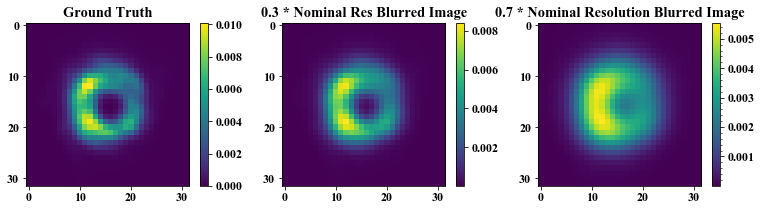

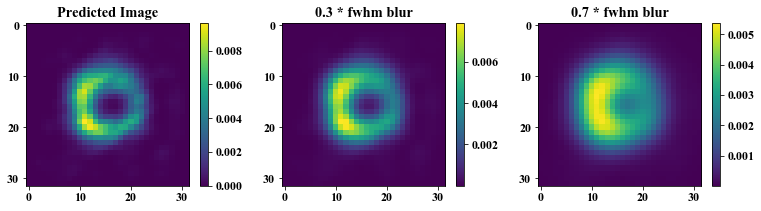

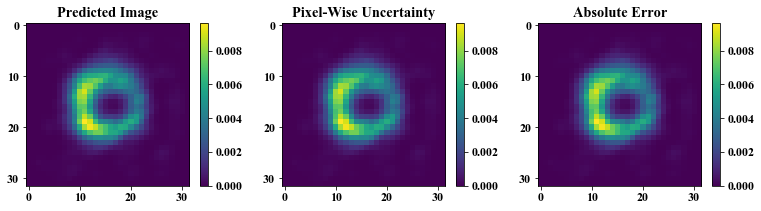

Vis Chi^2 =  2.1429999052
Cphase Chi^2 =  1.0819
Camp Chi^2 =  0.39
XC =  0.9905
2.1429999052
1.0819
0.39
0.9905

Test Image  2903 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

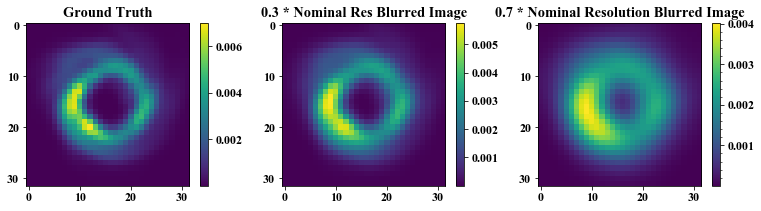

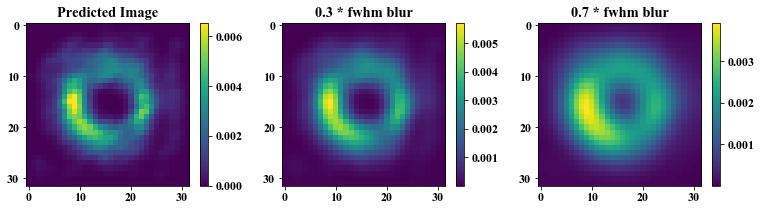

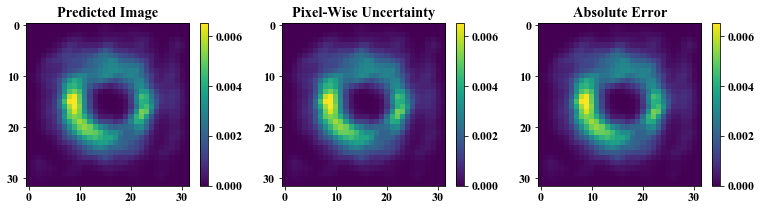

Vis Chi^2 =  5.2150809241
Cphase Chi^2 =  0.185
Camp Chi^2 =  1.4814
XC =  0.9804
5.2150809241
0.185
1.4814
0.9804

Test Image  1419 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

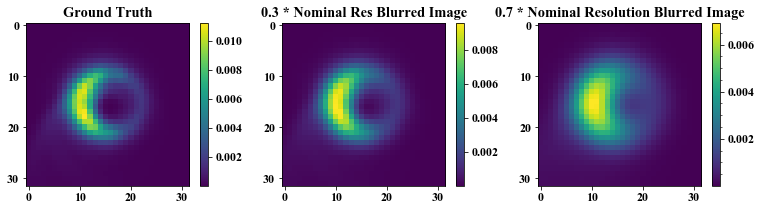

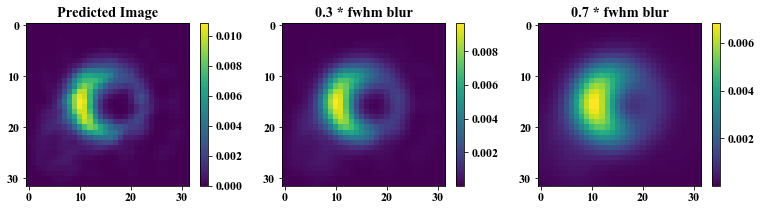

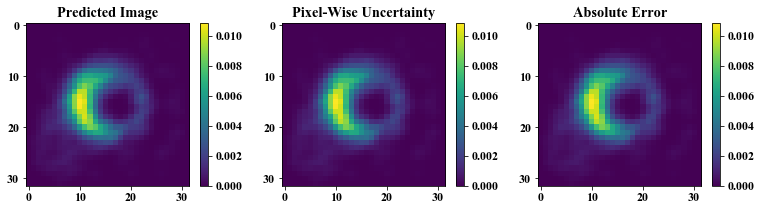

Vis Chi^2 =  3.9528016759
Cphase Chi^2 =  0.5482
Camp Chi^2 =  0.8399
XC =  0.9939
3.9528016759
0.5482
0.8399
0.9939

Test Image  1966 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

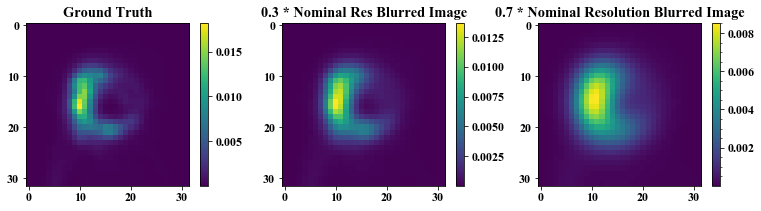

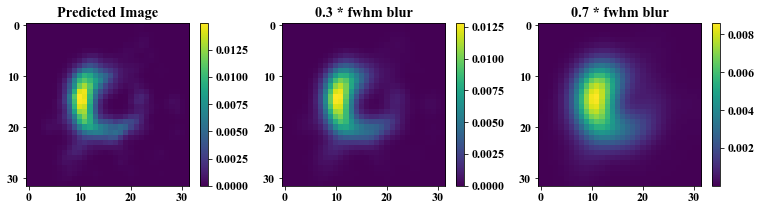

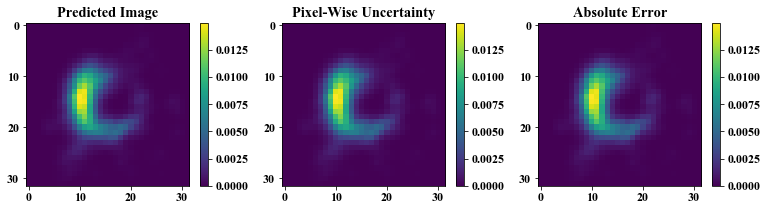

Vis Chi^2 =  8.3222114874
Cphase Chi^2 =  6.1741
Camp Chi^2 =  1.4397
XC =  0.9881
8.3222114874
6.1741
1.4397
0.9881

Test Image  44 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

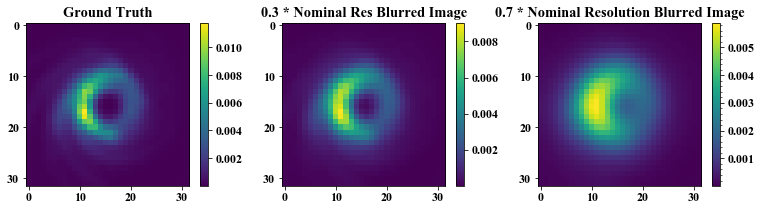

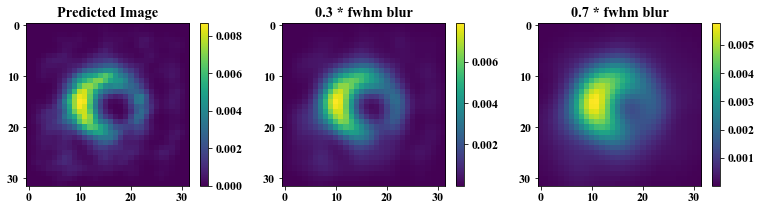

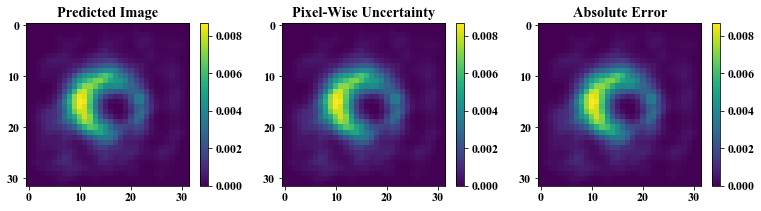

Vis Chi^2 =  45.356454166
Cphase Chi^2 =  42.3554
Camp Chi^2 =  6.1138
XC =  0.9708
45.356454166
42.3554
6.1138
0.9708

Test Image  2993 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

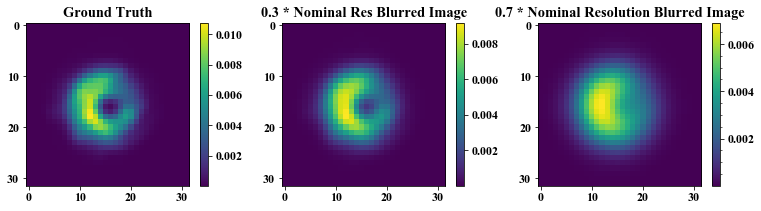

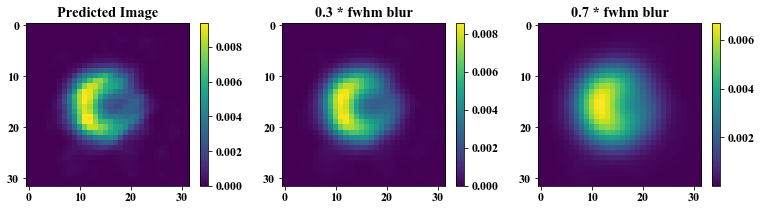

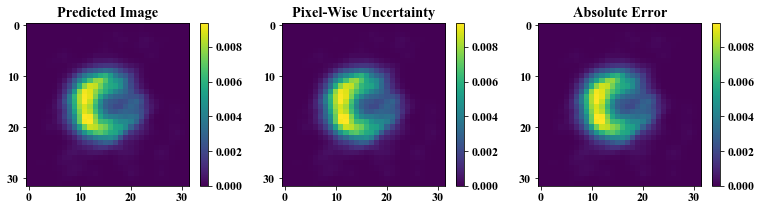

Vis Chi^2 =  5.7062001958
Cphase Chi^2 =  0.6117
Camp Chi^2 =  1.1165
XC =  0.9867
5.7062001958
0.6117
1.1165
0.9867

Test Image  954 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

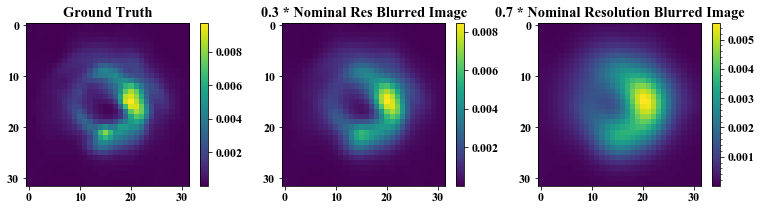

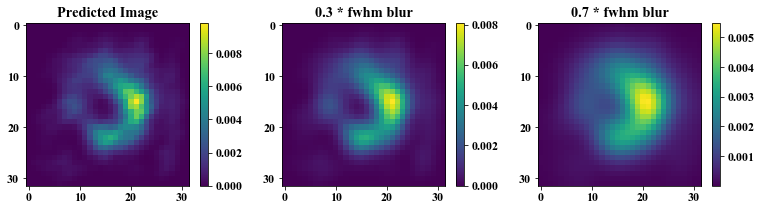

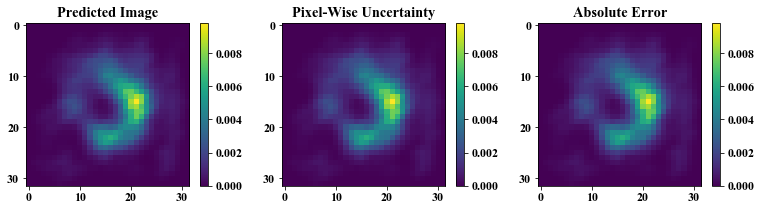

Vis Chi^2 =  20.5870977087
Cphase Chi^2 =  4.9726
Camp Chi^2 =  1.797
XC =  0.9793
20.5870977087
4.9726
1.797
0.9793

Test Image  2811 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

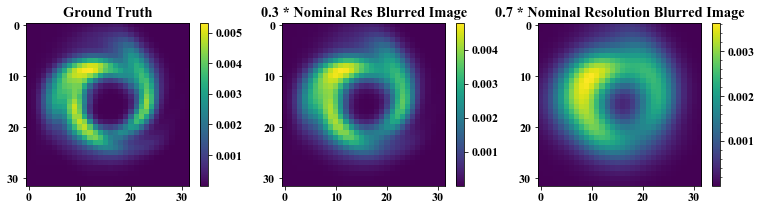

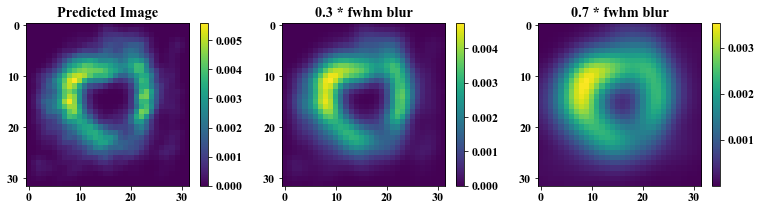

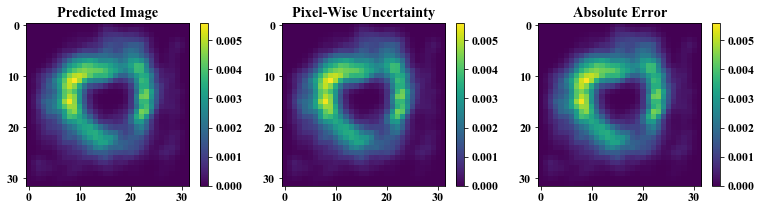

Vis Chi^2 =  12.4865460329
Cphase Chi^2 =  2.4113
Camp Chi^2 =  4.2718
XC =  0.9784
12.4865460329
2.4113
4.2718
0.9784

Test Image  1027 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

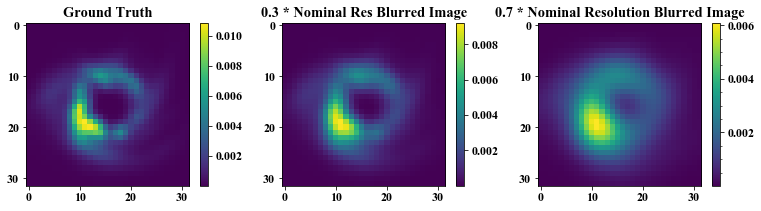

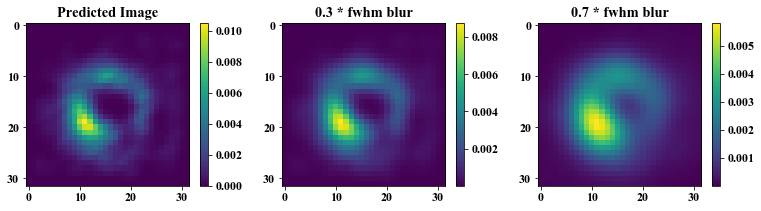

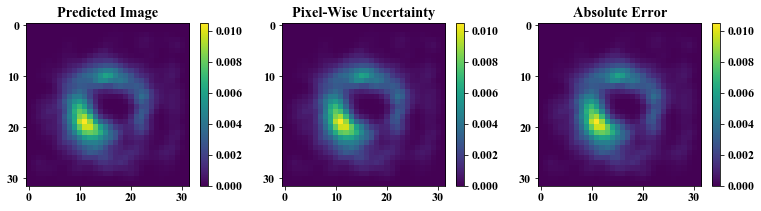

Vis Chi^2 =  31.8562200963
Cphase Chi^2 =  6.0246
Camp Chi^2 =  2.6301
XC =  0.9732
31.8562200963
6.0246
2.6301
0.9732

Results: (alpha= 15 )
Avg. XC =  0.9803
Avg. Vis =  15.6096
Avg. Cphase =  7.6341
Avg. Camp =  4.6866
-----------------------------------------------------------
-------------------  alpha =  20  ---------------------------
-----------------------------------------------------------
Test Image  1006 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
A

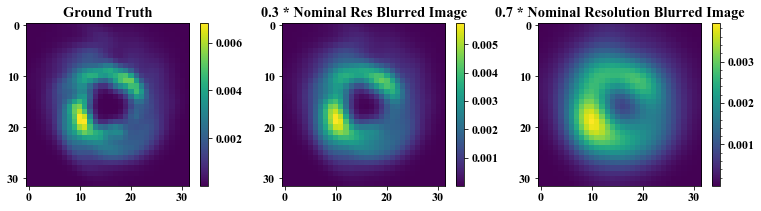

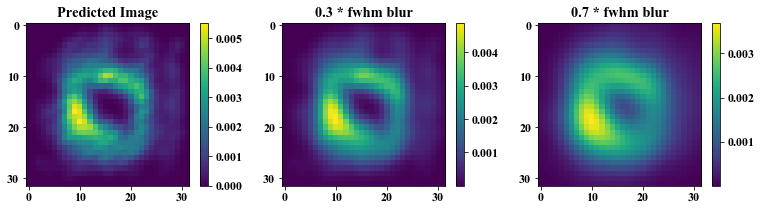

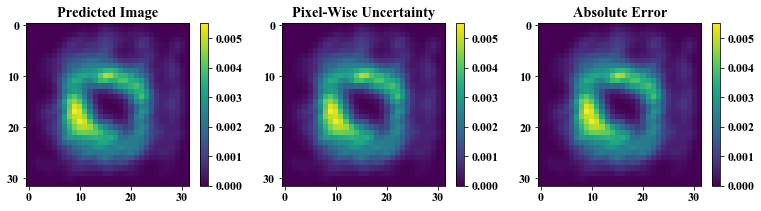

Vis Chi^2 =  5.7815521856
Cphase Chi^2 =  0.5837
Camp Chi^2 =  1.0293
XC =  0.9742
5.7815521856
0.5837
1.0293
0.9742

Test Image  2685 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

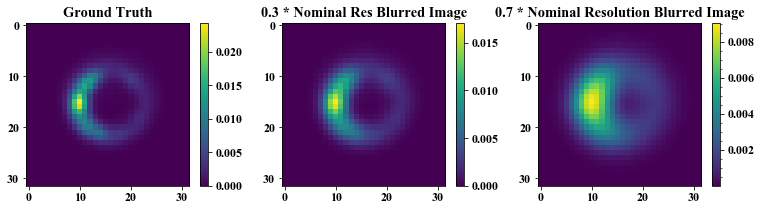

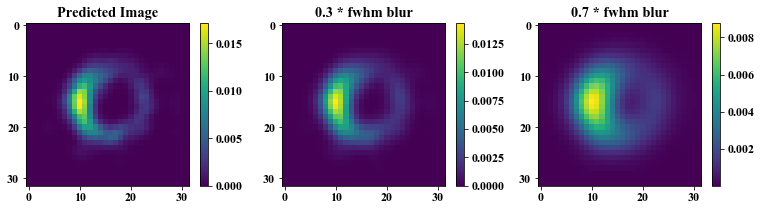

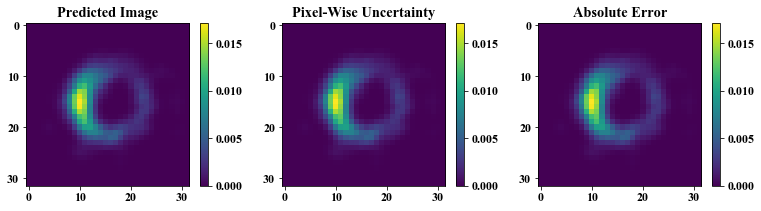

Vis Chi^2 =  21.4687140832
Cphase Chi^2 =  5.2892
Camp Chi^2 =  3.7864
XC =  0.9761
21.4687140832
5.2892
3.7864
0.9761

Test Image  1731 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

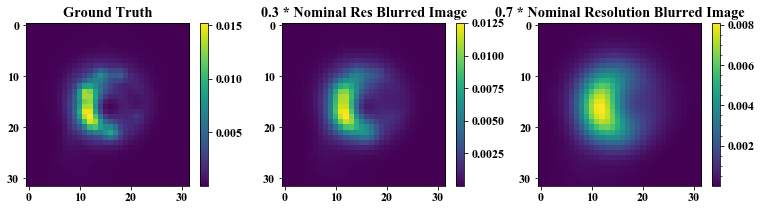

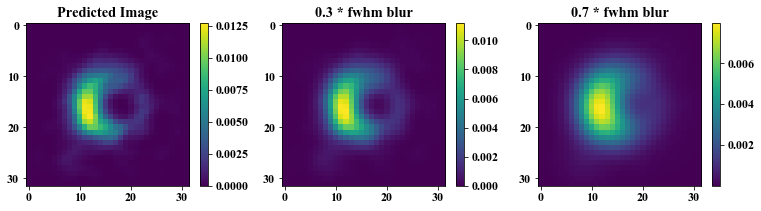

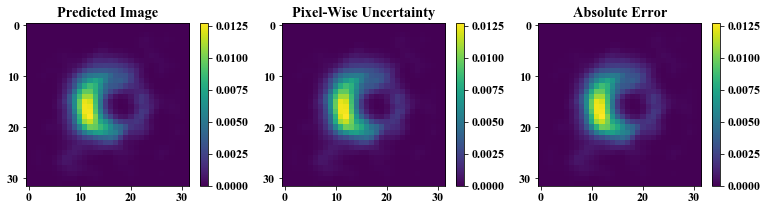

Vis Chi^2 =  3.9498342738
Cphase Chi^2 =  1.0042
Camp Chi^2 =  0.951
XC =  0.984
3.9498342738
1.0042
0.951
0.984

Test Image  2828 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

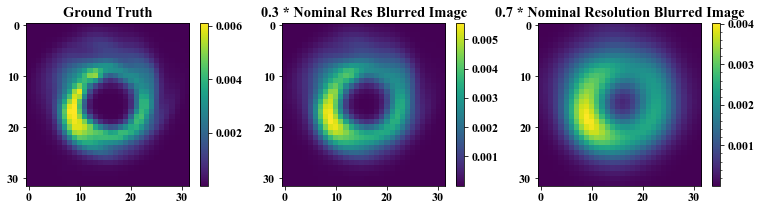

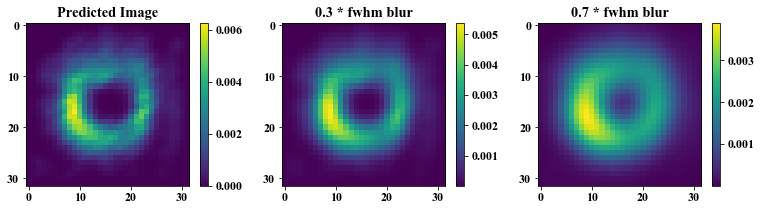

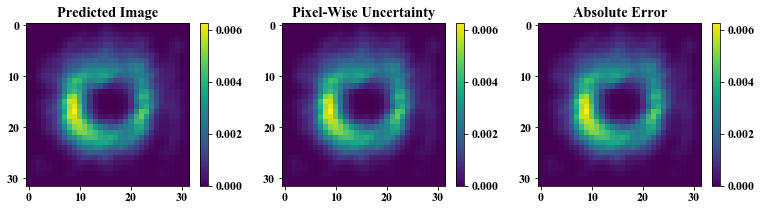

Vis Chi^2 =  4.2032055392
Cphase Chi^2 =  0.2772
Camp Chi^2 =  2.8572
XC =  0.985
4.2032055392
0.2772
2.8572
0.985

Test Image  2791 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

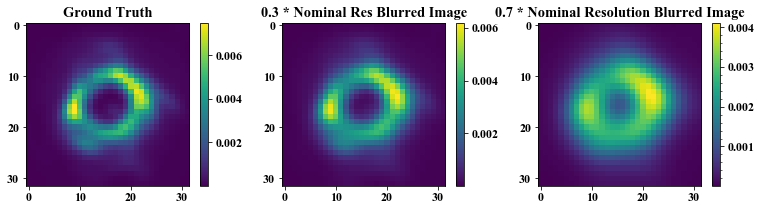

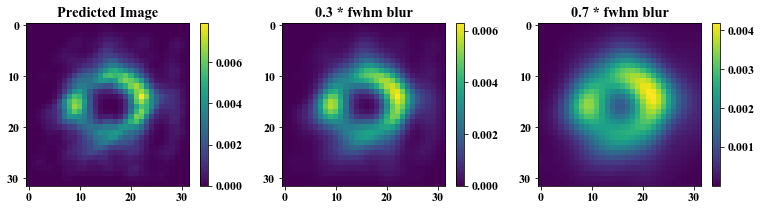

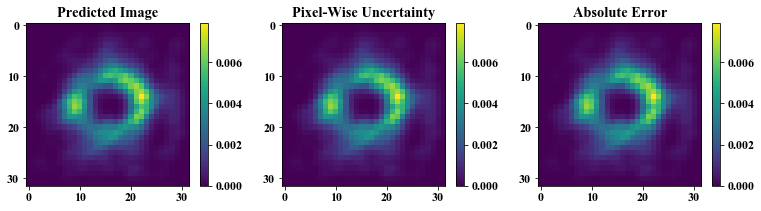

Vis Chi^2 =  32.381227669
Cphase Chi^2 =  24.2824
Camp Chi^2 =  4.619
XC =  0.9769
32.381227669
24.2824
4.619
0.9769

Test Image  687 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

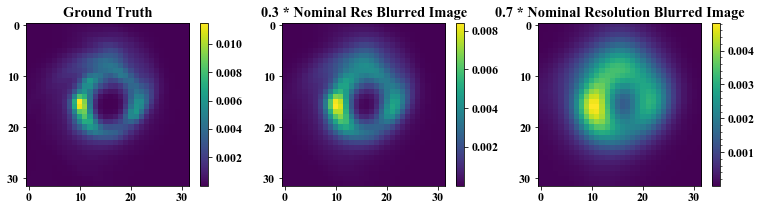

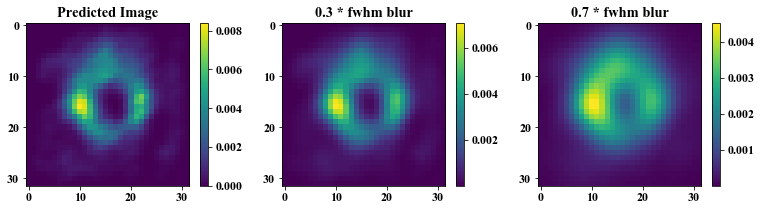

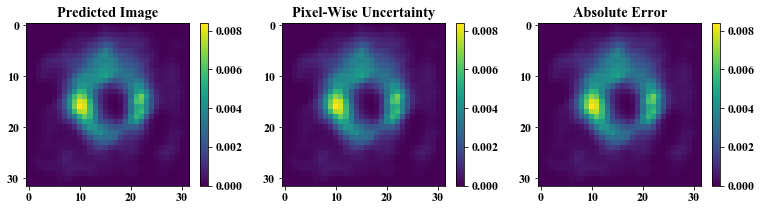

Vis Chi^2 =  30.7338100115
Cphase Chi^2 =  18.7099
Camp Chi^2 =  36.976
XC =  0.9677
30.7338100115
18.7099
36.976
0.9677

Test Image  2127 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , c

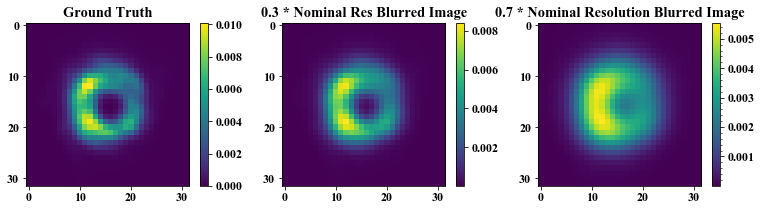

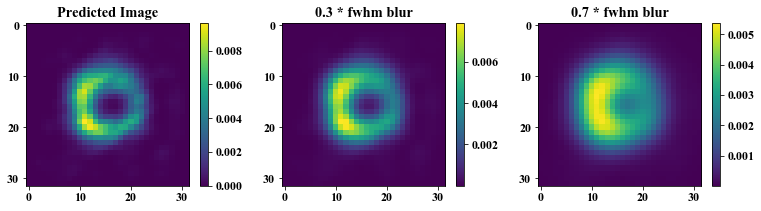

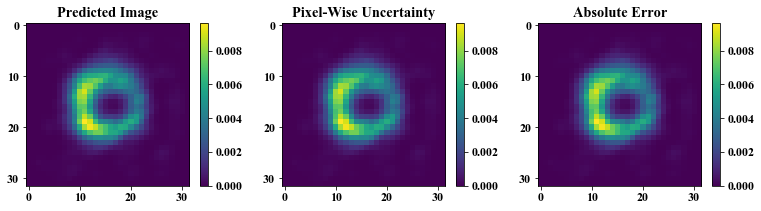

Vis Chi^2 =  2.1429999052
Cphase Chi^2 =  1.0819
Camp Chi^2 =  0.39
XC =  0.9905
2.1429999052
1.0819
0.39
0.9905

Test Image  2903 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max

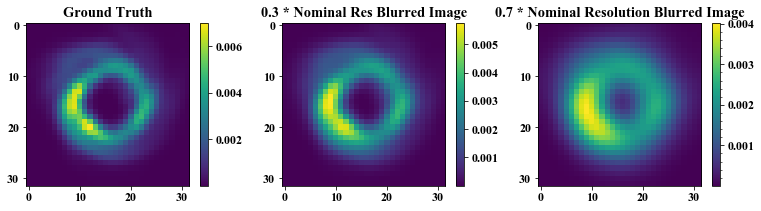

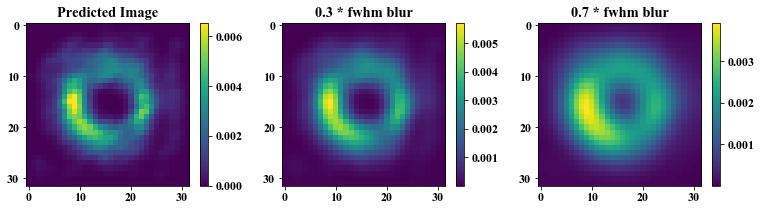

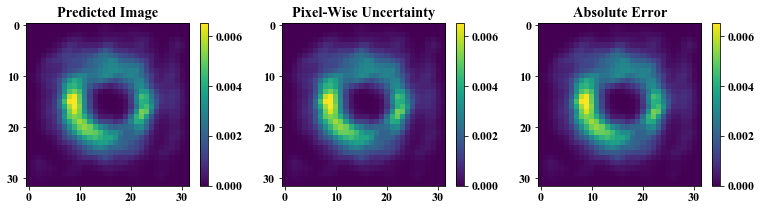

Vis Chi^2 =  5.2150809241
Cphase Chi^2 =  0.185
Camp Chi^2 =  1.4814
XC =  0.9804
5.2150809241
0.185
1.4814
0.9804

Test Image  1419 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

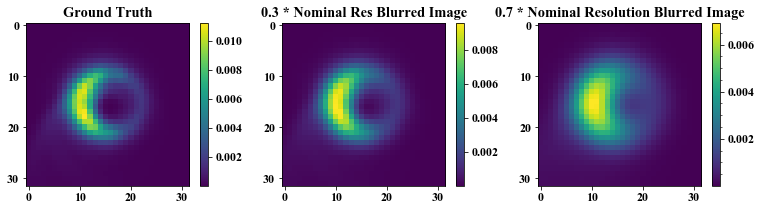

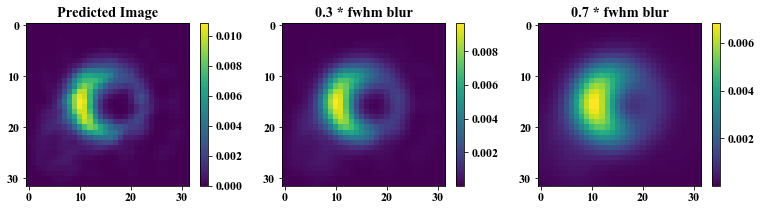

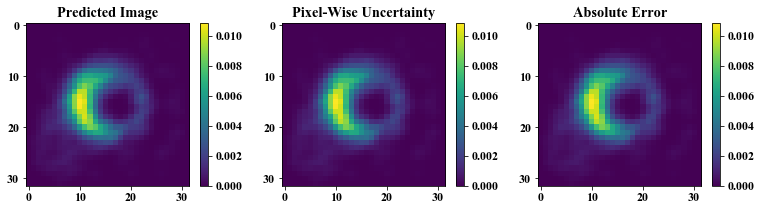

Vis Chi^2 =  3.9528016759
Cphase Chi^2 =  0.5482
Camp Chi^2 =  0.8399
XC =  0.9939
3.9528016759
0.5482
0.8399
0.9939

Test Image  1966 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

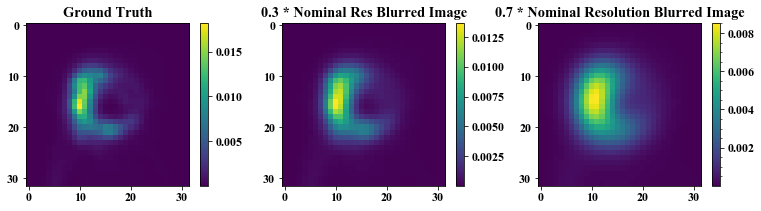

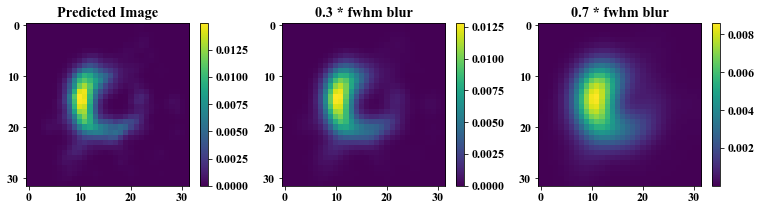

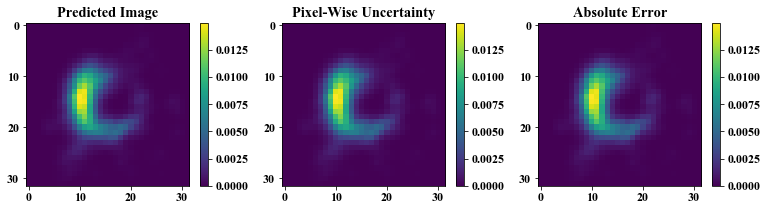

Vis Chi^2 =  8.3222114874
Cphase Chi^2 =  6.1741
Camp Chi^2 =  1.4397
XC =  0.9881
8.3222114874
6.1741
1.4397
0.9881

Test Image  44 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count m

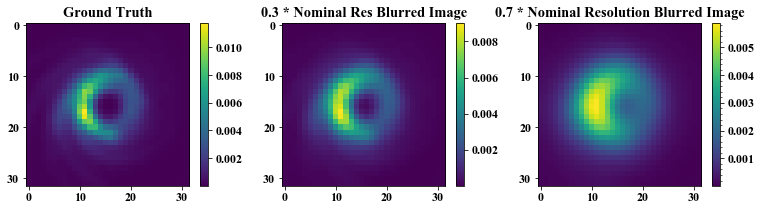

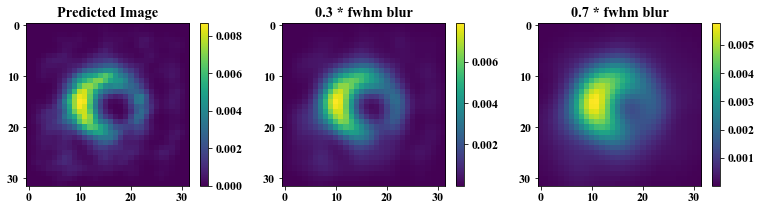

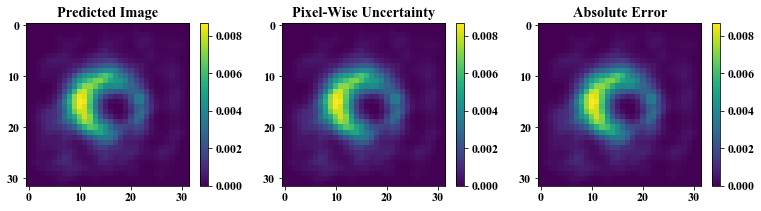

Vis Chi^2 =  45.356454166
Cphase Chi^2 =  42.3554
Camp Chi^2 =  6.1138
XC =  0.9708
45.356454166
42.3554
6.1138
0.9708

Test Image  2993 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

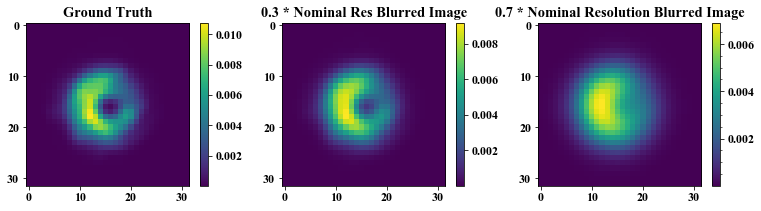

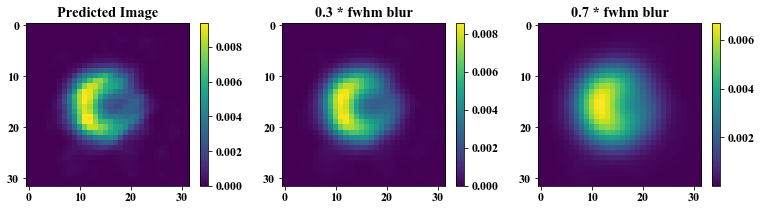

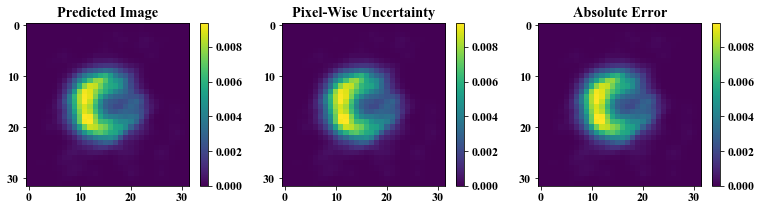

Vis Chi^2 =  5.7062001958
Cphase Chi^2 =  0.6117
Camp Chi^2 =  1.1165
XC =  0.9867
5.7062001958
0.6117
1.1165
0.9867

Test Image  954 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count 

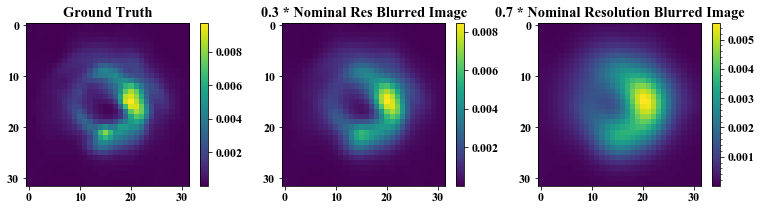

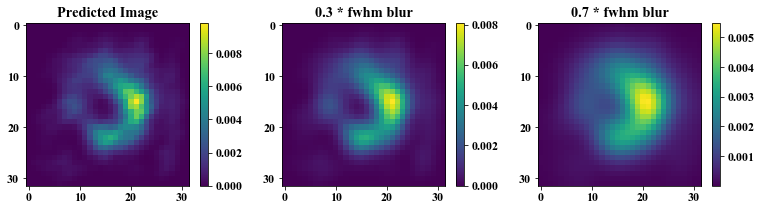

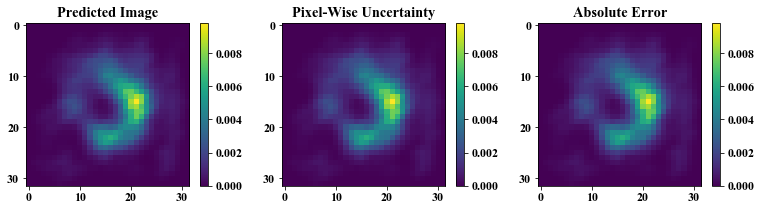

Vis Chi^2 =  20.5870977087
Cphase Chi^2 =  4.9726
Camp Chi^2 =  1.797
XC =  0.9793
20.5870977087
4.9726
1.797
0.9793

Test Image  2811 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count

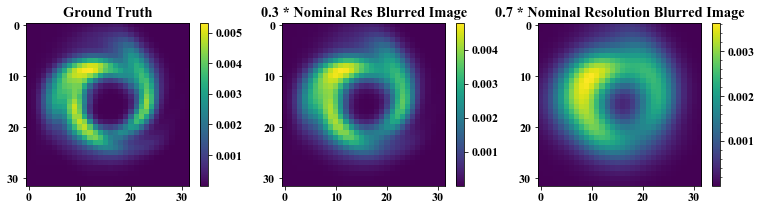

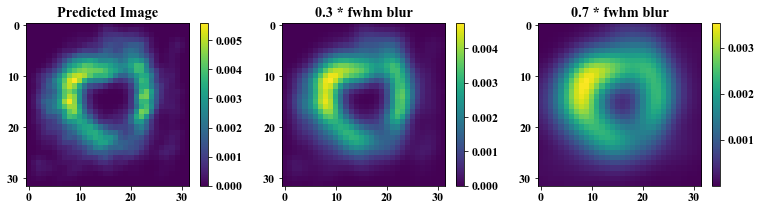

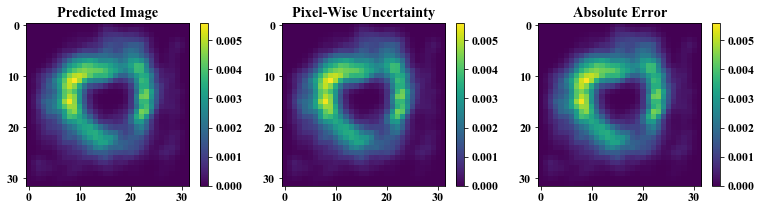

Vis Chi^2 =  12.4865460329
Cphase Chi^2 =  2.4113
Camp Chi^2 =  4.2718
XC =  0.9784
12.4865460329
2.4113
4.2718
0.9784

Test Image  1027 / 15 ...
-----------------------------------------------------------
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , count max, scan 106/106

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Finished computing visibilities...
Getting bispectra:: type vis, count max, scan 106/106 

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

Getting closure amps:: type vis camp , cou

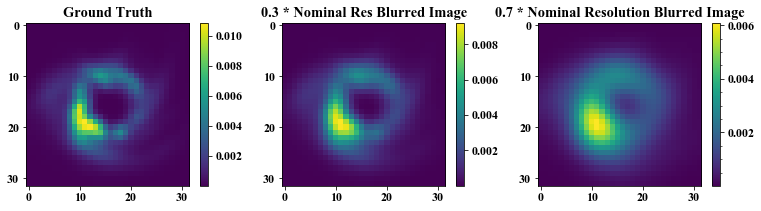

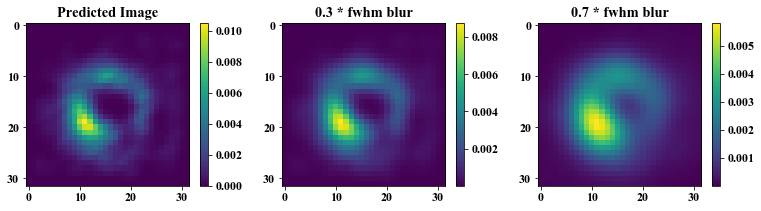

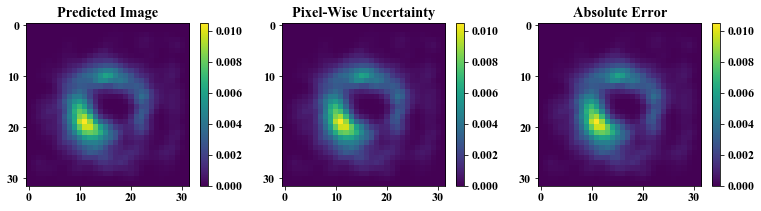

Vis Chi^2 =  31.8562200963
Cphase Chi^2 =  6.0246
Camp Chi^2 =  2.6301
XC =  0.9732
31.8562200963
6.0246
2.6301
0.9732

Results: (alpha= 20 )
Avg. XC =  0.9803
Avg. Vis =  15.6096
Avg. Cphase =  7.6341
Avg. Camp =  4.6866
XC Averaged Values:
[0.9803436709580347]
Vis Chi^2 Averaged Values:
[15.60959706365095]


In [336]:
''' Thermal Noise: Run Averaging Tests Over 15 Test Images '''
# Get dataset
print("Getting dataset...")
dataset = 'bh_data'
xdata = get_data(dataset)

th_noise = False    # add thermal noise
amp_err = False     # add amp error
phase_err = False   # add phase error

# Get test sample from dataset
#random_idx = [9002,9681,9727,9824,9787,9683,9123,9899,9415,9962,9540,9989,9950,9807,9023]
random_idx = [1006,2685,1731,2828,2791,687,2127,2903,1419,1966,44,2993,954,2811,1027]

dir_path = 'Complex Visibilities/Images/nonoise_model/'
th_noise_factors = [1, 2, 5, 10, 15, 20]
for alpha in th_noise_factors:
    print('-----------------------------------------------------------')
    print('------------------- ', 'alpha = ', alpha, ' ---------------------------')
    print('-----------------------------------------------------------')
    
    # Store error statistics
    xc_vals = []
    vis_vals = []

    for idx in random_idx:
        print("Test Image ", idx, "/", len(random_idx),"...")
        print('-----------------------------------------------------------')

        target = xdata[idx]
        filename = dir_path+dataset+'_idx'+str(idx)+'.0_alpha'+str(alpha)+'.npy'
        if alpha == 0:
            filename = dir_path+dataset+'_idx'+str(idx)+'.0.npy'
        pred = np.load(filename)
        vis_chisq, cphase_chisq, camp_chisq, recon_xc = run_test(model, target, ALPHA, th_noise, amp_err, phase_err, pred_img=pred, blur_param=0.3)

        avg_xc.append(recon_xc)
        avg_vis_chisq.append(vis_chisq)
        avg_cphase_chisq.append(cphase_chisq)
        avg_camp_chisq.append(camp_chisq)

    print("Results: (alpha=", alpha, ")")
    print("Avg. XC = ", round(np.mean(avg_xc), 4))
    print("Avg. Vis = ", round(np.mean(avg_vis_chisq), 4))
    print("Avg. Cphase = ", round(np.mean(avg_cphase_chisq), 4))
    print("Avg. Camp = ", round(np.mean(avg_camp_chisq), 4))
    
    xc_vals.append(np.mean(avg_xc))
    vis_vals.append(np.mean(avg_vis_chisq))
    
print("XC Averaged Values:")
print(xc_vals)
print("Vis Chi^2 Averaged Values:")
print(vis_vals)
